# Try HMM

Not entirely sure how these work but will word it out as I go along.


https://towardsdatascience.com/hidden-markov-models-for-time-series-classification-basic-overview-a59b74e5e65b
    Normally towardsdatascience is really good but this makes no sense to me at all.

This article is more complicated, but also indepth and explains stuff more. - https://towardsdatascience.com/markov-chains-and-hmms-ceaf2c854788

Some guys github repository using HMM for binary sentimental analysis of tweets - https://github.com/FantacherJOY/Hidden-Markov-Model-for-NLP


"In the case one label is way more frequent than the other (say Class B appears for every 100 samples of Class A), or in the case one category is broader than the other (have more variance, i.e. Class A is an expected behavior of a process and Class B is all the cases that are abnormal), then we might want to train a unique HMM for Class A. For each new sample, we compute the likelihood to the model, and if it falls below a pre-defined threshold (that can be chosen with respect to some validation sample, or in the worst case, from the training samples themselves) we assign this sample to Class B. If the likelihood is above the threshold, we assign the sample to Class A." - https://datascience.stackexchange.com/questions/8560/can-hmm-be-used-as-a-binary-classifier

In [1]:
# imports
from hmmlearn import hmm
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt

# Load in data
# index_col stops index being read as column
df_turk = pd.read_csv('turk-Data-renamed.csv', index_col=0)
df_lab = pd.read_csv('lab-Data-renamed.csv', index_col=0)

In [2]:
# Load in data

# Data Engineering

Initial exploration shown to be promising.
Now do some data engineering to get the targets into the format I want.

In [3]:
# First get the targets data in a time series of time, target, and ID.

# When we remove the mouse event we have much more duplicate data.
# Drop this data and reset the indexes to account for missing values.
# Since there was a correlation between time and number of mouse events maybe I can use index to substitue for time.

df_m_lab = df_lab[['target', 'time', 'turkId']]     # m for markov
lab_dups = len(df_m_lab)-len(df_m_lab.drop_duplicates())
print(f'Number of duplicate items in lab data: {lab_dups}')
print(f'Percentage duplicate: {lab_dups / len(df_lab) * 100}\n')
df_m_lab = df_m_lab.drop_duplicates()

df_m_turk = df_turk[['target', 'time', 'turkId']]
turk_dups = len(df_m_turk)-len(df_m_turk.drop_duplicates())
print(f'Number of duplicate items in turk data: {turk_dups}')
print(f'Percentage duplicate: {turk_dups / len(df_m_turk) * 100}')
df_m_turk = df_m_turk.drop_duplicates()

df_m_lab

Number of duplicate items in lab data: 9482
Percentage duplicate: 25.309630578688875

Number of duplicate items in turk data: 180378
Percentage duplicate: 21.656231428176945


,target,time,turkId
0,alloc-slider-5,0.000000,ID1
1,alloc-slider-5,0.547000,ID1
3,alloc-slider-5,1.176995,ID1
4,alloc-slider-5,1.790000,ID1
5,html,2.896995,ID1
...,...,...,...
58261,alloc-slider-2,273.796495,ID18
58263,alloc-slider-2,273.836415,ID18
58265,alloc-slider-2,273.924560,ID18
58270,html,274.968440,ID18


In [4]:
# TODO: Might have to convert targets to numerical representation, maybe one-hot encoding?

# Replace html with 0, and alloc-slider-1 to 1, alloc-slider-2 to 2, alloc-slider-3 to 3, alloc-slider-4 to 4, alloc-slider-5 to 5

df_m_lab.loc[df_m_lab['target'].str.contains('html'), 'target'] = '0'
df_m_lab.loc[df_m_lab['target'].str.contains('alloc-slider-1'), 'target'] = '1'
df_m_lab.loc[df_m_lab['target'].str.contains('alloc-slider-2'), 'target'] = '2'
df_m_lab.loc[df_m_lab['target'].str.contains('alloc-slider-3'), 'target'] = '3'
df_m_lab.loc[df_m_lab['target'].str.contains('alloc-slider-4'), 'target'] = '4'
df_m_lab.loc[df_m_lab['target'].str.contains('alloc-slider-5'), 'target'] = '5'
data_lab = df_m_lab['target'].to_numpy().reshape(-1, 1)

df_m_turk.loc[df_m_turk['target'].str.contains('html'), 'target'] = '0'
df_m_turk.loc[df_m_turk['target'].str.contains('alloc-slider-1'), 'target'] = '1'
df_m_turk.loc[df_m_turk['target'].str.contains('alloc-slider-2'), 'target'] = '2'
df_m_turk.loc[df_m_turk['target'].str.contains('alloc-slider-3'), 'target'] = '3'
df_m_turk.loc[df_m_turk['target'].str.contains('alloc-slider-4'), 'target'] = '4'
df_m_turk.loc[df_m_turk['target'].str.contains('alloc-slider-5'), 'target'] = '5'
data_turk = df_m_turk['target'].astype('int32').to_numpy().reshape(-1, 1)
data_turk.shape

(652537, 1)

In [5]:
# we want to have everything in one long array like this.
# But then we need to create the lengths array thing.

lab_lengths = []
for ID in df_m_lab['turkId'].unique():
    length_for_ID = len( df_m_lab[df_m_lab['turkId'] == ID] )
    lab_lengths.append(length_for_ID)

turk_lengths = []
for ID in df_m_turk['turkId'].unique():
    length_for_ID = len( df_m_turk[df_m_turk['turkId'] == ID] )
    turk_lengths.append(length_for_ID)

lab_lengths

[2267,
 2341,
 2341,
 646,
 597,
 3116,
 1531,
 490,
 2666,
 469,
 3754,
 3754,
 2005,
 2005]

In [6]:
# Create Lab data HMM

# Suggestions for number of hidden states.
# https://www.researchgate.net/post/Is_there_any_simple_rule_for_the_number_of_states_in_HMM

# Picked 6 hidden states as thats what the actual system has. sliders 1-5 and other
lab_model = hmm.GaussianHMM(n_components=6, verbose=True).fit(data_lab, lab_lengths) # dont know how many components/hidden states I should have
lab_model

1      -56759.1163             +nan
         2      -47711.6643       +9047.4520
         3      -40440.3305       +7271.3338
         4      -36838.0855       +3602.2450
         5      -33898.1212       +2939.9643
         6      -25847.4826       +8050.6386
         7       -8453.8532      +17393.6294
         8       39070.2581      +47524.1114
         9       56067.9756      +16997.7175
        10       99424.0314      +43356.0558


GaussianHMM(algorithm='viterbi', covariance_type='diag', covars_prior=0.01,
            covars_weight=1, init_params='stmc', means_prior=0, means_weight=0,
            min_covar=0.001, n_components=6, n_iter=10, params='stmc',
            random_state=None, startprob_prior=1.0, tol=0.01,
            transmat_prior=1.0, verbose=True)

In [7]:
lab_model.sample(10)

(array([[-0.03686761],
        [ 0.12170202],
        [ 0.005011  ],
        [ 0.08485085],
        [ 0.09094252],
        [ 0.07320014],
        [ 3.00018727],
        [ 3.00004367],
        [ 2.99958977],
        [ 2.99803456]]),
 array([5, 5, 5, 5, 5, 5, 4, 4, 4, 4]))

In [8]:
# Lab Transition Matrix
np.round(lab_model.transmat_, 3)

array([[0.948, 0.004, 0.015, 0.002, 0.02 , 0.012],
       [0.006, 0.948, 0.005, 0.021, 0.005, 0.015],
       [0.027, 0.005, 0.941, 0.003, 0.007, 0.017],
       [0.002, 0.019, 0.001, 0.953, 0.012, 0.014],
       [0.018, 0.005, 0.005, 0.019, 0.942, 0.011],
       [0.013, 0.018, 0.025, 0.015, 0.015, 0.913]])

In [9]:
turk_model = hmm.GaussianHMM(n_components=6, verbose=True).fit(data_turk.reshape(-1, 1), turk_lengths) # dont know how many components/hidden states I should have
turk_model

1    -1362170.3784             +nan
         2    -1168812.4272     +193357.9513
         3     -980231.5847     +188580.8425
         4     -890578.3868      +89653.1978
         5     -820547.0694      +70031.3174
         6     -652062.7092     +168484.3603
         7     -424897.2640     +227165.4452
         8      250420.6334     +675317.8974
         9     1672130.3088    +1421709.6754
        10     3958857.5286    +2286727.2198


GaussianHMM(algorithm='viterbi', covariance_type='diag', covars_prior=0.01,
            covars_weight=1, init_params='stmc', means_prior=0, means_weight=0,
            min_covar=0.001, n_components=6, n_iter=10, params='stmc',
            random_state=None, startprob_prior=1.0, tol=0.01,
            transmat_prior=1.0, verbose=True)

In [10]:
# Show transition matrix of hidden states.
# TODO: compute actual system trasitions with n-grams.

np.round(turk_model.transmat_, 2)

array([[0.93, 0.03, 0.  , 0.  , 0.01, 0.02],
       [0.02, 0.93, 0.01, 0.01, 0.02, 0.02],
       [0.  , 0.02, 0.95, 0.  , 0.  , 0.01],
       [0.  , 0.02, 0.  , 0.95, 0.02, 0.  ],
       [0.01, 0.02, 0.  , 0.01, 0.95, 0.  ],
       [0.01, 0.02, 0.02, 0.  , 0.01, 0.94]])

In [11]:
# Create a new data samples of length 10.

np.round(np.array(turk_model.sample(10)[0]).reshape(-1),2)


array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [12]:

# Have to have all this extra code because the data is stored in a big long list so need to kind of extract the user details again.

def model_score_list(model, data, lengths):
    # Given a model and some data and lengths return a list of likelihoods that each different data sample belongs to that HMM.

    probas = []

    start_i = 0
    #end_i = start_i + lab_lengths[0]
    end_i = 0

    for i in range(len(lengths)):
        end_i = start_i + lengths[i]

        users_items = data[start_i:end_i]
        
        #print(i)
        #print( model.score( users_items ) )
        probas.append( model.score(users_items) )

        start_i = lengths[i] # lab_lengths[0]
        #end_i = start_i + lab_lengths[i+1]

    return probas

model_score_list(turk_model, data_lab, lab_lengths)    # Try lab data on turk model

[15321.819068801915,
 15933.351630939327,
 15935.685087526974,
 4296.340267084628,
 4073.787478617579,
 21229.521961675677,
 10521.516918092302,
 3380.5200035299304,
 18104.63275481958,
 3181.3101293342193,
 25630.308427388693,
 25590.18325876103,
 13596.270240143715,
 13605.720619405176]

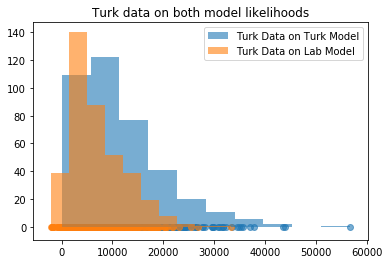

In [13]:
turk_data_turk_model = model_score_list(turk_model, data_turk, turk_lengths)  # Try turk data on turk model
turk_data_lab_model = model_score_list(lab_model, data_turk, turk_lengths)  # Try turk data on lab model

plt.hist(turk_data_turk_model, bins=10, label='Turk Data on Turk Model', alpha=0.6)
plt.hist(turk_data_lab_model, bins=10, label='Turk Data on Lab Model', alpha=0.6)

plt.title('Turk data on both model likelihoods')
plt.legend(loc='best')

# Also show the individual points on there too because why not.
plt.scatter( turk_data_turk_model, np.zeros((len(turk_data_turk_model),1)), label='Turk Data on Turk Model', alpha=0.6 )
plt.scatter( turk_data_lab_model, np.zeros((len(turk_data_lab_model),1)), label='Turk Data on Lab Model', alpha=0.6 )

plt.show()

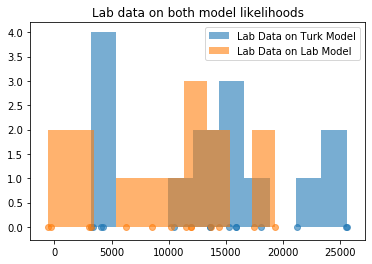

In [14]:
lab_data_turk_model = model_score_list(turk_model, data_lab, lab_lengths)  # Try lab data on turk model
lab_data_lab_model = model_score_list(lab_model, data_lab, lab_lengths)  # Try lab data on lab model

plt.hist(lab_data_turk_model, bins=10, label='Lab Data on Turk Model', alpha=0.6)
plt.hist(lab_data_lab_model, bins=10, label='Lab Data on Lab Model', alpha=0.6)

plt.title('Lab data on both model likelihoods')
plt.legend(loc='best')

# Also show the individual points on there too because why not.
plt.scatter( lab_data_turk_model, np.zeros((len(lab_data_turk_model),1)), label='Lab Data on Turk Model', alpha=0.6 )
plt.scatter( lab_data_lab_model, np.zeros((len(lab_data_lab_model),1)), label='Lab Data on Lab Model', alpha=0.6 )

plt.show()

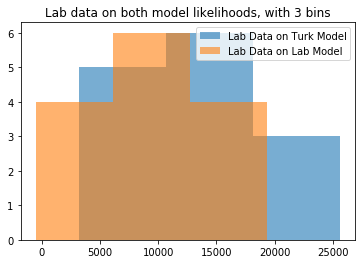

In [15]:
# This graph clearly shows that on average, the lab data is more likely to be classified as a turk model.

plt.hist(lab_data_turk_model, bins=3, label='Lab Data on Turk Model', alpha=0.6)
plt.hist(lab_data_lab_model, bins=3, label='Lab Data on Lab Model', alpha=0.6)

plt.title('Lab data on both model likelihoods, with 3 bins')
plt.legend(loc='best')
plt.show()

In [16]:
print(lab_model.score(data_lab, lab_lengths))
print(turk_model.score(data_lab, lab_lengths))
print()
print(lab_model.score(data_turk, turk_lengths))
print(turk_model.score(data_turk, turk_lengths))

135568.918028391
191936.57919228665

2877439.5698934393
4491847.116146398


# Reassigning samples

Now run all lab and turk data through both models. 
Assign a predicted label (lab / online) data.
Afterwards compare actual and predicted to see if any samples seem to be missclassified.  

In [17]:

# Have to have all this extra code because the data is stored in a big long list so need to kind of extract the user details again.

def reclassify_samples(turk_model, lab_model, data, lengths):
    # Given a model and some data and lengths return a list of predicted new classes.

    new_classes = []

    start_i = 0
    end_i = 0

    for i in range(len(lengths)):
        end_i = start_i + lengths[i]

        users_items = data[start_i:end_i]
        
        # Turks are 0, labs are 1

        turk_likelihood = turk_model.score(users_items)
        lab_likelihood = lab_model.score(users_items)

        print(f'User {i}: \t turk: {int(turk_likelihood)}, \t lab: {int(lab_likelihood)}')

        if ( turk_likelihood > lab_likelihood ):
            new_classes.append(0)
        else:
            new_classes.append(1)

        start_i = lengths[i] 

    return new_classes

reclassify_samples(turk_model, lab_model, data_lab, lab_lengths)    # Try lab data on turk model

User 0: 	 turk: 15321, 	 lab: 11504
User 1: 	 turk: 15933, 	 lab: 11965
User 2: 	 turk: 15935, 	 lab: 11967
User 3: 	 turk: 4296, 	 lab: 3179
User 4: 	 turk: 4073, 	 lab: 3068
User 5: 	 turk: 21229, 	 lab: 14385
User 6: 	 turk: 10521, 	 lab: 6266
User 7: 	 turk: 3380, 	 lab: -315
User 8: 	 turk: 18104, 	 lab: 13686
User 9: 	 turk: 3181, 	 lab: -532
User 10: 	 turk: 25630, 	 lab: 19323
User 11: 	 turk: 25590, 	 lab: 17532
User 12: 	 turk: 13596, 	 lab: 8532
User 13: 	 turk: 13605, 	 lab: 10210


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [18]:
reclassify_samples(turk_model, lab_model, data_turk, turk_lengths)    # Try lab data on turk model

User 0: 	 turk: 2467, 	 lab: 1868
User 1: 	 turk: 4227, 	 lab: 3180
User 2: 	 turk: 6973, 	 lab: 3661
User 3: 	 turk: 5598, 	 lab: 4177
User 4: 	 turk: 1241, 	 lab: 896
User 5: 	 turk: 1979, 	 lab: -1451
User 6: 	 turk: 2947, 	 lab: 1510
User 7: 	 turk: 5634, 	 lab: 3540
User 8: 	 turk: 17405, 	 lab: 12330
User 9: 	 turk: 6795, 	 lab: 1526
User 10: 	 turk: 4572, 	 lab: 3539
User 11: 	 turk: 14880, 	 lab: 10322
User 12: 	 turk: 2808, 	 lab: 1415
User 13: 	 turk: 6368, 	 lab: 1900
User 14: 	 turk: 5237, 	 lab: 3998
User 15: 	 turk: 12539, 	 lab: 6410
User 16: 	 turk: 2723, 	 lab: -882
User 17: 	 turk: 6061, 	 lab: 1664
User 18: 	 turk: 3788, 	 lab: 2866
User 19: 	 turk: 3248, 	 lab: 2424
User 20: 	 turk: 10500, 	 lab: 7128
User 21: 	 turk: 19460, 	 lab: 13834
User 22: 	 turk: 22594, 	 lab: 12707
User 23: 	 turk: 11376, 	 lab: 6464
User 24: 	 turk: 2978, 	 lab: 2103
User 25: 	 turk: 20133, 	 lab: 13710
User 26: 	 turk: 4124, 	 lab: 2822
User 27: 	 turk: 14179, 	 lab: 8980
User 28: 	 turk:

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


# AMAZING IDEA

hmmlearn has the function .SAMPLE(n). This Generates random samples from the model.

With some effort could potentially use this to generate new samples for lab data!

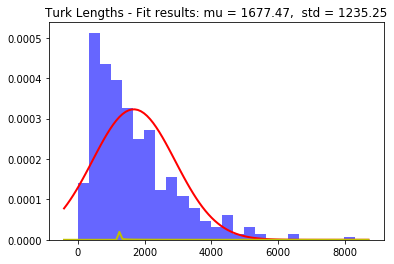

In [19]:
# See if lab_lengths follow a normal distribution
# Lab lengths kind of follow this distribution but not really.
#https://stackoverflow.com/questions/20011122/fitting-a-normal-distribution-to-1d-data

from scipy.stats import norm
from scipy.stats import lognorm

mu, std = norm.fit(turk_lengths)

plt.hist(turk_lengths, bins=25, density=True, alpha=0.6, color='b')

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)

p2 = lognorm.pdf(x, mu, std)
plt.plot(x, p, 'r', linewidth=2)
plt.plot(x, p2, 'y', linewidth=2)
title = "Turk Lengths - Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

plt.show()

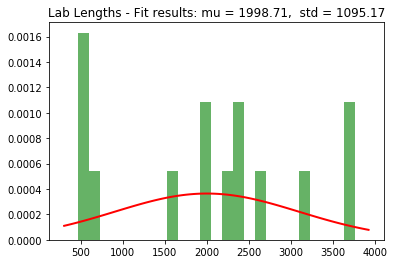

In [20]:
# See if Lab data follows a distrinution

mu, std = norm.fit(lab_lengths)

plt.hist(lab_lengths, bins=25, density=True, alpha=0.6, color='g')

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'r', linewidth=2)
title = "Lab Lengths - Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

plt.show()

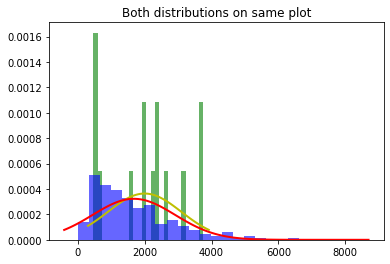

In [21]:
# Both on 1 graph?

mu, std = norm.fit(lab_lengths)

plt.hist(lab_lengths, bins=25, density=True, alpha=0.6, color='g')

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'y', linewidth=2)
plt.title('Both distributions on same plot')

mu, std = norm.fit(turk_lengths)

plt.hist(turk_lengths, bins=25, density=True, alpha=0.6, color='b')

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'r', linewidth=2)

plt.show()

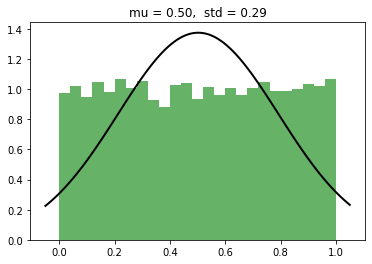

In [22]:
#Showing how a random uniform variable can still look like a gaussian   

x = np.random.rand(10000)

# See if Lab data follows a distrinution

mu, std = norm.fit(x)

plt.hist(x, bins=25, density=True, alpha=0.6, color='g')

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

plt.show()

Text(0.5, 1.0, 'Both Lengths - Fit results: mu = 1688.63,  std = 1232.06')

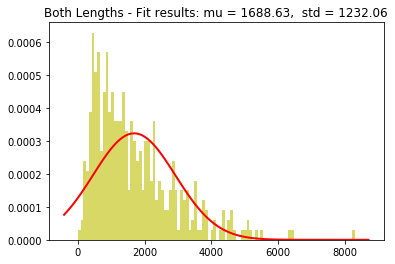

In [23]:
# Combine both data together and see what the distribution looks like
# Probably a bit pointless as the turk data will still be so much more numerous

both_lengths = np.append(turk_lengths,lab_lengths)
both_lengths = np.array(np.append(turk_lengths,lab_lengths), dtype=float)

mu, std = norm.fit(both_lengths)

plt.hist(both_lengths, bins=100, density=True, alpha=0.6, color='y')

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'r', linewidth=2)
title = "Both Lengths - Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

# Length Distributions.
Thought this would be a failure at first but this is actually really amazing!
Can CLEARLY see a distribution off turk lengths, and we could explain you not seeing a distribtion in lab data because there is so little many samples.

For Turk and Lab the means are:

|  | Mean | S.D |
| --- | --- | --- |
| Turk | 1677 | 1235 |
| Lab | 1998 | 1095 |

Which are not identical, but as I've showed with the ealier PCA attempts lengths cannot be used to differenciate data points.
Theyre similar enough that I can assume they follow the SAME distribtion.


# Synthesize data
We can generate sequences of any length specified.
todo sample length from a normal distribution matching the lab or turk data depending on what class im creating more samples for.

At the moment this section creates fixed length samples but that will change.

In [24]:
# Sample points from distributions of lengths, using their mean, and sd.

num_generated_samples = 100

# Wanna generate lab sequences as thats the smaller class.
mu, std = norm.fit(lab_lengths)
generated_lengths = np.random.normal(loc=mu, scale=std, size=num_generated_samples)   # Creating 300 more samples would make the classes even ish.

# https://stackoverflow.com/a/38406535/11902832
# Remove negative values, but now its not really a normal distribution
generated_lengths = abs(generated_lengths).astype(int)



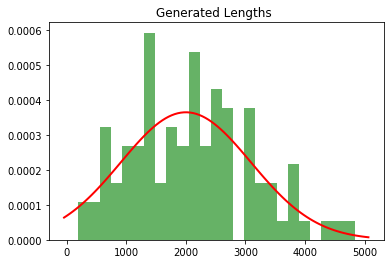

In [25]:
# See if Lab data follows a distrinution

mu, std = norm.fit(lab_lengths)

plt.hist(generated_lengths, bins=25, density=True, alpha=0.6, color='g')

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'r', linewidth=2)
title = "Generated Lengths "
plt.title(title)

plt.show()

In [26]:
created_data = []
for i in generated_lengths:

    X, Z = lab_model.sample(i)  # This generates a new sample, length of which is taken from the normal distribution

    created_data.append( np.concatenate(X).ravel().astype(int).astype(str).tolist() ) # list of nps flattened, and to ints

len(created_data)

100

In [27]:
# we have array of length 100, each of which contains events of varing lengths.

IDs = []    # This will be the length of the flattened array. will be like ID1, ID1, ID2 etc
targets = []

for i in range(len(created_data)):    
    targets.extend(created_data[i])

    for j in range(len(created_data[i])):
        IDs.append(f'ID{i}')


In [43]:
df = pd.DataFrame({'target':targets, 'turkId':IDs}) 
df.astype(object)
#df['target'] = df['target'].rename({'0' :'html', '1':'Slider-1', '2':'Sliders-2', '3':'Slider-3', '4':'Slider-4', '5':'Slider-5'})

df['target'] = df['target'].replace('0','html')
df['target'] = df['target'].replace('1','alloc-slider-1')
df['target'] = df['target'].replace('2','alloc-slider-2')
df['target'] = df['target'].replace('3','alloc-slider-3')
df['target'] = df['target'].replace('4','alloc-slider-4')
df['target'] = df['target'].replace('5','alloc-slider-5')

df

,target,turkId
0,html,ID0
1,html,ID0
2,html,ID0
3,html,ID0
4,html,ID0
...,...,...
209247,html,ID99
209248,html,ID99
209249,html,ID99
209250,html,ID99


In [44]:
df.to_csv('created_labs.csv')

https://imgur.com/a/FagaiQW
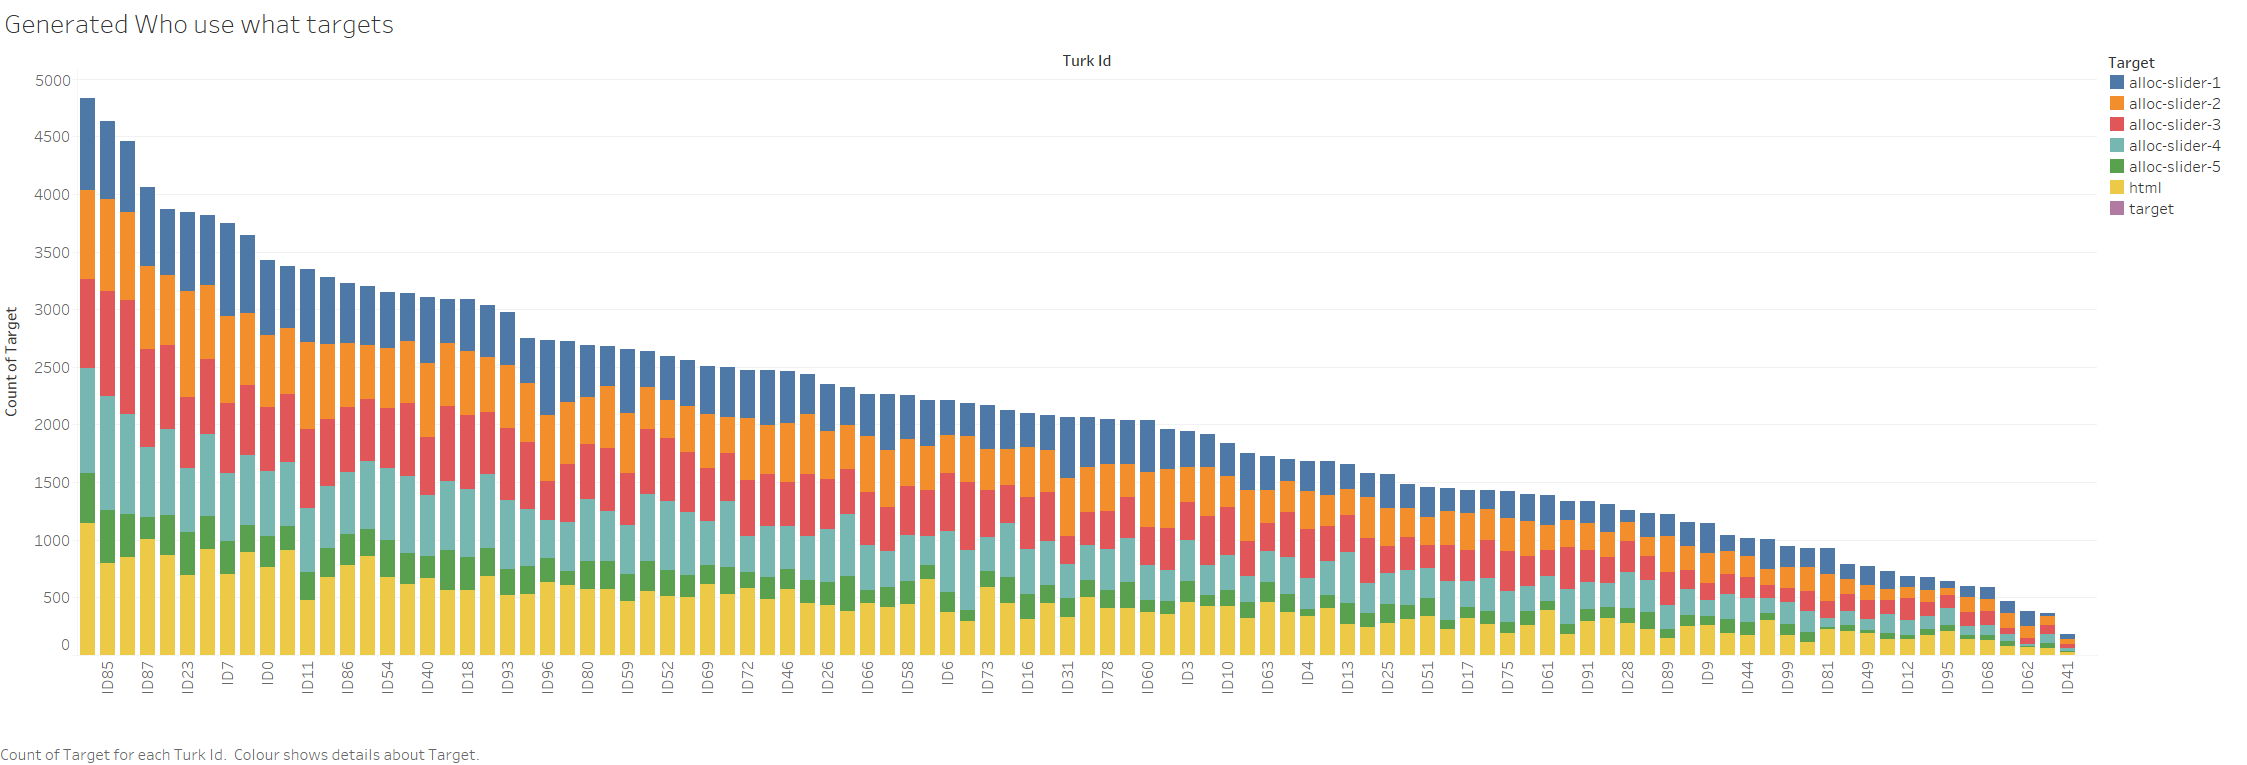

<?xml version='1.0' encoding='utf-8' ?>

<!-- build 20194.20.0323.1706                               -->
<workbook original-version='18.1' source-build='2019.4.5 (20194.20.0323.1706)' source-platform='win' version='18.1' xmlns:user='http://www.tableausoftware.com/xml/user'>
  <document-format-change-manifest>
    <IntuitiveSorting />
    <IntuitiveSorting_SP2 />
    <SheetIdentifierTracking ignorable='true' predowngraded='true' />
    <WindowsPersistSimpleIdentifiers />
  </document-format-change-manifest>
  <preferences>
    <preference name='ui.encoding.shelf.height' value='24' />
    <preference name='ui.shelf.height' value='26' />
  </preferences>
  <datasources>
    <datasource caption='Turk-Data-renamed' inline='true' name='federated.1ala6zs1tl92gp10b9p2o14dvb49' version='18.1'>
      <connection class='federated'>
        <named-connections>
          <named-connection caption='Turk-Data-renamed' name='textscan.1721piq014tmxv1h2xukc0ij364x'>
            <connection class='textscan' directory='C:/Users/DJSau/Masters-Project' filename='Turk-Data-renamed.csv' password='' server='' />
          </named-connection>
        </named-connections>
        <relation connection='textscan.1721piq014tmxv1h2xukc0ij364x' name='Turk-Data-renamed.csv' table='[Turk-Data-renamed#csv]' type='table'>
          <columns character-set='UTF-8' header='yes' locale='en_GB' separator=','>
            <column datatype='integer' name='F1' ordinal='0' />
            <column datatype='integer' name='button' ordinal='1' />
            <column datatype='string' name='event_type' ordinal='2' />
            <column datatype='string' name='target' ordinal='3' />
            <column datatype='real' name='time' ordinal='4' />
            <column datatype='real' name='x' ordinal='5' />
            <column datatype='real' name='y' ordinal='6' />
            <column datatype='integer' name='step' ordinal='7' />
            <column datatype='string' name='turkId' ordinal='8' />
          </columns>
        </relation>
        <metadata-records>
          <metadata-record class='capability'>
            <remote-name />
            <remote-type>0</remote-type>
            <parent-name>[Turk-Data-renamed.csv]</parent-name>
            <remote-alias />
            <aggregation>Count</aggregation>
            <contains-null>true</contains-null>
            <attributes>
              <attribute datatype='string' name='character-set'>&quot;UTF-8&quot;</attribute>
              <attribute datatype='string' name='collation'>&quot;en_GB&quot;</attribute>
              <attribute datatype='string' name='currency'>&quot;£&quot;</attribute>
              <attribute datatype='string' name='debit-close-char'>&quot;&quot;</attribute>
              <attribute datatype='string' name='debit-open-char'>&quot;&quot;</attribute>
              <attribute datatype='string' name='field-delimiter'>&quot;,&quot;</attribute>
              <attribute datatype='string' name='header-row'>&quot;true&quot;</attribute>
              <attribute datatype='string' name='locale'>&quot;en_GB&quot;</attribute>
              <attribute datatype='string' name='single-char'>&quot;&quot;</attribute>
            </attributes>
          </metadata-record>
          <metadata-record class='column'>
            <remote-name>F1</remote-name>
            <remote-type>20</remote-type>
            <local-name>[F1]</local-name>
            <parent-name>[Turk-Data-renamed.csv]</parent-name>
            <remote-alias>F1</remote-alias>
            <ordinal>0</ordinal>
            <local-type>integer</local-type>
            <aggregation>Sum</aggregation>
            <contains-null>true</contains-null>
          </metadata-record>
          <metadata-record class='column'>
            <remote-name>button</remote-name>
            <remote-type>20</remote-type>
            <local-name>[button]</local-name>
            <parent-name>[Turk-Data-renamed.csv]</parent-name>
            <remote-alias>button</remote-alias>
            <ordinal>1</ordinal>
            <local-type>integer</local-type>
            <aggregation>Sum</aggregation>
            <contains-null>true</contains-null>
          </metadata-record>
          <metadata-record class='column'>
            <remote-name>event_type</remote-name>
            <remote-type>129</remote-type>
            <local-name>[event_type]</local-name>
            <parent-name>[Turk-Data-renamed.csv]</parent-name>
            <remote-alias>event_type</remote-alias>
            <ordinal>2</ordinal>
            <local-type>string</local-type>
            <aggregation>Count</aggregation>
            <scale>1</scale>
            <width>1073741823</width>
            <contains-null>true</contains-null>
            <collation flag='0' name='LEN_RGB' />
          </metadata-record>
          <metadata-record class='column'>
            <remote-name>target</remote-name>
            <remote-type>129</remote-type>
            <local-name>[target]</local-name>
            <parent-name>[Turk-Data-renamed.csv]</parent-name>
            <remote-alias>target</remote-alias>
            <ordinal>3</ordinal>
            <local-type>string</local-type>
            <aggregation>Count</aggregation>
            <scale>1</scale>
            <width>1073741823</width>
            <contains-null>true</contains-null>
            <collation flag='0' name='LEN_RGB' />
          </metadata-record>
          <metadata-record class='column'>
            <remote-name>time</remote-name>
            <remote-type>5</remote-type>
            <local-name>[time]</local-name>
            <parent-name>[Turk-Data-renamed.csv]</parent-name>
            <remote-alias>time</remote-alias>
            <ordinal>4</ordinal>
            <local-type>real</local-type>
            <aggregation>Sum</aggregation>
            <contains-null>true</contains-null>
          </metadata-record>
          <metadata-record class='column'>
            <remote-name>x</remote-name>
            <remote-type>5</remote-type>
            <local-name>[x]</local-name>
            <parent-name>[Turk-Data-renamed.csv]</parent-name>
            <remote-alias>x</remote-alias>
            <ordinal>5</ordinal>
            <local-type>real</local-type>
            <aggregation>Sum</aggregation>
            <contains-null>true</contains-null>
          </metadata-record>
          <metadata-record class='column'>
            <remote-name>y</remote-name>
            <remote-type>5</remote-type>
            <local-name>[y]</local-name>
            <parent-name>[Turk-Data-renamed.csv]</parent-name>
            <remote-alias>y</remote-alias>
            <ordinal>6</ordinal>
            <local-type>real</local-type>
            <aggregation>Sum</aggregation>
            <contains-null>true</contains-null>
          </metadata-record>
          <metadata-record class='column'>
            <remote-name>step</remote-name>
            <remote-type>20</remote-type>
            <local-name>[step]</local-name>
            <parent-name>[Turk-Data-renamed.csv]</parent-name>
            <remote-alias>step</remote-alias>
            <ordinal>7</ordinal>
            <local-type>integer</local-type>
            <aggregation>Sum</aggregation>
            <contains-null>true</contains-null>
          </metadata-record>
          <metadata-record class='column'>
            <remote-name>turkId</remote-name>
            <remote-type>129</remote-type>
            <local-name>[turkId]</local-name>
            <parent-name>[Turk-Data-renamed.csv]</parent-name>
            <remote-alias>turkId</remote-alias>
            <ordinal>8</ordinal>
            <local-type>string</local-type>
            <aggregation>Count</aggregation>
            <scale>1</scale>
            <width>1073741823</width>
            <contains-null>true</contains-null>
            <collation flag='0' name='LEN_RGB' />
          </metadata-record>
        </metadata-records>
      </connection>
      <aliases enabled='yes' />
      <column datatype='integer' name='[Number of Records]' role='measure' type='quantitative' user:auto-column='numrec'>
        <calculation class='tableau' formula='1' />
      </column>
      <column caption='Button' datatype='integer' name='[button]' role='measure' type='quantitative' />
      <column caption='Event Type' datatype='string' name='[event_type]' role='dimension' type='nominal' />
      <column caption='Step' datatype='integer' name='[step]' role='measure' type='quantitative' />
      <column caption='Target' datatype='string' name='[target]' role='dimension' type='nominal' />
      <column caption='Time' datatype='real' name='[time]' role='measure' type='quantitative' />
      <column caption='Turk Id' datatype='string' name='[turkId]' role='dimension' type='nominal' />
      <column caption='X' datatype='real' name='[x]' role='measure' type='quantitative' />
      <column caption='Y' datatype='real' name='[y]' role='measure' type='quantitative' />
      <column-instance column='[target]' derivation='None' name='[none:target:nk]' pivot='key' type='nominal' />
      <layout dim-ordering='alphabetic' dim-percentage='0.428571' measure-ordering='alphabetic' measure-percentage='0.571429' show-structure='true' />
      <style>
        <style-rule element='mark'>
          <encoding attr='color' field='[none:target:nk]' type='palette'>
            <map to='#499894'>
              <bucket>&quot;html &gt; body&quot;</bucket>
            </map>
            <map to='#499894'>
              <bucket>&quot;html &gt; body &gt; main &gt; div\#content &gt; form\#portfolio-selection &gt; div.investment-test &gt; div.portfolio-interface.row &gt; div.portfolio-info.large-5.columns &gt; div\#portfolio-stats &gt; svg.chart &gt; g &gt; g.x.axis &gt; path.domain&quot;</bucket>
            </map>
            <map to='#499894'>
              <bucket>&quot;html &gt; body &gt; main &gt; div\#content &gt; form\#portfolio-selection &gt; div.investment-test &gt; div.portfolio-interface.row &gt; div.portfolio-info.large-5.columns &gt; div\#portfolio-stats.slice-sa &gt; svg.chart &gt; g &gt; g.y.axis &gt; g.tick &gt; text&quot;</bucket>
            </map>
            <map to='#499894'>
              <bucket>&quot;html &gt; body &gt; main &gt; div\#content &gt; form\#portfolio-selection &gt; div.investment-test &gt; div.portfolio-interface.row &gt; div.stock-selection.large-7.columns &gt; div.row &gt; div.large-12.columns.text-center&quot;</bucket>
            </map>
            <map to='#499894'>
              <bucket>&quot;html &gt; body &gt; main &gt; div\#content &gt; form\#portfolio-selection &gt; div.investment-test &gt; div.portfolio-interface.row &gt; div.stock-selection.large-7.columns &gt; div.stock-allocator.row &gt; div.large-4.columns&quot;</bucket>
            </map>
            <map to='#499894'>
              <bucket>&quot;html &gt; body &gt; main &gt; div\#content &gt; form\#portfolio-selection &gt; div.row &gt; div.large-12.columns.text-center&quot;</bucket>
            </map>
            <map to='#499894'>
              <bucket>&quot;save-portfolio-button&quot;</bucket>
            </map>
            <map to='#4e79a7'>
              <bucket>&quot;alloc-slider-1&quot;</bucket>
            </map>
            <map to='#4e79a7'>
              <bucket>&quot;html &gt; body &gt; main &gt; div\#content &gt; div\#investment-results &gt; table &gt; thead &gt; tr&quot;</bucket>
            </map>
            <map to='#4e79a7'>
              <bucket>&quot;html &gt; body &gt; main &gt; div\#content &gt; form\#portfolio-selection &gt; div.investment-test &gt; div.portfolio-interface.row &gt; div.portfolio-info.large-5.columns &gt; div\#portfolio-stats.local-sa &gt; svg.chart &gt; g &gt; g.y.axis &gt; g.tick &gt; text&quot;</bucket>
            </map>
            <map to='#4e79a7'>
              <bucket>&quot;html &gt; body &gt; main &gt; div\#content &gt; form\#portfolio-selection &gt; div.investment-test &gt; div.portfolio-interface.row &gt; div.stock-selection.large-7.columns &gt; div.row &gt; div.large-2.columns.expreturn-axis &gt; svg.chart &gt; g &gt; g.x.axis &gt; g.tick &gt; line&quot;</bucket>
            </map>
            <map to='#4e79a7'>
              <bucket>&quot;html &gt; body &gt; main &gt; div\#content &gt; form\#portfolio-selection &gt; div.investment-test &gt; div.portfolio-interface.row &gt; div.stock-selection.large-7.columns &gt; div.stock-allocator.row &gt; div.large-2.columns &gt; ul\#parsley-id-2404.parsley-errors-list.filled &gt; li.parsley-custom-error-message&quot;</bucket>
            </map>
            <map to='#4e79a7'>
              <bucket>&quot;html &gt; body &gt; main &gt; div\#content &gt; form\#portfolio-selection &gt; div.investment-test &gt; div.portfolio-interface.row &gt; div.stock-selection.large-7.columns &gt; div.stock-allocator.row.valign-middle &gt; div.large-2.columns &gt; label.stock-name &gt; i.color-key.qualitative-4&quot;</bucket>
            </map>
            <map to='#4e79a7'>
              <bucket>&quot;parsley-id-2404&quot;</bucket>
            </map>
            <map to='#4e79a7'>
              <bucket>&quot;slider-return-4&quot;</bucket>
            </map>
            <map to='#59a14f'>
              <bucket>&quot;alloc-slider-5&quot;</bucket>
            </map>
            <map to='#59a14f'>
              <bucket>&quot;html &gt; body &gt; main &gt; div\#content &gt; form\#portfolio-selection &gt; div.investment-test &gt; div.portfolio-interface.row &gt; div.portfolio-info.large-5.columns&quot;</bucket>
            </map>
            <map to='#59a14f'>
              <bucket>&quot;html &gt; body &gt; main &gt; div\#content &gt; form\#portfolio-selection &gt; div.investment-test &gt; div.portfolio-interface.row &gt; div.portfolio-info.large-5.columns &gt; div\#portfolio-stats.slice-sa &gt; svg.chart&quot;</bucket>
            </map>
            <map to='#59a14f'>
              <bucket>&quot;html &gt; body &gt; main &gt; div\#content &gt; form\#portfolio-selection &gt; div.investment-test &gt; div.portfolio-interface.row &gt; div.stock-selection.large-7.columns &gt; div.row &gt; div.large-2.columns.exprisk-axis &gt; svg.chart&quot;</bucket>
            </map>
            <map to='#59a14f'>
              <bucket>&quot;html &gt; body &gt; main &gt; div\#content &gt; form\#portfolio-selection &gt; div.investment-test &gt; div.portfolio-interface.row &gt; div.stock-selection.large-7.columns &gt; div.stock-allocator.row &gt; div.large-2.columns &gt; ul\#parsley-id-6784.parsley-errors-list.filled &gt; li.parsley-custom-error-message&quot;</bucket>
            </map>
            <map to='#59a14f'>
              <bucket>&quot;html &gt; body &gt; main &gt; div\#content &gt; form\#portfolio-selection &gt; div.investment-test &gt; div.portfolio-interface.row &gt; div.stock-selection.large-7.columns &gt; div.stock-allocator.row.valign-middle &gt; div.large-8.columns&quot;</bucket>
            </map>
            <map to='#59a14f'>
              <bucket>&quot;parsley-id-8286&quot;</bucket>
            </map>
            <map to='#59a14f'>
              <bucket>&quot;slider-risk-3&quot;</bucket>
            </map>
            <map to='#79706e'>
              <bucket>&quot;html &gt; body &gt; main &gt; div\#content &gt; div.panel.callout.radius&quot;</bucket>
            </map>
            <map to='#79706e'>
              <bucket>&quot;html &gt; body &gt; main &gt; div\#content &gt; form\#portfolio-selection &gt; div.investment-test &gt; div.portfolio-interface.row &gt; div.portfolio-info.large-5.columns &gt; div\#portfolio-stats &gt; svg.chart &gt; g &gt; g.y.axis &gt; path.domain&quot;</bucket>
            </map>
            <map to='#79706e'>
              <bucket>&quot;html &gt; body &gt; main &gt; div\#content &gt; form\#portfolio-selection &gt; div.investment-test &gt; div.portfolio-interface.row &gt; div.portfolio-info.large-5.columns &gt; div\#portfolio-stats.slice-sa &gt; svg.chart &gt; g &gt; path.slice.colorbrewer.qualitative-3&quot;</bucket>
            </map>
            <map to='#79706e'>
              <bucket>&quot;html &gt; body &gt; main &gt; div\#content &gt; form\#portfolio-selection &gt; div.investment-test &gt; div.portfolio-interface.row &gt; div.stock-selection.large-7.columns &gt; div.stock-allocator.header.row &gt; div.large-4.columns&quot;</bucket>
            </map>
            <map to='#79706e'>
              <bucket>&quot;html &gt; body &gt; main &gt; div\#content &gt; form\#portfolio-selection &gt; div.investment-test &gt; div.portfolio-interface.row &gt; div.stock-selection.large-7.columns &gt; div.stock-allocator.row.valign-middle &gt; div.large-2.columns &gt; div.gradient-bar&quot;</bucket>
            </map>
            <map to='#79706e'>
              <bucket>&quot;html &gt; body..hasGoogleVoiceExt &gt; main &gt; div\#content &gt; form\#portfolio-selection &gt; div.investment-test &gt; div.portfolio-interface.row &gt; div.stock-selection.large-7.columns&quot;</bucket>
            </map>
            <map to='#79706e'>
              <bucket>&quot;saved-port-3&quot;</bucket>
            </map>
            <map to='#86bcb6'>
              <bucket>&quot;html &gt; body &gt; div.contain-to-grid&quot;</bucket>
            </map>
            <map to='#86bcb6'>
              <bucket>&quot;html &gt; body &gt; main &gt; div\#content &gt; form\#portfolio-selection &gt; div.investment-test &gt; div.portfolio-interface.row &gt; div.portfolio-info.large-5.columns &gt; div\#portfolio-stats &gt; svg.chart &gt; g &gt; g.x.label &gt; text&quot;</bucket>
            </map>
            <map to='#86bcb6'>
              <bucket>&quot;html &gt; body &gt; main &gt; div\#content &gt; form\#portfolio-selection &gt; div.investment-test &gt; div.portfolio-interface.row &gt; div.portfolio-info.large-5.columns &gt; div\#portfolio-stats.slice-sa &gt; svg.chart &gt; g &gt; g.y.axis &gt; path.domain&quot;</bucket>
            </map>
            <map to='#86bcb6'>
              <bucket>&quot;html &gt; body &gt; main &gt; div\#content &gt; form\#portfolio-selection &gt; div.investment-test &gt; div.portfolio-interface.row &gt; div.stock-selection.large-7.columns &gt; div.stock-allocator.header.row&quot;</bucket>
            </map>
            <map to='#86bcb6'>
              <bucket>&quot;html &gt; body &gt; main &gt; div\#content &gt; form\#portfolio-selection &gt; div.investment-test &gt; div.portfolio-interface.row &gt; div.stock-selection.large-7.columns &gt; div.stock-allocator.row &gt; div.large-4.columns &gt; label.stock-name&quot;</bucket>
            </map>
            <map to='#86bcb6'>
              <bucket>&quot;html &gt; body &gt; main &gt; div\#content &gt; form\#portfolio-selection &gt; hr&quot;</bucket>
            </map>
            <map to='#86bcb6'>
              <bucket>&quot;saved-port-0&quot;</bucket>
            </map>
            <map to='#8cd17d'>
              <bucket>&quot;buy-button&quot;</bucket>
            </map>
            <map to='#8cd17d'>
              <bucket>&quot;html &gt; body &gt; main &gt; div\#content &gt; form\#portfolio-selection &gt; div.investment-test &gt; div.portfolio-interface.row &gt; div.portfolio-info.large-5.columns &gt; div\#portfolio-stats &gt; svg.chart&quot;</bucket>
            </map>
            <map to='#8cd17d'>
              <bucket>&quot;html &gt; body &gt; main &gt; div\#content &gt; form\#portfolio-selection &gt; div.investment-test &gt; div.portfolio-interface.row &gt; div.portfolio-info.large-5.columns &gt; div\#portfolio-stats.slice-sa &gt; svg.chart &gt; g &gt; g.x.axis &gt; g.tick &gt; text&quot;</bucket>
            </map>
            <map to='#8cd17d'>
              <bucket>&quot;html &gt; body &gt; main &gt; div\#content &gt; form\#portfolio-selection &gt; div.investment-test &gt; div.portfolio-interface.row &gt; div.stock-selection.large-7.columns &gt; div.row &gt; div.large-2.columns.exprisk-axis &gt; svg.chart &gt; g &gt; g.x.axis &gt; g.tick &gt; text&quot;</bucket>
            </map>
            <map to='#8cd17d'>
              <bucket>&quot;html &gt; body &gt; main &gt; div\#content &gt; form\#portfolio-selection &gt; div.investment-test &gt; div.portfolio-interface.row &gt; div.stock-selection.large-7.columns &gt; div.stock-allocator.row &gt; div.large-2.columns &gt; ul\#parsley-id-7113.parsley-errors-list.filled &gt; li.parsley-custom-error-message&quot;</bucket>
            </map>
            <map to='#8cd17d'>
              <bucket>&quot;html &gt; body &gt; main &gt; div\#content &gt; form\#portfolio-selection &gt; div.investment-test &gt; div.portfolio-interface.row &gt; div.stock-selection.large-7.columns &gt; div.stock-allocator.row.valign-middle &gt; div.large-8.columns &gt; input.alloc-slider&quot;</bucket>
            </map>
            <map to='#8cd17d'>
              <bucket>&quot;portfolio-selection&quot;</bucket>
            </map>
            <map to='#8cd17d'>
              <bucket>&quot;slider-risk-4&quot;</bucket>
            </map>
            <map to='#9d7660'>
              <bucket>&quot;html &gt; body &gt; main &gt; div\#content &gt; div\#investment-results &gt; table &gt; tbody &gt; tr&quot;</bucket>
            </map>
            <map to='#9d7660'>
              <bucket>&quot;html &gt; body &gt; main &gt; div\#content &gt; form\#portfolio-selection &gt; div.investment-test &gt; div.portfolio-interface.row &gt; div.portfolio-info.large-5.columns &gt; div\#portfolio-stats.local-sa &gt; svg.chart &gt; g &gt; g.x.label &gt; text&quot;</bucket>
            </map>
            <map to='#9d7660'>
              <bucket>&quot;html &gt; body &gt; main &gt; div\#content &gt; form\#portfolio-selection &gt; div.investment-test &gt; div.portfolio-interface.row &gt; div.stock-selection.large-7.columns &gt; div.row &gt; div.large-2.columns.expreturn-axis&quot;</bucket>
            </map>
            <map to='#9d7660'>
              <bucket>&quot;html &gt; body &gt; main &gt; div\#content &gt; form\#portfolio-selection &gt; div.investment-test &gt; div.portfolio-interface.row &gt; div.stock-selection.large-7.columns &gt; div.stock-allocator.row &gt; div.large-2.columns &gt; ul\#parsley-id-1942.parsley-errors-list.filled &gt; li.parsley-custom-error-message&quot;</bucket>
            </map>
            <map to='#9d7660'>
              <bucket>&quot;html &gt; body &gt; main &gt; div\#content &gt; form\#portfolio-selection &gt; div.investment-test &gt; div.portfolio-interface.row &gt; div.stock-selection.large-7.columns &gt; div.stock-allocator.row.valign-middle &gt; div.large-2.columns &gt; label.stock-name &gt; i.color-key.qualitative-2&quot;</bucket>
            </map>
            <map to='#9d7660'>
              <bucket>&quot;investment-results&quot;</bucket>
            </map>
            <map to='#9d7660'>
              <bucket>&quot;slider-return-2&quot;</bucket>
            </map>
            <map to='#a0cbe8'>
              <bucket>&quot;alloc-slider-2&quot;</bucket>
            </map>
            <map to='#a0cbe8'>
              <bucket>&quot;html &gt; body &gt; main &gt; div\#content &gt; div\#investment-results &gt; table &gt; thead &gt; tr &gt; th&quot;</bucket>
            </map>
            <map to='#a0cbe8'>
              <bucket>&quot;html &gt; body &gt; main &gt; div\#content &gt; form\#portfolio-selection &gt; div.investment-test &gt; div.portfolio-interface.row &gt; div.portfolio-info.large-5.columns &gt; div\#portfolio-stats.local-sa &gt; svg.chart &gt; g &gt; g.y.axis &gt; path.domain&quot;</bucket>
            </map>
            <map to='#a0cbe8'>
              <bucket>&quot;html &gt; body &gt; main &gt; div\#content &gt; form\#portfolio-selection &gt; div.investment-test &gt; div.portfolio-interface.row &gt; div.stock-selection.large-7.columns &gt; div.row &gt; div.large-2.columns.expreturn-axis &gt; svg.chart &gt; g &gt; g.x.axis &gt; g.tick &gt; text&quot;</bucket>
            </map>
            <map to='#a0cbe8'>
              <bucket>&quot;html &gt; body &gt; main &gt; div\#content &gt; form\#portfolio-selection &gt; div.investment-test &gt; div.portfolio-interface.row &gt; div.stock-selection.large-7.columns &gt; div.stock-allocator.row &gt; div.large-2.columns &gt; ul\#parsley-id-2586.parsley-errors-list.filled &gt; li.parsley-custom-error-message&quot;</bucket>
            </map>
            <map to='#a0cbe8'>
              <bucket>&quot;html &gt; body &gt; main &gt; div\#content &gt; form\#portfolio-selection &gt; div.investment-test &gt; div.portfolio-interface.row &gt; div.stock-selection.large-7.columns &gt; div.stock-allocator.row.valign-middle &gt; div.large-2.columns &gt; label.stock-name &gt; i.color-key.qualitative-5&quot;</bucket>
            </map>
            <map to='#a0cbe8'>
              <bucket>&quot;parsley-id-2586&quot;</bucket>
            </map>
            <map to='#a0cbe8'>
              <bucket>&quot;slider-risk-0&quot;</bucket>
            </map>
            <map to='#b07aa1'>
              <bucket>&quot;html &gt; body &gt; main &gt; div\#content &gt; div\#investment-results &gt; table&quot;</bucket>
            </map>
            <map to='#b07aa1'>
              <bucket>&quot;html &gt; body &gt; main &gt; div\#content &gt; form\#portfolio-selection &gt; div.investment-test &gt; div.portfolio-interface.row &gt; div.portfolio-info.large-5.columns &gt; div\#portfolio-stats.local-sa &gt; svg.chart &gt; g &gt; g.x.axis &gt; g.tick &gt; text&quot;</bucket>
            </map>
            <map to='#b07aa1'>
              <bucket>&quot;html &gt; body &gt; main &gt; div\#content &gt; form\#portfolio-selection &gt; div.investment-test &gt; div.portfolio-interface.row &gt; div.stock-selection.large-7.columns &gt; div.row&quot;</bucket>
            </map>
            <map to='#b07aa1'>
              <bucket>&quot;html &gt; body &gt; main &gt; div\#content &gt; form\#portfolio-selection &gt; div.investment-test &gt; div.portfolio-interface.row &gt; div.stock-selection.large-7.columns &gt; div.stock-allocator.row &gt; div.large-2.columns &gt; span.remaining-cash&quot;</bucket>
            </map>
            <map to='#b07aa1'>
              <bucket>&quot;html &gt; body &gt; main &gt; div\#content &gt; form\#portfolio-selection &gt; div.investment-test &gt; div.portfolio-interface.row &gt; div.stock-selection.large-7.columns &gt; div.stock-allocator.row.valign-middle &gt; div.large-2.columns &gt; label.stock-name&quot;</bucket>
            </map>
            <map to='#b07aa1'>
              <bucket>&quot;html &gt; body..hasGoogleVoiceExt &gt; main &gt; div\#content &gt; form\#portfolio-selection &gt; div.investment-test &gt; div.portfolio-interface.row &gt; div.stock-selection.large-7.columns &gt; div.stock-allocator.row.valign-middle &gt; div.large-4.columns&quot;</bucket>
            </map>
            <map to='#b07aa1'>
              <bucket>&quot;slider-return-0&quot;</bucket>
            </map>
            <map to='#b6992d'>
              <bucket>&quot;content&quot;</bucket>
            </map>
            <map to='#b6992d'>
              <bucket>&quot;html &gt; body &gt; main &gt; div\#content &gt; form\#portfolio-selection &gt; div.investment-test &gt; div.portfolio-interface.row &gt; div.portfolio-info.large-5.columns &gt; div\#portfolio-stats &gt; svg.chart &gt; g &gt; g.x.axis &gt; g.tick &gt; line&quot;</bucket>
            </map>
            <map to='#b6992d'>
              <bucket>&quot;html &gt; body &gt; main &gt; div\#content &gt; form\#portfolio-selection &gt; div.investment-test &gt; div.portfolio-interface.row &gt; div.portfolio-info.large-5.columns &gt; div\#portfolio-stats.slice-sa &gt; svg.chart &gt; g &gt; g.x.axis &gt; path.domain&quot;</bucket>
            </map>
            <map to='#b6992d'>
              <bucket>&quot;html &gt; body &gt; main &gt; div\#content &gt; form\#portfolio-selection &gt; div.investment-test &gt; div.portfolio-interface.row &gt; div.stock-selection.large-7.columns &gt; div.row &gt; div.large-2.columns.exprisk-axis &gt; svg.chart &gt; g &gt; g.x.axis &gt; path.domain&quot;</bucket>
            </map>
            <map to='#b6992d'>
              <bucket>&quot;html &gt; body &gt; main &gt; div\#content &gt; form\#portfolio-selection &gt; div.investment-test &gt; div.portfolio-interface.row &gt; div.stock-selection.large-7.columns &gt; div.stock-allocator.row &gt; div.large-2.columns &gt; ul\#parsley-id-8124.parsley-errors-list.filled &gt; li.parsley-custom-error-message&quot;</bucket>
            </map>
            <map to='#b6992d'>
              <bucket>&quot;html &gt; body &gt; main &gt; div\#content &gt; form\#portfolio-selection &gt; div.investment-test &gt; div.portfolio-interface.row &gt; div.stock-selection.large-7.columns &gt; div.stock-allocator.row.valign-middle &gt; div.large-8.columns &gt; input.alloc-slider.parsley-success&quot;</bucket>
            </map>
            <map to='#b6992d'>
              <bucket>&quot;portfolio-stats&quot;</bucket>
            </map>
            <map to='#bab0ac'>
              <bucket>&quot;html &gt; body &gt; main &gt; div\#content &gt; div.panel.callout.radius &gt; h3&quot;</bucket>
            </map>
            <map to='#bab0ac'>
              <bucket>&quot;html &gt; body &gt; main &gt; div\#content &gt; form\#portfolio-selection &gt; div.investment-test &gt; div.portfolio-interface.row &gt; div.portfolio-info.large-5.columns &gt; div\#portfolio-stats &gt; svg.chart &gt; g &gt; g.y.label &gt; text&quot;</bucket>
            </map>
            <map to='#bab0ac'>
              <bucket>&quot;html &gt; body &gt; main &gt; div\#content &gt; form\#portfolio-selection &gt; div.investment-test &gt; div.portfolio-interface.row &gt; div.portfolio-info.large-5.columns &gt; div\#portfolio-stats.slice-sa &gt; svg.chart &gt; g &gt; path.slice.colorbrewer.qualitative-4&quot;</bucket>
            </map>
            <map to='#bab0ac'>
              <bucket>&quot;html &gt; body &gt; main &gt; div\#content &gt; form\#portfolio-selection &gt; div.investment-test &gt; div.portfolio-interface.row &gt; div.stock-selection.large-7.columns &gt; div.stock-allocator.header.row &gt; div.large-4.columns &gt; span&quot;</bucket>
            </map>
            <map to='#bab0ac'>
              <bucket>&quot;html &gt; body &gt; main &gt; div\#content &gt; form\#portfolio-selection &gt; div.investment-test &gt; div.portfolio-interface.row &gt; div.stock-selection.large-7.columns &gt; div.stock-allocator.row.valign-middle &gt; div.large-2.columns &gt; div.gradient-bar &gt; svg.chart&quot;</bucket>
            </map>
            <map to='#bab0ac'>
              <bucket>&quot;html &gt; body..hasGoogleVoiceExt &gt; main &gt; div\#content &gt; form\#portfolio-selection &gt; div.investment-test &gt; div.portfolio-interface.row &gt; div.stock-selection.large-7.columns &gt; div.stock-allocator.row.valign-middle&quot;</bucket>
            </map>
            <map to='#bab0ac'>
              <bucket>&quot;saved-port-4&quot;</bucket>
            </map>
            <map to='#d37295'>
              <bucket>&quot;html &gt; body &gt; main &gt; div\#content &gt; div.panel.callout.radius &gt; p&quot;</bucket>
            </map>
            <map to='#d37295'>
              <bucket>&quot;html &gt; body &gt; main &gt; div\#content &gt; form\#portfolio-selection &gt; div.investment-test &gt; div.portfolio-interface.row &gt; div.portfolio-info.large-5.columns &gt; div\#portfolio-stats.local-sa &gt; svg.chart&quot;</bucket>
            </map>
            <map to='#d37295'>
              <bucket>&quot;html &gt; body &gt; main &gt; div\#content &gt; form\#portfolio-selection &gt; div.investment-test &gt; div.portfolio-interface.row &gt; div.portfolio-info.large-5.columns &gt; div\#portfolio-stats.slice-sa &gt; svg.chart &gt; g &gt; path.slice.colorbrewer.qualitative-5&quot;</bucket>
            </map>
            <map to='#d37295'>
              <bucket>&quot;html &gt; body &gt; main &gt; div\#content &gt; form\#portfolio-selection &gt; div.investment-test &gt; div.portfolio-interface.row &gt; div.stock-selection.large-7.columns &gt; div.stock-allocator.row&quot;</bucket>
            </map>
            <map to='#d37295'>
              <bucket>&quot;html &gt; body &gt; main &gt; div\#content &gt; form\#portfolio-selection &gt; div.investment-test &gt; div.portfolio-interface.row &gt; div.stock-selection.large-7.columns &gt; div.stock-allocator.row.valign-middle &gt; div.large-2.columns &gt; div.gradient-bar &gt; svg.chart &gt; g &gt; g.x.axis &gt; path.domain&quot;</bucket>
            </map>
            <map to='#d37295'>
              <bucket>&quot;html &gt; body..hasGoogleVoiceExt &gt; main &gt; div\#content &gt; form\#portfolio-selection &gt; div.investment-test &gt; div.portfolio-interface.row &gt; div.stock-selection.large-7.columns &gt; div.stock-allocator.row.valign-middle &gt; div.large-2.columns&quot;</bucket>
            </map>
            <map to='#d37295'>
              <bucket>&quot;saved-port-5&quot;</bucket>
            </map>
            <map to='#d4a6c8'>
              <bucket>&quot;html &gt; body &gt; main &gt; div\#content &gt; div\#investment-results &gt; table &gt; tbody&quot;</bucket>
            </map>
            <map to='#d4a6c8'>
              <bucket>&quot;html &gt; body &gt; main &gt; div\#content &gt; form\#portfolio-selection &gt; div.investment-test &gt; div.portfolio-interface.row &gt; div.portfolio-info.large-5.columns &gt; div\#portfolio-stats.local-sa &gt; svg.chart &gt; g &gt; g.x.axis &gt; path.domain&quot;</bucket>
            </map>
            <map to='#d4a6c8'>
              <bucket>&quot;html &gt; body &gt; main &gt; div\#content &gt; form\#portfolio-selection &gt; div.investment-test &gt; div.portfolio-interface.row &gt; div.stock-selection.large-7.columns &gt; div.row &gt; div.large-2.columns&quot;</bucket>
            </map>
            <map to='#d4a6c8'>
              <bucket>&quot;html &gt; body &gt; main &gt; div\#content &gt; form\#portfolio-selection &gt; div.investment-test &gt; div.portfolio-interface.row &gt; div.stock-selection.large-7.columns &gt; div.stock-allocator.row &gt; div.large-2.columns &gt; ul\#parsley-id-0147.parsley-errors-list.filled &gt; li.parsley-custom-error-message&quot;</bucket>
            </map>
            <map to='#d4a6c8'>
              <bucket>&quot;html &gt; body &gt; main &gt; div\#content &gt; form\#portfolio-selection &gt; div.investment-test &gt; div.portfolio-interface.row &gt; div.stock-selection.large-7.columns &gt; div.stock-allocator.row.valign-middle &gt; div.large-2.columns &gt; label.stock-name &gt; i.color-key.qualitative-1&quot;</bucket>
            </map>
            <map to='#d4a6c8'>
              <bucket>&quot;html &gt; body..hasGoogleVoiceExt &gt; main &gt; div\#content &gt; form\#portfolio-selection &gt; div.investment-test &gt; div.portfolio-interface.row &gt; div.stock-selection.large-7.columns &gt; hr&quot;</bucket>
            </map>
            <map to='#d4a6c8'>
              <bucket>&quot;slider-return-1&quot;</bucket>
            </map>
            <map to='#d7b5a6'>
              <bucket>&quot;html &gt; body &gt; main &gt; div\#content &gt; div\#investment-results &gt; table &gt; tbody &gt; tr &gt; td&quot;</bucket>
            </map>
            <map to='#d7b5a6'>
              <bucket>&quot;html &gt; body &gt; main &gt; div\#content &gt; form\#portfolio-selection &gt; div.investment-test &gt; div.portfolio-interface.row &gt; div.portfolio-info.large-5.columns &gt; div\#portfolio-stats.local-sa &gt; svg.chart &gt; g &gt; g.y.axis &gt; g.tick &gt; line&quot;</bucket>
            </map>
            <map to='#d7b5a6'>
              <bucket>&quot;html &gt; body &gt; main &gt; div\#content &gt; form\#portfolio-selection &gt; div.investment-test &gt; div.portfolio-interface.row &gt; div.stock-selection.large-7.columns &gt; div.row &gt; div.large-2.columns.expreturn-axis &gt; svg.chart&quot;</bucket>
            </map>
            <map to='#d7b5a6'>
              <bucket>&quot;html &gt; body &gt; main &gt; div\#content &gt; form\#portfolio-selection &gt; div.investment-test &gt; div.portfolio-interface.row &gt; div.stock-selection.large-7.columns &gt; div.stock-allocator.row &gt; div.large-2.columns &gt; ul\#parsley-id-1947.parsley-errors-list.filled &gt; li.parsley-custom-error-message&quot;</bucket>
            </map>
            <map to='#d7b5a6'>
              <bucket>&quot;html &gt; body &gt; main &gt; div\#content &gt; form\#portfolio-selection &gt; div.investment-test &gt; div.portfolio-interface.row &gt; div.stock-selection.large-7.columns &gt; div.stock-allocator.row.valign-middle &gt; div.large-2.columns &gt; label.stock-name &gt; i.color-key.qualitative-3&quot;</bucket>
            </map>
            <map to='#d7b5a6'>
              <bucket>&quot;parsley-id-0147&quot;</bucket>
            </map>
            <map to='#d7b5a6'>
              <bucket>&quot;slider-return-3&quot;</bucket>
            </map>
            <map to='#e15759'>
              <bucket>&quot;html &gt; body &gt; div.contain-to-grid &gt; nav.top-bar&quot;</bucket>
            </map>
            <map to='#e15759'>
              <bucket>&quot;html &gt; body &gt; main &gt; div\#content &gt; form\#portfolio-selection &gt; div.investment-test &gt; div.portfolio-interface.row &gt; div.portfolio-info.large-5.columns &gt; div\#portfolio-stats &gt; svg.chart &gt; g &gt; g.y.axis &gt; g.tick &gt; line&quot;</bucket>
            </map>
            <map to='#e15759'>
              <bucket>&quot;html &gt; body &gt; main &gt; div\#content &gt; form\#portfolio-selection &gt; div.investment-test &gt; div.portfolio-interface.row &gt; div.portfolio-info.large-5.columns &gt; div\#portfolio-stats.slice-sa &gt; svg.chart &gt; g &gt; g.y.label &gt; text&quot;</bucket>
            </map>
            <map to='#e15759'>
              <bucket>&quot;html &gt; body &gt; main &gt; div\#content &gt; form\#portfolio-selection &gt; div.investment-test &gt; div.portfolio-interface.row &gt; div.stock-selection.large-7.columns &gt; div.stock-allocator.header.row &gt; div.large-2.columns&quot;</bucket>
            </map>
            <map to='#e15759'>
              <bucket>&quot;html &gt; body &gt; main &gt; div\#content &gt; form\#portfolio-selection &gt; div.investment-test &gt; div.portfolio-interface.row &gt; div.stock-selection.large-7.columns &gt; div.stock-allocator.row.valign-middle&quot;</bucket>
            </map>
            <map to='#e15759'>
              <bucket>&quot;html &gt; body &gt; main &gt; div\#content &gt; hr&quot;</bucket>
            </map>
            <map to='#e15759'>
              <bucket>&quot;saved-port-1&quot;</bucket>
            </map>
            <map to='#f1ce63'>
              <bucket>&quot;html&quot;</bucket>
            </map>
            <map to='#f1ce63'>
              <bucket>&quot;html &gt; body &gt; main &gt; div\#content &gt; form\#portfolio-selection &gt; div.investment-test &gt; div.portfolio-interface.row &gt; div.portfolio-info.large-5.columns &gt; div\#portfolio-stats &gt; svg.chart &gt; g &gt; g.x.axis &gt; g.tick &gt; text&quot;</bucket>
            </map>
            <map to='#f1ce63'>
              <bucket>&quot;html &gt; body &gt; main &gt; div\#content &gt; form\#portfolio-selection &gt; div.investment-test &gt; div.portfolio-interface.row &gt; div.portfolio-info.large-5.columns &gt; div\#portfolio-stats.slice-sa &gt; svg.chart &gt; g &gt; g.x.label &gt; text&quot;</bucket>
            </map>
            <map to='#f1ce63'>
              <bucket>&quot;html &gt; body &gt; main &gt; div\#content &gt; form\#portfolio-selection &gt; div.investment-test &gt; div.portfolio-interface.row &gt; div.stock-selection.large-7.columns &gt; div.row &gt; div.large-6.columns&quot;</bucket>
            </map>
            <map to='#f1ce63'>
              <bucket>&quot;html &gt; body &gt; main &gt; div\#content &gt; form\#portfolio-selection &gt; div.investment-test &gt; div.portfolio-interface.row &gt; div.stock-selection.large-7.columns &gt; div.stock-allocator.row &gt; div.large-2.columns &gt; ul\#parsley-id-8286.parsley-errors-list.filled &gt; li.parsley-custom-error-message&quot;</bucket>
            </map>
            <map to='#f1ce63'>
              <bucket>&quot;html &gt; body &gt; main &gt; div\#content &gt; form\#portfolio-selection &gt; div.investment-test &gt; div.portfolio-interface.row &gt; div.stock-selection.large-7.columns &gt; hr&quot;</bucket>
            </map>
            <map to='#f1ce63'>
              <bucket>&quot;risk-return&quot;</bucket>
            </map>
            <map to='#f28e2b'>
              <bucket>&quot;alloc-slider-3&quot;</bucket>
            </map>
            <map to='#f28e2b'>
              <bucket>&quot;html &gt; body &gt; main &gt; div\#content &gt; form\#portfolio-selection &gt; div.investment-test&quot;</bucket>
            </map>
            <map to='#f28e2b'>
              <bucket>&quot;html &gt; body &gt; main &gt; div\#content &gt; form\#portfolio-selection &gt; div.investment-test &gt; div.portfolio-interface.row &gt; div.portfolio-info.large-5.columns &gt; div\#portfolio-stats.local-sa &gt; svg.chart &gt; g &gt; g.y.label &gt; text&quot;</bucket>
            </map>
            <map to='#f28e2b'>
              <bucket>&quot;html &gt; body &gt; main &gt; div\#content &gt; form\#portfolio-selection &gt; div.investment-test &gt; div.portfolio-interface.row &gt; div.stock-selection.large-7.columns &gt; div.row &gt; div.large-2.columns.expreturn-axis &gt; svg.chart &gt; g &gt; g.x.axis &gt; path.domain&quot;</bucket>
            </map>
            <map to='#f28e2b'>
              <bucket>&quot;html &gt; body &gt; main &gt; div\#content &gt; form\#portfolio-selection &gt; div.investment-test &gt; div.portfolio-interface.row &gt; div.stock-selection.large-7.columns &gt; div.stock-allocator.row &gt; div.large-2.columns &gt; ul\#parsley-id-2750.parsley-errors-list.filled &gt; li.parsley-custom-error-message&quot;</bucket>
            </map>
            <map to='#f28e2b'>
              <bucket>&quot;html &gt; body &gt; main &gt; div\#content &gt; form\#portfolio-selection &gt; div.investment-test &gt; div.portfolio-interface.row &gt; div.stock-selection.large-7.columns &gt; div.stock-allocator.row.valign-middle &gt; div.large-2.columns &gt; span&quot;</bucket>
            </map>
            <map to='#f28e2b'>
              <bucket>&quot;parsley-id-3644&quot;</bucket>
            </map>
            <map to='#f28e2b'>
              <bucket>&quot;slider-risk-1&quot;</bucket>
            </map>
            <map to='#fabfd2'>
              <bucket>&quot;html &gt; body &gt; main &gt; div\#content &gt; div\#investment-results &gt; p&quot;</bucket>
            </map>
            <map to='#fabfd2'>
              <bucket>&quot;html &gt; body &gt; main &gt; div\#content &gt; form\#portfolio-selection &gt; div.investment-test &gt; div.portfolio-interface.row &gt; div.portfolio-info.large-5.columns &gt; div\#portfolio-stats.local-sa &gt; svg.chart &gt; g &gt; g.x.axis &gt; g.tick &gt; line&quot;</bucket>
            </map>
            <map to='#fabfd2'>
              <bucket>&quot;html &gt; body &gt; main &gt; div\#content &gt; form\#portfolio-selection &gt; div.investment-test &gt; div.portfolio-interface.row &gt; div.stock-selection.large-7.columns&quot;</bucket>
            </map>
            <map to='#fabfd2'>
              <bucket>&quot;html &gt; body &gt; main &gt; div\#content &gt; form\#portfolio-selection &gt; div.investment-test &gt; div.portfolio-interface.row &gt; div.stock-selection.large-7.columns &gt; div.stock-allocator.row &gt; div.large-2.columns&quot;</bucket>
            </map>
            <map to='#fabfd2'>
              <bucket>&quot;html &gt; body &gt; main &gt; div\#content &gt; form\#portfolio-selection &gt; div.investment-test &gt; div.portfolio-interface.row &gt; div.stock-selection.large-7.columns &gt; div.stock-allocator.row.valign-middle &gt; div.large-2.columns &gt; div.gradient-bar &gt; svg.chart &gt; g &gt; rect.bar&quot;</bucket>
            </map>
            <map to='#fabfd2'>
              <bucket>&quot;html &gt; body..hasGoogleVoiceExt &gt; main &gt; div\#content &gt; form\#portfolio-selection &gt; div.investment-test &gt; div.portfolio-interface.row &gt; div.stock-selection.large-7.columns &gt; div.stock-allocator.row.valign-middle &gt; div.large-2.columns &gt; label.stock-name&quot;</bucket>
            </map>
            <map to='#fabfd2'>
              <bucket>&quot;saved-port-6&quot;</bucket>
            </map>
            <map to='#ff9d9a'>
              <bucket>&quot;html &gt; body &gt; div.contain-to-grid &gt; nav.top-bar &gt; ul.title-area &gt; li.name &gt; h1 &gt; a&quot;</bucket>
            </map>
            <map to='#ff9d9a'>
              <bucket>&quot;html &gt; body &gt; main &gt; div\#content &gt; form\#portfolio-selection &gt; div.investment-test &gt; div.portfolio-interface.row &gt; div.portfolio-info.large-5.columns &gt; div\#portfolio-stats &gt; svg.chart &gt; g &gt; g.y.axis &gt; g.tick &gt; text&quot;</bucket>
            </map>
            <map to='#ff9d9a'>
              <bucket>&quot;html &gt; body &gt; main &gt; div\#content &gt; form\#portfolio-selection &gt; div.investment-test &gt; div.portfolio-interface.row &gt; div.portfolio-info.large-5.columns &gt; div\#portfolio-stats.slice-sa &gt; svg.chart &gt; g &gt; path.slice.colorbrewer.qualitative-2&quot;</bucket>
            </map>
            <map to='#ff9d9a'>
              <bucket>&quot;html &gt; body &gt; main &gt; div\#content &gt; form\#portfolio-selection &gt; div.investment-test &gt; div.portfolio-interface.row &gt; div.stock-selection.large-7.columns &gt; div.stock-allocator.header.row &gt; div.large-2.columns &gt; span&quot;</bucket>
            </map>
            <map to='#ff9d9a'>
              <bucket>&quot;html &gt; body &gt; main &gt; div\#content &gt; form\#portfolio-selection &gt; div.investment-test &gt; div.portfolio-interface.row &gt; div.stock-selection.large-7.columns &gt; div.stock-allocator.row.valign-middle &gt; div.large-2.columns&quot;</bucket>
            </map>
            <map to='#ff9d9a'>
              <bucket>&quot;html &gt; body..hasGoogleVoiceExt &gt; main &gt; div\#content &gt; form\#portfolio-selection &gt; div.investment-test &gt; div.portfolio-interface.row &gt; div.portfolio-info.large-5.columns &gt; div\#portfolio-stats &gt; svg.chart&quot;</bucket>
            </map>
            <map to='#ff9d9a'>
              <bucket>&quot;saved-port-2&quot;</bucket>
            </map>
            <map to='#ffbe7d'>
              <bucket>&quot;alloc-slider-4&quot;</bucket>
            </map>
            <map to='#ffbe7d'>
              <bucket>&quot;html &gt; body &gt; main &gt; div\#content &gt; form\#portfolio-selection &gt; div.investment-test &gt; div.portfolio-interface.row&quot;</bucket>
            </map>
            <map to='#ffbe7d'>
              <bucket>&quot;html &gt; body &gt; main &gt; div\#content &gt; form\#portfolio-selection &gt; div.investment-test &gt; div.portfolio-interface.row &gt; div.portfolio-info.large-5.columns &gt; div\#portfolio-stats.local-sa &gt; svg.chart &gt; g &gt; line.gradient.colorbrewer.qualitative-5&quot;</bucket>
            </map>
            <map to='#ffbe7d'>
              <bucket>&quot;html &gt; body &gt; main &gt; div\#content &gt; form\#portfolio-selection &gt; div.investment-test &gt; div.portfolio-interface.row &gt; div.stock-selection.large-7.columns &gt; div.row &gt; div.large-2.columns.exprisk-axis&quot;</bucket>
            </map>
            <map to='#ffbe7d'>
              <bucket>&quot;html &gt; body &gt; main &gt; div\#content &gt; form\#portfolio-selection &gt; div.investment-test &gt; div.portfolio-interface.row &gt; div.stock-selection.large-7.columns &gt; div.stock-allocator.row &gt; div.large-2.columns &gt; ul\#parsley-id-3644.parsley-errors-list.filled &gt; li.parsley-custom-error-message&quot;</bucket>
            </map>
            <map to='#ffbe7d'>
              <bucket>&quot;html &gt; body &gt; main &gt; div\#content &gt; form\#portfolio-selection &gt; div.investment-test &gt; div.portfolio-interface.row &gt; div.stock-selection.large-7.columns &gt; div.stock-allocator.row.valign-middle &gt; div.large-4.columns&quot;</bucket>
            </map>
            <map to='#ffbe7d'>
              <bucket>&quot;parsley-id-8124&quot;</bucket>
            </map>
            <map to='#ffbe7d'>
              <bucket>&quot;slider-risk-2&quot;</bucket>
            </map>
          </encoding>
        </style-rule>
      </style>
      <semantic-values>
        <semantic-value key='[Country].[Name]' value='&quot;United Kingdom&quot;' />
      </semantic-values>
      <date-options start-of-week='monday' />
    </datasource>
  </datasources>
  <worksheets>
    <worksheet name='First turk breakdown'>
      <table>
        <view>
          <datasources>
            <datasource caption='Turk-Data-renamed' name='federated.1ala6zs1tl92gp10b9p2o14dvb49' />
          </datasources>
          <datasource-dependencies datasource='federated.1ala6zs1tl92gp10b9p2o14dvb49'>
            <column-instance column='[target]' derivation='Count' name='[cnt:target:qk]' pivot='key' type='quantitative' />
            <column-instance column='[target]' derivation='None' name='[none:target:nk]' pivot='key' type='nominal' />
            <column-instance column='[turkId]' derivation='None' name='[none:turkId:nk]' pivot='key' type='nominal' />
            <column caption='Target' datatype='string' name='[target]' role='dimension' type='nominal' />
            <column caption='Turk Id' datatype='string' name='[turkId]' role='dimension' type='nominal' />
          </datasource-dependencies>
          <filter class='categorical' column='[federated.1ala6zs1tl92gp10b9p2o14dvb49].[none:turkId:nk]'>
            <groupfilter function='member' level='[none:turkId:nk]' member='&quot;A35YFAFWP33C70&quot;' user:ui-domain='relevant' user:ui-enumeration='inclusive' user:ui-marker='enumerate' />
          </filter>
          <shelf-sorts>
            <shelf-sort-v2 dimension-to-sort='[federated.1ala6zs1tl92gp10b9p2o14dvb49].[none:turkId:nk]' direction='DESC' is-on-innermost-dimension='true' measure-to-sort-by='[federated.1ala6zs1tl92gp10b9p2o14dvb49].[cnt:target:qk]' shelf='columns' />
          </shelf-sorts>
          <slices>
            <column>[federated.1ala6zs1tl92gp10b9p2o14dvb49].[none:turkId:nk]</column>
          </slices>
          <aggregation value='true' />
        </view>
        <style />
        <panes>
          <pane selection-relaxation-option='selection-relaxation-allow'>
            <view>
              <breakdown value='auto' />
            </view>
            <mark class='Automatic' />
            <encodings>
              <color column='[federated.1ala6zs1tl92gp10b9p2o14dvb49].[none:target:nk]' />
              <lod column='[federated.1ala6zs1tl92gp10b9p2o14dvb49].[none:target:nk]' />
            </encodings>
          </pane>
        </panes>
        <rows>[federated.1ala6zs1tl92gp10b9p2o14dvb49].[cnt:target:qk]</rows>
        <cols>[federated.1ala6zs1tl92gp10b9p2o14dvb49].[none:turkId:nk]</cols>
      </table>
      <simple-id uuid='{CE35A452-74FC-4861-B656-7ADB29221958}' />
    </worksheet>
    <worksheet name='What targets people selected'>
      <table>
        <view>
          <datasources>
            <datasource caption='Turk-Data-renamed' name='federated.1ala6zs1tl92gp10b9p2o14dvb49' />
          </datasources>
          <datasource-dependencies datasource='federated.1ala6zs1tl92gp10b9p2o14dvb49'>
            <column-instance column='[target]' derivation='CountD' name='[ctd:target:qk]' pivot='key' type='quantitative' />
            <column-instance column='[target]' derivation='None' name='[none:target:nk]' pivot='key' type='nominal' />
            <column-instance column='[turkId]' derivation='None' name='[none:turkId:nk]' pivot='key' type='nominal' />
            <column caption='Target' datatype='string' name='[target]' role='dimension' type='nominal' />
            <column caption='Turk Id' datatype='string' name='[turkId]' role='dimension' type='nominal' />
          </datasource-dependencies>
          <shelf-sorts>
            <shelf-sort-v2 dimension-to-sort='[federated.1ala6zs1tl92gp10b9p2o14dvb49].[none:turkId:nk]' direction='DESC' is-on-innermost-dimension='true' measure-to-sort-by='[federated.1ala6zs1tl92gp10b9p2o14dvb49].[ctd:target:qk]' shelf='columns' />
          </shelf-sorts>
          <aggregation value='true' />
        </view>
        <style />
        <panes>
          <pane selection-relaxation-option='selection-relaxation-allow'>
            <view>
              <breakdown value='auto' />
            </view>
            <mark class='Automatic' />
            <encodings>
              <color column='[federated.1ala6zs1tl92gp10b9p2o14dvb49].[none:target:nk]' />
              <lod column='[federated.1ala6zs1tl92gp10b9p2o14dvb49].[none:target:nk]' />
            </encodings>
          </pane>
        </panes>
        <rows>[federated.1ala6zs1tl92gp10b9p2o14dvb49].[ctd:target:qk]</rows>
        <cols>[federated.1ala6zs1tl92gp10b9p2o14dvb49].[none:turkId:nk]</cols>
      </table>
      <simple-id uuid='{533ECF92-FC7C-403B-9B1F-063308CBED27}' />
    </worksheet>
    <worksheet name='Who contributes to mouse events'>
      <table>
        <view>
          <datasources>
            <datasource caption='Turk-Data-renamed' name='federated.1ala6zs1tl92gp10b9p2o14dvb49' />
          </datasources>
          <datasource-dependencies datasource='federated.1ala6zs1tl92gp10b9p2o14dvb49'>
            <column-instance column='[target]' derivation='Count' name='[cnt:target:qk]' pivot='key' type='quantitative' />
            <column-instance column='[target]' derivation='None' name='[none:target:nk]' pivot='key' type='nominal' />
            <column-instance column='[turkId]' derivation='None' name='[none:turkId:nk]' pivot='key' type='nominal' />
            <column caption='Target' datatype='string' name='[target]' role='dimension' type='nominal' />
            <column caption='Turk Id' datatype='string' name='[turkId]' role='dimension' type='nominal' />
          </datasource-dependencies>
          <shelf-sorts>
            <shelf-sort-v2 dimension-to-sort='[federated.1ala6zs1tl92gp10b9p2o14dvb49].[none:target:nk]' direction='DESC' is-on-innermost-dimension='true' measure-to-sort-by='[federated.1ala6zs1tl92gp10b9p2o14dvb49].[cnt:target:qk]' shelf='columns' />
          </shelf-sorts>
          <aggregation value='true' />
        </view>
        <style />
        <panes>
          <pane selection-relaxation-option='selection-relaxation-allow'>
            <view>
              <breakdown value='auto' />
            </view>
            <mark class='Automatic' />
            <encodings>
              <color column='[federated.1ala6zs1tl92gp10b9p2o14dvb49].[none:turkId:nk]' />
            </encodings>
          </pane>
        </panes>
        <rows>[federated.1ala6zs1tl92gp10b9p2o14dvb49].[cnt:target:qk]</rows>
        <cols>[federated.1ala6zs1tl92gp10b9p2o14dvb49].[none:target:nk]</cols>
      </table>
      <simple-id uuid='{E3364D16-6845-45F8-ACAF-6086625C6F27}' />
    </worksheet>
    <worksheet name='Who used what targets'>
      <table>
        <view>
          <datasources>
            <datasource caption='Turk-Data-renamed' name='federated.1ala6zs1tl92gp10b9p2o14dvb49' />
          </datasources>
          <datasource-dependencies datasource='federated.1ala6zs1tl92gp10b9p2o14dvb49'>
            <column-instance column='[target]' derivation='Count' name='[cnt:target:qk]' pivot='key' type='quantitative' />
            <column-instance column='[target]' derivation='None' name='[none:target:nk]' pivot='key' type='nominal' />
            <column-instance column='[turkId]' derivation='None' name='[none:turkId:nk]' pivot='key' type='nominal' />
            <column caption='Target' datatype='string' name='[target]' role='dimension' type='nominal' />
            <column caption='Turk Id' datatype='string' name='[turkId]' role='dimension' type='nominal' />
          </datasource-dependencies>
          <shelf-sorts>
            <shelf-sort-v2 dimension-to-sort='[federated.1ala6zs1tl92gp10b9p2o14dvb49].[none:turkId:nk]' direction='DESC' is-on-innermost-dimension='true' measure-to-sort-by='[federated.1ala6zs1tl92gp10b9p2o14dvb49].[cnt:target:qk]' shelf='columns' />
          </shelf-sorts>
          <aggregation value='true' />
        </view>
        <style />
        <panes>
          <pane selection-relaxation-option='selection-relaxation-allow'>
            <view>
              <breakdown value='auto' />
            </view>
            <mark class='Automatic' />
            <encodings>
              <color column='[federated.1ala6zs1tl92gp10b9p2o14dvb49].[none:target:nk]' />
              <lod column='[federated.1ala6zs1tl92gp10b9p2o14dvb49].[none:target:nk]' />
            </encodings>
          </pane>
        </panes>
        <rows>[federated.1ala6zs1tl92gp10b9p2o14dvb49].[cnt:target:qk]</rows>
        <cols>[federated.1ala6zs1tl92gp10b9p2o14dvb49].[none:turkId:nk]</cols>
      </table>
      <simple-id uuid='{D77A5FB2-4215-4E64-8DF8-0051BDFB21B3}' />
    </worksheet>
    <worksheet name='distinct targets'>
      <table>
        <view>
          <datasources>
            <datasource caption='Turk-Data-renamed' name='federated.1ala6zs1tl92gp10b9p2o14dvb49' />
          </datasources>
          <datasource-dependencies datasource='federated.1ala6zs1tl92gp10b9p2o14dvb49'>
            <column-instance column='[target]' derivation='CountD' name='[ctd:target:qk]' pivot='key' type='quantitative' />
            <column-instance column='[target]' derivation='None' name='[none:target:nk]' pivot='key' type='nominal' />
            <column-instance column='[turkId]' derivation='None' name='[none:turkId:nk]' pivot='key' type='nominal' />
            <column caption='Target' datatype='string' name='[target]' role='dimension' type='nominal' />
            <column caption='Turk Id' datatype='string' name='[turkId]' role='dimension' type='nominal' />
          </datasource-dependencies>
          <shelf-sorts>
            <shelf-sort-v2 dimension-to-sort='[federated.1ala6zs1tl92gp10b9p2o14dvb49].[none:target:nk]' direction='ASC' is-on-innermost-dimension='true' measure-to-sort-by='[federated.1ala6zs1tl92gp10b9p2o14dvb49].[ctd:target:qk]' shelf='columns' />
          </shelf-sorts>
          <aggregation value='true' />
        </view>
        <style />
        <panes>
          <pane selection-relaxation-option='selection-relaxation-allow'>
            <view>
              <breakdown value='auto' />
            </view>
            <mark class='Automatic' />
            <encodings>
              <color column='[federated.1ala6zs1tl92gp10b9p2o14dvb49].[none:turkId:nk]' />
            </encodings>
          </pane>
        </panes>
        <rows>[federated.1ala6zs1tl92gp10b9p2o14dvb49].[ctd:target:qk]</rows>
        <cols>[federated.1ala6zs1tl92gp10b9p2o14dvb49].[none:target:nk]</cols>
      </table>
      <simple-id uuid='{CAE5E118-685D-4045-91EB-083A9054A3E2}' />
    </worksheet>
  </worksheets>
  <windows saved-dpi-scale-factor='1.25' source-height='37'>
    <window class='worksheet' name='Who contributes to mouse events'>
      <cards>
        <edge name='left'>
          <strip size='160'>
            <card type='pages' />
            <card type='filters' />
            <card type='marks' />
          </strip>
        </edge>
        <edge name='top'>
          <strip size='2147483647'>
            <card type='columns' />
          </strip>
          <strip size='2147483647'>
            <card type='rows' />
          </strip>
          <strip size='2147483647'>
            <card type='title' />
          </strip>
        </edge>
        <edge name='right'>
          <strip size='160'>
            <card pane-specification-id='0' param='[federated.1ala6zs1tl92gp10b9p2o14dvb49].[none:turkId:nk]' type='color' />
          </strip>
        </edge>
      </cards>
      <viewpoint>
        <highlight>
          <color-one-way>
            <field>[federated.1ala6zs1tl92gp10b9p2o14dvb49].[none:turkId:nk]</field>
          </color-one-way>
        </highlight>
      </viewpoint>
      <simple-id uuid='{4BE9335C-D821-4B3E-84B3-AD8D9A24E67A}' />
    </window>
    <window class='worksheet' name='distinct targets'>
      <cards>
        <edge name='left'>
          <strip size='160'>
            <card type='pages' />
            <card type='filters' />
            <card type='marks' />
          </strip>
        </edge>
        <edge name='top'>
          <strip size='2147483647'>
            <card type='columns' />
          </strip>
          <strip size='2147483647'>
            <card type='rows' />
          </strip>
          <strip size='2147483647'>
            <card type='title' />
          </strip>
        </edge>
        <edge name='right'>
          <strip size='160'>
            <card pane-specification-id='0' param='[federated.1ala6zs1tl92gp10b9p2o14dvb49].[none:turkId:nk]' type='color' />
          </strip>
        </edge>
      </cards>
      <viewpoint>
        <highlight>
          <color-one-way>
            <field>[federated.1ala6zs1tl92gp10b9p2o14dvb49].[none:turkId:nk]</field>
          </color-one-way>
        </highlight>
      </viewpoint>
      <simple-id uuid='{0764B966-50A1-4962-95F8-8B73C1D5D951}' />
    </window>
    <window class='worksheet' name='First turk breakdown'>
      <cards>
        <edge name='left'>
          <strip size='160'>
            <card type='pages' />
            <card type='filters' />
            <card type='marks' />
          </strip>
        </edge>
        <edge name='top'>
          <strip size='2147483647'>
            <card type='columns' />
          </strip>
          <strip size='2147483647'>
            <card type='rows' />
          </strip>
          <strip size='2147483647'>
            <card type='title' />
          </strip>
        </edge>
        <edge name='right'>
          <strip size='160'>
            <card pane-specification-id='0' param='[federated.1ala6zs1tl92gp10b9p2o14dvb49].[none:target:nk]' type='color' />
          </strip>
        </edge>
      </cards>
      <viewpoint>
        <highlight>
          <color-one-way>
            <field>[federated.1ala6zs1tl92gp10b9p2o14dvb49].[cnt:target:qk]</field>
            <field>[federated.1ala6zs1tl92gp10b9p2o14dvb49].[none:target:nk]</field>
            <field>[federated.1ala6zs1tl92gp10b9p2o14dvb49].[none:turkId:nk]</field>
          </color-one-way>
        </highlight>
      </viewpoint>
      <simple-id uuid='{DDC06579-B2E2-48C7-8DB5-BF33AFDD8949}' />
    </window>
    <window class='worksheet' name='Who used what targets'>
      <cards>
        <edge name='left'>
          <strip size='160'>
            <card type='pages' />
            <card type='filters' />
            <card type='marks' />
          </strip>
        </edge>
        <edge name='top'>
          <strip size='2147483647'>
            <card type='columns' />
          </strip>
          <strip size='2147483647'>
            <card type='rows' />
          </strip>
          <strip size='2147483647'>
            <card type='title' />
          </strip>
        </edge>
        <edge name='right'>
          <strip size='160'>
            <card pane-specification-id='0' param='[federated.1ala6zs1tl92gp10b9p2o14dvb49].[none:target:nk]' type='color' />
          </strip>
        </edge>
      </cards>
      <viewpoint>
        <highlight>
          <color-one-way>
            <field>[federated.1ala6zs1tl92gp10b9p2o14dvb49].[cnt:target:qk]</field>
            <field>[federated.1ala6zs1tl92gp10b9p2o14dvb49].[none:target:nk]</field>
            <field>[federated.1ala6zs1tl92gp10b9p2o14dvb49].[none:turkId:nk]</field>
          </color-one-way>
        </highlight>
      </viewpoint>
      <simple-id uuid='{FBE926F4-8809-4B25-84E7-A58D43A99592}' />
    </window>
    <window class='worksheet' maximized='true' name='What targets people selected'>
      <cards>
        <edge name='left'>
          <strip size='160'>
            <card type='pages' />
            <card type='filters' />
            <card type='marks' />
          </strip>
        </edge>
        <edge name='top'>
          <strip size='2147483647'>
            <card type='columns' />
          </strip>
          <strip size='2147483647'>
            <card type='rows' />
          </strip>
          <strip size='2147483647'>
            <card type='title' />
          </strip>
        </edge>
        <edge name='right'>
          <strip size='160'>
            <card pane-specification-id='0' param='[federated.1ala6zs1tl92gp10b9p2o14dvb49].[none:target:nk]' type='color' />
          </strip>
        </edge>
      </cards>
      <viewpoint>
        <highlight>
          <color-one-way>
            <field>[federated.1ala6zs1tl92gp10b9p2o14dvb49].[cnt:target:qk]</field>
            <field>[federated.1ala6zs1tl92gp10b9p2o14dvb49].[none:target:nk]</field>
            <field>[federated.1ala6zs1tl92gp10b9p2o14dvb49].[none:turkId:nk]</field>
          </color-one-way>
        </highlight>
      </viewpoint>
      <simple-id uuid='{23F78B92-B267-41C0-9015-B2592243310C}' />
    </window>
  </windows>
  <thumbnails>
    <thumbnail height='192' name='First turk breakdown' width='132'>
      iVBORw0KGgoAAAANSUhEUgAAAIQAAADACAYAAADFjcvdAAAACXBIWXMAABJ0AAASdAHeZh94
      AAAJM0lEQVR4nO3df2zN9x7H8efuuXX7Y37Ur4ur1GabH8PE2S6CIS6pEYZs96qldSUXuROS
      uYS6Edm1BRlrJPNj3KvbZUbckLrcydxJbTcuFcXVIW61frXzq5zeUyetk3P/aEvf/XH67fxo
      v7weSRM9/Zyv74mn8/m2Sb/vZ0KhUAiRcj9p6BOQxkVBiKEgxFAQYigIMRSEGApCDAUhhoIQ
      Q0GIoSDEUBBiKIiHJC8tEa/XW8tHIml5D3b8xV4viU4PkpdGYp3r80hL9OJdnGEe/emPP0Wp
      rHPSZjKTyv6cl5bIxNVdWZm5hCENe1r1pncIMRTE45SxuPr2UeWxsq1nMRmAL+NDxg+u6a3/
      LjlpSQwYNYsdOXcd/uU+TqTNZdKwAXi9XgaPX8Tu/OqrFERjlbeZWSnf0fb1Nxna9VnzJV/G
      +8xcCzPWrGLic852/bzNs5i+9hrDVuziX5mZfLNlPsPaVF+na4hG6Ra7PjvF29t2Mrp92T/R
      4vKv3M1JY9b8Q/Rftp0khzHAUbZtPEX75C383tu27KHopsTU8HQF0Shdp2fiR/diqHBm9UT6
      r4Znx67i0yHNnB8u7z9k+aBX9xfrXKoto1HqStca/ve/NGsH/1z5Bj/7xwa+cHztUD8KwmWa
      DXmPlJEFrJ65iqNOm2jdhnbA1Ws36lyqIB6n1m1pTz5n/+sDSvCdO0ha+ol6HqQZQ+YtZhxf
      svD9DHxOnhLzOuPeaMaR9ctIv1gClHA1cz+H9F1GA+vxDn9M/DkZ84bjHTyGOZ9doffAHvU/
      TsxAFnzwNvx9PkvSb1L3G0UMQ1LW8odeZ1n+5kC8g99i+alYXqjhu4xn9HsZUpneIcRQEGIo
      CDEURD0VFxc39Ck8UgpCDAUhhoIQQ0GIoSDEUBBiKAgxFIQYCkIMBSGGghBDQYihIMRQEGIo
      CDEUhBgKQgwFIYaCEENBiKEgxFAQYigIMRSEGO67g0zpVY5s3ciXh3MpKvEQ1bYno387jZFd
      IssXZLFx+hoOV33eazNZN+2Ve5/6z+1l01/2cOJ6CU1a92b01GQSusY8rlfReIXc5O7l0J6l
      80Kr9mSHbpaEQqFQSeh/F7NCB05cvb8mf09oyYpvQrfCHSf/q9DSd5eG0s/fCd0N3Q3dOZ8e
      Wvru0tBX+XWfgt/vf7DX0Mi5assIZO7kQPxUZiV0JzYCIIKYjn14vVelGx0UXKGwQzua13qU
      INlf76PZ5NmMiY/Eg4fI+DHMntyMfV9nE3zkr6Jxc1EQtzl08CK/HNANT5hVBfmXeb5LfJgV
      Fzh9Kp5+fe32ENO3H/GnTnPhIZypm7noGiKfK5c709K3lw0f7ud4bhElnija9hxFUnICFdv/
      tR8KOLlzNtM3AXiIahFHv7FTmDAojrIltykMtKRHZJXDR8bSMpDN7cf4ihojFwUR4E7xObJO
      v8xbv/sTU1tF4ikt5Pv0NaSuiWLJ3KG0BHolf8K65IrnlOK/lMX29ctJLVrA/IQOZe8usbG0
      qHb8FsTG2kdq+03voqKih/eyGhkXBQHwIr+aNIjnKvaMiFi6T5jCiEV/JfPaUEZWu2dSBDEd
      XyV5jo9li/aRnZBML4DCQm4B7czaWxQWQvtKj0RHR1c7g+LiYpo2bfrQXlFj46IgfkFc5/Pk
      XYB+XSo/3onOXfzk3gnz1JataB3MLb9gbE5s5E0KA0DlbSNQyM3I2DAXo86MW7j1AY/weO36
      4NfmcxddVLahW08PB7+r+p3AeXLOxdKiOYAfv7+Gp968wfXoqPJ//05065nL0WN2of/YUXJ7
      dqPTozl513BRENBpxCRezvozq/fnEggCpYV8/7cv+PdLo+jfHCCH7SlL+PzbHG4EgkCQQP4R
      Nn28k2DCcLoB4KHHiJH4tqSyOzdAkCCB3N2kbvExckSPsN/BPA1cd1vCoO8k6Ru2sv/MdUo8
      UcQNeIcZk/vR2lPx9bMc2LaDvcdzKSqBJk3j6TN+CkmD4oiodJwf+5PK4uLiGq8tKrh9y3Bd
      EA3tSQ/CVVuGPHoKQgwFIYaCEENBiKEgxFAQYigIMRSEGApCDAUhhoIQQ0GIoSDEUBBiKAgx
      FIQYCkIMBSGGghBDQYihIMRQEGIoCDEUhBgKQgwFIYaCEENBiKEgxFAQYigIMRSEGApCDAUh
      hoIQQ0GI4aI72Zarc4CKs1sOaoBKzdwVRPAKe1ekcqZvMikruxMbUYr/UjaZhUXcu09xwT5S
      U4/R+70VzIiPoDR3Lys/SsWTspCRFTe3drLmKeWqLaPuASpOhqNogEo4LgrCyQAVJ8NRNEAl
      HBdtGU4GqDgZjqIBKuG4KAhnA1QcDUfRAJV7qr4WFwUBjgaoOBmOogEq91R9LS66hrg/QMUq
      G6BSfAfMcJTKzHAUJ2ueXi4KwskAFSfDUTRAJRwXBeFkgIqT4SgaoBKO6+Zl1DVABR7tTyqf
      9HkZrguioT3pQbhqy5BHT0GIoSDEUBBiKAgxFIQYCkIMBSGGghBDQYihIMRQEGIoCDEUhBgK
      QgwFIYaCEENBiKEgxFAQYigIMRSEGApCDAUhhoIQQ0GIoSDEUBBiKAgxFIQYCkIMBSGGghBD
      QYihIMRQEGIoCDFcdmvjLDZOX8Phqg+/NpN1016pxxoNUKmNu4IoyOfyC79h+dyhtd+C2NEa
      DVCpjbu2jIIrFHZoF/5+1HWu0QCVcFwVREH+ZZ7vEv+AazRAJRxXbRnXfijg5M7ZTN8E4CGq
      RRz9xk5hwqA4Yhyv0QCVcFwVRK/kT1iXXPFZKf5LWWxfv5zUogXMT+iAx+EaDVC5r+prcdWW
      YUUQ0/FVkueMx5O+j+z6rCkfoGKVDVCpLDo6utoHlA0dqe3Dbaqev4uDKNeyFa2DwfAXg2aN
      BqiE46Ig/Pj9NTx88wbXo6PKp3Y6WaMBKuG4KIgctqcs4fNvc7gRCAJBAvlH2PTxToIJw+nm
      eI0GqITjqnkZQd9ZDmzbwd7juRSVQJOm8fQZP4WkQXFE1GMNaIBKBQ1QeUBPehAu2jLkcVAQ
      YigIMRSEGApCDAUhhoIQQ0GIoSDEUBBiKAgxFIQYCkIMBSGGghBDQYihIMRQEGIoCDEUhBgK
      QgwFIYaCEENBiKEgxFAQYigIMRSEGK66pZAbTJgwrKFP4YH8HxLG3+Fk/wp3AAAAAElFTkSu
      QmCC
    </thumbnail>
    <thumbnail height='192' name='What targets people selected' width='192'>
      iVBORw0KGgoAAAANSUhEUgAAAMAAAADACAYAAABS3GwHAAAACXBIWXMAABJ0AAASdAHeZh94
      AAAgAElEQVR4nO19Z5Qc13nlrdzVOUzOeQAMBhlEJAgGkGCUZJE0ZQUqOMq2LMtaeb0S19Ku
      tfbqyJLo9ZLrY1k2ZckKVqQpkWLOIAEQBEBkAjODQZicOndX2h/d01WgoK8a8gCc4bx7Ds8p
      Tt9+eF39btf73pc4y7IsMDAsQnAcx/Fv9yQYGN5OMAEwLGowATAsajABMCxqMAEwLGowATAs
      aohv9wQYbJhaFqOjo8hqZvEvHDyBKKqiAfAc/d6JkTF4ozGo0lt+00wdU+PjEIKVCHqE0p/1
      XBLjcQ01lZG5/RALDOwJMI9gZON4Y98uPPH9B/Hpz34Vv3jxRRw6NQSjDE/Ng1+4H4fOZ3/5
      hdwovvmlz+Hnh+MX/Hn0xPO472vfmaOZL1ywJ8A8ghSowo7bfxPTTRIOz8Tx3g+8HxUAxvoP
      Y0ysxbLGKMb7D2NUrEVHII1Dg3m01ws4NJBCzrAAWMhPn8Ubg2ksXdYJr/jWx4aJ+FAf9h3u
      x+TwSWQN9vWzJ8ACwIlnf4if7u4DABx/7kf4ye4+pAf34p+/8e/4/ve/i2cP9iGvWzCyM3jk
      29/EiSntolum9Oib+Kd/eAhjlgpVEcFCAJgAFjQSyQSW3fwRfPYjt0HJjOAH3/hbHFE34j1b
      lsEj/LICzhx5AUOBdbhrx1asXNICVbjIoIsMTAALGKHKVnQ1VwIApGAVtm7ZgOTgCUzm9Ivy
      9XwGoqxcySnOezABLACoIT8SI+dxfvAkjvaPlv7OcTw4rvBLz/ECapdfh2tqRvD9n+1B5iKW
      c1XzcpiDu7G//zwGB04jqV2xjzBvIXz+85///Ns9CYa3gOMgBSrR0VoDCUCkthHG0DEcHzXQ
      07sU9c1taKoMQg5UoL3I4XgeLd2dWL2qC1NDQ4jWtcCvFH7fOElFY3s3Wpqb0VHJ4eVdB+Cp
      7UR3ewuWtNa9rR/17cQXvvCFL3AsHJphsWJehUNblgWmRYYrjXklAF2/uPHGwHC5MG8EwMDw
      doAJgGFRgwmAYVGDCYBhUYMJgGFRgwmAYVGDCYBhUYMJgGFRgwmAYVGDCYBhUYMJgGFRgwmA
      YVGDCYBhUYMJgGFRY97VxTg/nsDBUyMkpzbmx8qOGgDA0EQCB07S/JqYH6uKfAYGJ+adAE6c
      mcCDP91LcratbCoJ4M2zk678rb2NTAAMFwXbAjEsajABMCxqMAEwLGrMOxsgEglg5cpOktPU
      FC1dh8Pu/ObGxV0BmeFXY94JwB/wor29geRURz0236+68yOsGhrDxcG2QAyLGkwADIsaTAAM
      ixrzzgYQjTR8mXMkR8lHAISK/Iw73xcBEJ6jGTK8kzDvBFA38TJu2vsXJEfsvgVY8iUAQO3k
      K7hp72doftdNwNK/nbM5MrxzcBkEkMbxfceQLNb5jDUtQUulD0YujhPHT0GXQmhrb4FPZrsv
      hrcfc78Kk6ex59gEFFWFqqqQBB6WlsJrzzyNkbyAzPibePbVYzBYIVyGeYA5fwJkh4cQXr4O
      y5fZzqfUeD/GpRrctLYXvNaCxx7dhYSxBOFfauLGwHBlMecCyJgKxl5/BP96gIOkRrD5hhvg
      19PweWLgwIGTFFTDwoxlImRxMAwDQKE6tGma4HgFYqiW/Dc4NQRNK7Q3sQTZne8Jl/hTyRz6
      hqZJfsTvQVttqNyPzLCAMecCiHRtwUe6tsAydUwN7sbTzx3Flg0S8Cu2PLMtfmZ7AwiBCsit
      m8h/w6zshFl8H+8rg19h84+eHsNXvv8qyd+4rB7/5R56TIZ3BuZYABZ03YQgCOB4EdG6GvAv
      D0EU65DKDsOCBUvLYgQc2ov9rQSh0KpwVggC726W8BwHXixOXSiDz/MlvsC7t0bkOA6iOO8O
      yBguA+b4W9Zwet8uDORVxPwCRvpPoHb9TsRCCiqNA3h29+vwZkZgVbQgcJE2ngwMVxpzLAAZ
      bWs3Qu7vw2RKQ+va69HRGAbPcVi7/XqcPNkPPbIUK1ubwHNMAAxvP+b8Oc8JCho7lqLxLX/n
      lQC6elbM9T/HwPCfwrzb6O7JxPHN80dJzjo5hnuL169l4vgXF/4aKYKPFK9ramPYuZM2cNsq
      vKXr146fd805Xt1Zgz98z1Ukh2F+Yt4JIGuZmDDoDs4J026mlyuHb9h8URDg9XoINqDIkj2+
      ZmBsOk3yZ1I58nWG+QsWj8CwqMEEwLCoMe+2QBw48C6+AN7Z35srg+94nbMMiDq9peFN+4SK
      5ziIIu07cPouDMNETjdc+BwUad7d+kWJefctRCMhrF6xnOQ0h+0c4EjInd8Sss+k6sZfwB27
      Pk3yxY4dQNdXAQC1dRW4445tJL8xbOcc7zl+Hn/9rRdJ/voldfjch+gxGa4M2BaIYVGDCYBh
      UYMJgGFRgwmAYVFj3hnBamIKtaf2kZxIQwBoKvKTZfDrfUBz4VrwRuBpXEPyuYq20nU4cQJr
      TnyT5AcblgMdHy7wwwGsWbOE5LfXBkvX/UNT+I+XT5D8lpow7tjSDQAYGJ7Gwy8dJ/kf3rkK
      QV/BMP+XR/cjnqYddffetBIhP+0cfKdi3glAzqUQGRskOd7g+KXxAzafV3zgYy30JAKV9ntz
      I2gZeYyki/48gA8X+KqClhY6QacqJJeux6fTeOq1fpK/tqu2JICJGXf+PdctLwngpTfOYHQ6
      RfLv3t6DkJ+kvGPBtkAMixpMAAyLGkwADIsa884GiIRCWLF0GclRq2xPsH/Sj9Y9bQQbCKK6
      dP1GNonvjbxJ8nukKN5XvBb9lfB2bif5XE1v6bpi5iC2v/6/Sb7avA7oLBT/ilWEsX37WpLf
      6gjPjsZCrnyPx7YxNm5ajnhGJ9iAR1281bPnnQBEUUTAT1tkomJ/YYImwpvwEmxAztgLImXq
      6MtnSH6Fbp+acIIEwRcl2AAUX+lS0pOIJulTGiFj9yuTJBHRaJBgA/6APf9y+M7Yp1DID1E1
      6fnwizc7j22BGBY1mAAYFjWYABgWNeadDTCWk3FgnO7pVSf6sap4nRB4nPDQRly1JKGieC3L
      MqIRulS632/v6ccNDcdSUyQ/FkhhafGal1WIkbeWBLgQgt92tKm5cTSOPkuPb9UBuLbIn0Dj
      6DP0+Ma7ABTsqLqJl5DN0I4w0bwDQAAA8OqRs8jkaaP5qiX18HoKaaO7j55DOkenpK5fUgdf
      0TDfc+wcUlkXfncdfKpMcuYK804AxxN+/H1fC8nZzleUBDAiS3g6QhuFvT4Vs+c0Pq8Xrc1N
      JL8qVFG67stn8MDkGZK/zldXEoCghqE2ryf5iNlN/cKpN7H++F+TdCF3NbC+IIBQ6pQrX9m6
      HbMCWNH3AKz4eZq/eRvgLQjgGz/fj+HJJMl/4FO3lATwz4/ux/nxBMn/+0/eXBLAQ48ewJmx
      OMn/u0/svGICYFsghkUNJgCGRQ0mAIZFjXlnA6i5HGpHx0hOuMp2JPl9PrS1tpD86irb6FTS
      cVQNHib5odpgKXza41FQV1tD8p1G9Vk9hxenh0h+nacKsxnBvBKAXNtD8vlos32t+F35nGDv
      n+WqLlg++lCBE21+Z2cjYkk6fFqRHfyORkSqszRfsfkdnY0IVtGOSMVzZfb/wDwUgCeXQ/Uk
      feoSStqnGl6fD80uRm1FhW3UKpkEKs7ToRABxV5wHo+C2uoqkh8J2r0EhrUcHk7QAl4TmnEI
      wA+lupvkI1xfuuQVnztfsAt7yRVtgN/Fk+3gt7XVozJHV7WQZHvZtLbWIebClx2FxlpaahHJ
      0nynwC432BaIYVGDCYBhUYMJgGFRY97ZAAI4eEBXYpMcuuVMC3ye3lNyuh0NyfM8JEki2IAo
      2LeFN00IedrI43Xbs8nx7t1lZrviAIBmmUi5FPcVTQP+Et9y5Qctq3SH4oYO04UfsKzSHZe1
      aSh5ms9bYcwuHVmbgZLPk3zOwVfK4odwpZbmvBNAExfAb/AdJCfE2fH9nvEcql8ZJ9hAcGUI
      KFZEj4bDuGrVapIvhltK1/6pEXTvo3OCq1pyQEehYHsoEMDK5XQ+Q0vADpV4I5vEl13Ku6/k
      VPx58fpwLokvufDvNzTMnnt9buQkxlOjJP+rhlbKmNi+/49hzdCeb9/SRwC1BQBwzcE/gTU1
      QPK93T8FvO0AgG0H/xTmZB/N7/ox4OskOXMFtgViWNRgAmBY1GACYFjUmHc2gKDI8FbQ4cpK
      wE6BFBXJnR+0w5vNlAVtwMVorrOA1sK1JIkIBeloU59qz8cDE3UW7UmNwTYyy0kB9aqqzRfc
      +bwjxdHv8yLHufAdDQsFXwyWQRv9cLSaFbxRWBodbs3x9jITfFFweTp61Mk/nzoDzaSN5lpv
      A2ShEBJ//MwEMi7h2V0NsVI067wTgK8iDM+mXpLDVdmeV29FGI1u/Eqbr58xkfoevUDNqzQE
      NhSug4EAlnfTld7EkJ2kX23lcas5QfNNewH4fF50ddBJ/fUBOxTD51Vd+aJon3K1NjchptEC
      dp6Kqc3rgAw9PiRbkGrTWiDTQvNlxw9E41ogRnvunfwnzv0U41naiP9g5x+gSi0UI3vwJ3vQ
      PzRN8v/2D29ER33BO862QAyLGkwADIsaTAAMixpMAAyLGvPOCB4Zn8GRl2lPZ3VPE5YvKxhS
      o+NxHHbhVy1tRG9Pga9WRFGzmW5qzXfYnug3ZgL4f2/QRvCqxgZ8vGg3Ho4H8IALf0VDA/6o
      4BiFLz6OtgNPkfya+jTQ+kEAgDcx4cqX2v4AkAsnY83HXkYqSecnSK2/BxTrCvzNWD8mEsMk
      /zO67Wn+0vgAxlxyjj+t50qe5i+PD2Bk5izJ/zM9h1mzv/H4bgSnT5F8peGDQNEu37BhOdqT
      9KlRMGCfCl42AViWCcOwIAg8OI6DZVkwDQMWx0HgC3+7GHTNRDJFH8OFHFUFdN1w5Qdz9g3h
      RRGyo+rDReGxa+VnDAFnMypBBhrz9ilKxuBd+XV5O96dN3R4MvSxoJSzu1qWw+csq3QtZ5Iw
      XPl2rNSInsOITp+S6biQP+TGd8xnRM/hnAtfc/ClXKqMz2sfa/t8KvI8HeslCPbG5zIJwET/
      nofxzSdn8InPfBBRXsPAvhfw0okR8JyA1pXbsHFpLX6FBhgYrhguiwCS54/jeDyE3vbCL102
      PobDIybefec9kDPDeOS5w8h0V8MrMBOE4e3FnAvAsjS88cZJdK+4CsdfLrQuymamoQbq4ZV4
      8FIUdYaGCdOCylsXGwGWdbG/XyrnrfOyZi8K/9HkCzll/FvWJfA5C7/+/C+VX+ZT9orN51L5
      ZXxdcNxPrqw32Py5FYCl4/z+F2G0bkZLhYzZGskmDyiSUtzy8PBKAgwUJqBpWmlCpmkimT+L
      SeNZ8p8JaCnkcgVDVvF60LGczpH11YWRyxX2nYfHJ/DDQ3RS/FJwuKvI905OYtVxOoe4SZBL
      46tTU678Zk4s8f1eL7asp41yztdR4vvK4ANWib+mdwWgNZBsDlyJv2xJFxo0Ogf6An53F+q0
      CprP2/yl3V2oydM5yjzPl/jfNt+LQdA54q35AFqL/O2v/S4wQfdcE2v+FTmhUMqMFMDAwADu
      u+8+PPTQQxeU3P5VMHIpHDp+CufyZ9G/S8OZ08M4xwm4dkUd0rl4QXWmhkndRA04cBwHuZgA
      bZomDMNwTVYBCkaMp2ioZi+RX874PC84+O4J2gJvjy+XM75jPlpOBl2IsJBAcyl8RVbAK0U+
      x8Ht91BR5BKf49y/Z1mR4Snx3R8xiqyU5l8WX5FLfL6M0u3O8Q2eB10MvlAeUyjySQFks1kc
      PUofMToheEK46Z7fLvyPlsCjD7+IDXfcgJA2jeP7nsSZeA+C02/ivODHVrb/Z5gHKHsVPv/8
      8+jvp7sTXjiyhIbmeig8IHgi2LFzCw4/8UM8fXgGO67bCIEdATHMA5RtA3z961/H7bffjtbW
      1vLeIHjQu25F6X+lYD1uufN9xBsYGK48LtkIPnjwIF5//XXce++9l2M+8AeCaG2njdrK6rrS
      NSfkwXnonGDOsS8PBPzo7Ggn+bWOSnA1oShu7t1E8mNNduGqMBSs5WgjshZ2/oI5biL9JO25
      VFr12ZRanMt68PDpepL/4W4RswHQPzhXi0SaboJ9b5eIUNETXHn2GDxp2hMstuVKnuOKc8ch
      p2hPsNiaBTyz/BOQknTOsdhi898bbUJcpCvbRcW3VMJzKazFOcKtL1kA/f39eOyxxy6bAFSv
      D7UNzSQnGLVPHTghD16hy21zkr3gVFVFQwO9gGJR+5Qi6gtiY5tLKcIKO97ez8no5ugvLMA5
      EnSmLeRfo81a3rBfH8vJeGyEFthvGnxJAM+NRTGapA3zuwwBsxkT4fEzkOP0AhUcVTDC42cg
      zZwumx8aPwNxmk6KF3T7B2FbsBIQ6HwGZ/6DFGkAJJdlLdr9JEhmU1MT/vEf/xEcx+Gzn/0s
      otEoeJ5Hd7dLaT4GhgUCUgBerxerVxdKiDgXfSwWu7yzYmC4QmBnkQyLGmXZAEYujYwlwl8s
      W23qeaRzBnxedc4D2nx8Co0yvacURXsPPSNFcTS8imAD9d4gZnf9ynQe0QOTJD+QDwFFZyuH
      cQjWsySfs9pQqqfu9wFdLkWd6u1y7SOyhEeiIYIMNAf8uL143eUJ4H82rCD5YUd59JahIQSm
      aE+qpNs2RmdbG/QMHS0rO4zMJ6xrMWLRhxCr4C9VtutsbYWWpo1UxdEHemQmj/wMHe1br1uz
      Njm+PnkWw9P0+vmYlkNt8bosAYwffQbPJdpw99UF93FqbAA/3fUmfus9t5YbalI2RE6HKKRp
      EmeH02q8hLhMu9ajDqOH10woMy6lCNP2guCsLDjQ5c4Bx5ZQFMG5VJGAo8pDhudwXqEXhF+y
      qzAEBAkrfHQVDNHhtfdmssin6Xr8nGn7igM+PyyJ5jujAoZRjXOgmxRqjmUW8PthivT9ERzj
      Z/Mmcnnat+uMMzqVz+B0jq5SkXWEf7sKYGbwAH7x/B4czZyGMlmIsZg+dxTj4S1ub2VgmPdw
      FYCRS2EmmUU+l8TExATAy6juvho71q5h8fwMCx6uAoh2bsbvfLwNI2kL2ZHTCHRsQNiahCaK
      c779YWC40ijLBpAkA099+59wpO8orvnkt7BBOInnjnF4761XoYxgvUvChKGhPzNDcqJaBrOl
      m3xWCo0a7ViJGTGg6H0VPTL81bTN4AkHStdTpo5TLvMJ5zMoZRFzBiC6VEoTbRtAkWVUuBwr
      OyvT5fMaxkfpwk81hln6Ytsr65GU6cpwsqMc/MCQgFyKLk+/vJMrlVMPpNMIJui+woJp77lP
      DwnIJOjxe9q5kpnEiVnX+wnOHj/g9yFkuNgYl5oSOd13ELmOG/DbSwox/h5vANPxYygdlcwh
      juRSeHCctuI3B5rwR8XrauM8qrOP0oNqywF0AQDUaBD1V5Xv2X0zl8bXXOazTq3Bp2bfK+Qg
      +EZIPq84jNpAAL299HxiVXY5+Jl4Bq8doIMSd+xYjdmDsjtWbQVcOrOLHluQv3hFweQEHTrR
      somDp6iphuEReMboQwLnKdPju2WMjdDjN1zFQS1+Bbw6DkGnf4DA2+M31NdBidGn+4rsOBSh
      Ry7AEwghM3IOY8k8MlPDeOHJRzGtuzReY2BYAChLAN6mdbhpKYenDkzg5e/ej9cnorjz9k3M
      BmBY8ChrC2RZHNrW34xPrboW6YwJr1+FwBnQDBOSyDMhMCxYlCWA3NgxfPVrX8fZeGEvaRoa
      TEhoWnUDPvb+W1EbpB0hlwLV40GNS1/ecMj2nJ7Vstgbp/fc9f5GrC9eJ1NZnOujw30DpomG
      omfX41Hc5xO25yPzecRE2jMqC7aRLWR0+AdpI1LlbMeXpALRBvrB7agujtNnxqElaMdW+5p2
      yEUzoL6+FgEfXddIdERbdnBhVMOl76+j51snF0YVaJvE41iWIWEahuhSbZuzbYDI6GlYiQGa
      32x7lssSQH5mDJUb78Rvby4ExE2dP4LXTmqoSB3CC4fO4u7NdHz9pcCrelDv0pk94lhwg1oW
      35+hBbAxPF0SQCKZxYlTdKW0Wo+E2TRyj0dxnU8saC9QhcuhUnLxHAu2/SSmDQQG6FMO1WMv
      YNnDobKZPkURBPuZ3Dcwgsw0PX6TZmDWF93Y0IBMlA7nduZVL+GiyLvkizsF0M1FkHPZeDub
      JEbFScDtfjqypCMjfRAnjhNcQHQ0PSzLBjB0DfF4Ct5wBBWxKEKqiLF4CsuWtULL0b8uDAzz
      GWU9AaIda9Hw5P/BX3zuVXTUSOg/NYZt9/4pzg+/hIZ2dhrEsHBRnhEsRXHHx/4UW8bGkcib
      CIRiqKqMQk/fCsHjUmeTgWEeoywBzAzsxY9fmcRd77sJDY4AIDngEvX4a4AHIFp09J9wQaUb
      zrVmEed4nQMHzsV97axdU958bBiwoJm0UchbZmnPzfEcOJcSMbzgnL8FzrXyjX1/eJ53/bzO
      YzzOtMAZLuM7bj8v8K7z5xz/AFcG3xlklrMsWC73U4a9lxd43n09OD5vWQIIVNZBnt6FF/b3
      YOeqhrKKG/26aLMy+IjpkpRt2j2mIuEQVq9YTvJbQ3Zjal/Ij/ZlXSQ/2Ggbgc1Wtoz51Jau
      X88k8JVzdOW5NZwXn56dT2UEXbfQkbVc1D418gkpdKu0kef0jDZ1tkBL0Un3TqO28rUJ5Cfo
      HGvxagMoTql522ogQ48v+u1TpearVwNpujq06LeT1v/7yEmccYnv/2stO5uNgd6ly2BmAiTf
      573E8ujJqUnMJMew6x++hL3tTfAAqFl5A96/Y/WcxwIxMFxJlCUAJVCBNZuuQ/cas/T0C9VX
      MgcYw4JHWQLwBEPgk2PYu+84csXtWN2aENYuaWAiYFjQKEsAiYF9ePJoCr2VaQy3fgSdyecx
      EoxclsWfNRUMuwTaBQw/ZneJms5jJkHXvUk7oi91PYtEinacSQ5PTVIX0Jf0EmwgrCiYdQUK
      ogCfl+Y7c15Ny0ImTxt5om6HN6dMA+ddUv5aLBOlOyLkAcGl8TVnW7VKyA/ecCnvfsGhwgxg
      uaSwloLXgUQiA93FMx017c+rqh748vT9dBq9g2kVmRTNX2LwmLUCyhJAamYSjSvXY7k2hWRF
      PVYt3YyHX3kTFjrmXASDWjX+I34tyVmm1uJdxevJGRl7D9GCUdv8QLGqSzxxDkfe/DHJb1HW
      oqvoOz4SD+CLR+g6SJta6nDfssJ1wOfDkq4Okt8QsI3mTN7EmQnaKPTL+ZKR92Y+jS+N0j2z
      7jf0Ug8vwTsCk3OLp7eN5rq1S4Gsi1GrOgpLWbsA0KEKQA9QXHKvvzGA5Bgd3nztxm4Eg4VF
      3NrciECWDrVRHDnVD/Q1o2+CPpq/f4mCzqKdXJYAYvVtyJ0aR8Wmzdj9pS9isJqH1H5rOW9l
      YJjXIAVgWRZMy4JYuQR378hCDar41B/5MZGT0dzWynKCGRY8SAHkZoax68gZbN90FYLhwq6y
      sasXjdSbGBgWEEiXmZ6ZwZsDg64dRhgYFipcbYDBV36C/3Zw7y/9vXHDu/AH7940546wtkwW
      9w7RpzSqYhs5yyan8ed7D5D8Ss4+JQpFYuhdvYHkRxrtHgghVcXKhjqCDbTGbCO8xsrjXQYd
      vuuzHOHVQha87xzJ51W3pki/GidCvUh56Pj7BkEphWb8PPAyEjJtpN7BNyBYLIZ1/8RpjCfo
      8PJP6PmSUV7XLSBbS4dzSx57UV1rTiPvcj9DjnyET9fMIOeljfJG2ea7CqB6+TV4186dv7Tf
      l32X5xjUa5rw5ukvDI4ka5+mo9WlKoE340iAkCQEgnQpQlV1uMoFHkEPncStyrbAFJiuCR+i
      o7Ezx5ngRPoUCLzL/SCQEv1ImS6V1RwbgTFhBjMiXTpS5+z5D2pZDOXpY828I5ZK8XHgLLfY
      J/s6amkwXe+nPX6LogNuPxiO7qSkADhBRmVtIxoaG1nIA8M7EqQA1GgDbt5exby9DO9YkALg
      RRmhgHubUAaGhQpSAOmxPvx01wlc18phV6IV795MhxHPBYYVGYddclJr/D7MlpLyVldCvW4b
      yefa7ZzlSaUSeyqvIflNQU+pnHpXOoM/G3QxUh23cd90CH+zly5fvq6pBZ8tTumkNoSvjv+A
      5K9Q1uDPsB0AoBsxTGeuI/mmZdss7059B1aWriQnWn8MoHDP7zRGYbgZnRYdukGhRekHdHp8
      jrM/3+eOdOP0JF057ytNKlqL0Q9/OXISg1N04bC/XJFBS/GaFIAgCDh3eB/2ZsPoy+ZxJGwb
      F55IDVpronPuDLMAmC6Dms4EC44DJ9KnCrggQYKDydF8p1HIA5Atl4Ngx+umBeRMenzNYQSa
      lgXNpaqC7njdAocLU3BoiNAB19ba9vwFWOBdD75//YNxHtYFsUduyJuc6/20LHs95C0LOZfv
      y/kqKQAlXIvfuGE9fvzIz9CXHcdzqbOl16p6rkZLTZTZBwwLGvQxKC+jbd0N+L2mNpzJhdDd
      4Ag64zi2+BkWPNyD4TgO/qpmhI7vwYNffhLDCQsd66/Du27ciJDnkrusMjDMK5RXGW70CL75
      oxexcttt2BExsffFZ/DDJ3z46G2rMdePAb/gQatCGz0Byc75HMpmcXCYztmticSwsnidyJ3D
      iZEnSL7MtwG4EQCQFAQMqXSlNL+ilHpONSpefKCiheTXB+1Kcx6Pgjq3wluOvsVeSUKzyyGB
      6PAk/Ud8DKk0XanuNtMo9fDan+1COktXwttqKaV4+qzejIxGx9/bJQCARxPjmHHxHO809VIr
      8dsi9Zjm6eILEUej7KrKGDQP7ZiTHJXtyqsKMXQasZXXYufW1eAAVAdFfPvpU7Cwes63QT5e
      RrOHFgAn2Z7a0VwOz43RX3BvfbwkgFRuCP0Tj5H8St8mzAogJQgY8NICqJTlkgDqZC/uijWR
      fC5gC1hRFNS6lF6MBmzPtUeS0OQqANvIfiI5gfEUfepyrUMAh3JtmM7SCS7rLQ7i5FcAABAK
      SURBVLkkgLzegJxO9x+wLNtT/nRqAucS9Hy2GLYAdoRqAJdO8c5G2bFoFKbXpQiAg1+WAMK1
      zZh65Bd4vEJBR5jDnmefgNx4/UUWv4Xc9Dk899wujCVykEMNuPa6LYh5BaRGT+Gp5/Yg76nE
      hq1b0RiZ+w6TDAyXirIEIFf34iP3ZPHw409g3wzQsmIL7rlx1UUXcD6jo2fbLagNeRA/+yoe
      f+IQbt3RiOdeOIh1N9+FQPwEfvbSHtx569WQmAIY3maUacVyqGxfj4/+/loYZqHFzMVrA3EI
      1LYgAAt6Po1kQkeoKoxcYhxyZSdq/SI4Xysa9DMYN0zU8uWfZzMwXA6Uf4zDceA4AWIZ5XQP
      Pf8TvNY/g2BVJ7ZtbwTix6HKvoLTihMRknjkYME0TWiaHelnmibGRqdwej+d8xrpqENLW2Hf
      XBeM4X1X7SD5gYZqZLOFiNDqaR/u7Kcba9fITSW+agpY7qXDoSUpVOLPjE2hz2X+oeYqtHUW
      DN9Ixo/bEnRhLJWPlsb3Dw3jml88Q/K5ntXIFn+gmhrrEcrRNoxpGKXxdyAEjaf5Uk5Hli/w
      2ytiCHldyuMbZml8082pCCCXz5X4/zR8EqMzdHj2R5dUoVosfF4t0QwtTUf75jJcaf7lJcWP
      9uFsPoTuhoJxmktOoH84ie725otug5Zvew+WbEhh4Mgu7Np1FOuWCMhpWVgWwMFASjMQLZY0
      nK2QYJomDMOAYQCjY3RlMqk2Bk8xRFkOhBGubSb5XDQEsciPIoCuOG10BnMRe3xFhSrRRh4n
      +0rjT1mc6/y5WNAePxlAQKMFxpmB0viWbqBh8CzJ9wpCiR8KBMB5aE+zqqrwKAV+M68CLp5y
      UfGA8xS+t4jPC8vFs+tVPaXPy5ex7VVkpcQ/nJ3BQIoOz75XFEp86CFYefpXWpK89nzcJmMZ
      OiYH9mP3sbPI5/PI5/OYGTqJp3a9fhGHuIH4xDiSOQ2C7EVjRwfyY+cgKFFkpk9jJmcgMzmK
      c4KCChZfzTAP4PoEGN7/CL7yjZ9gRPPjyFMhABx0LYdlN37soqdA6dEBPP/kceTyJgTJi54N
      1yIaCWJ1exiP/vA7sAQVy9ZfA8WlgCkDw5VAWY2y3//eHA5nqrF5aT3AS4hVVSMSUC8iABE1
      S9fh7qXrfumV+p7N+K2ezXMzawaGOYKrAJRgFVZetRWDP/oR/v0Hu0qLvnbVjfjQzrVznikm
      SAJUH+1ZlD225y+X1zA9kSD5HlXGrCtFUCR4K8IkXwnYjrZ8XseU2/iKZI8vus9f8dhGo2Fa
      SOdcKsNpdqU0XpaguDjCnJXb6pIKwjnaSBVN+0vMagZMl/n4LasUj1oxMgYpThupomZHo+pm
      CJpBO9osR7RrY4aD6FJ4TnZkfNbl81AzdCU8xSozJXIW8TMHcTwdwNatq0oCCNTUXp6cYJ8P
      9a104ZVQpe0pnphM4rV9J0l+naZh/YZCdTdvLITGTb0k39koe3IqiT0u49dkGrFh0xIAgMer
      us7fX2ULMKuZODvpUhlOyZc8r0owiOp19CkWZPsH4tb+KJB0SWpaIQDFg5+h6Ty0JD2fDsNe
      opueexn6EB3a4LvuJiBc+MzpfA9SedroNy37FOrOESA3TK+0mCNl+OaJaWDSpVKd4+SxLAH4
      Y9Voaq3GlqvXXEIkOgPD/EdZAsjmTZx4/Bv4q4MtUItP15qVO/CBG1l/AIaFjfL6A4Tqccud
      dyPjSCwK1LJkeYaFj7IEwPEiVK/XWUQYHpnlAjAsfJS1ikWPHw1NrZgtGz8+uB8nT09gWUv1
      nE9oKj6Ag8e+R3KapTVoQKEEed6awLS+m+SHDR1AIRF+bCKBQy8fJflVSxrQu7zgXdasKdfx
      g2YWQKGkezxx3nX+9VYPmov12uNJd36tsRTNKBjZU5KIoyE6Pn4Nz2M2Lf61YAA5l6Z0Tv7x
      vp8jOUmHlzfuaINStJorV/fCam0g+aLXTtJ/VySCGZf5hAXb0qxfvwxmnD4Gkh09yL49OIix
      8+dJ/vtyOcyu3LIEwEsehCNyyfMr5Rrwat9JWFg259sgw8gjk50iOXnNrgRnQYcBuv69CftY
      TNcNJFP0MVnAUR+/nPENx/iG6T7/XN4+VjVMzf3zOvkch5RIf22OHHGkeQFZF77jFBTZ7Izr
      fCxHVQjJ6wV0l8p1jmPZsCBc0JTvYhAd4RKSzwO3rCtnF83JfB6jOfoUSzcv8Rh06uQr+L/f
      +A7GiutAz2lYfvvvMhuAYcGjvDapDT348O9/ElpR+LyooLKmZs7TIRkYrjTKEoDkCSCijuKR
      nzyC/ikLK7bdghsbLk8sz4yq40gtveVQIvYWpTIkY0sP7RkNNNrRnIrqQWUdbbuEorajKhZ0
      H9/vGN/nD6C9axnJj9XZKZPRgOQ6vq/eTqEUUzpCJ+hoU367/Yhv81RAB73lkxzRn3zvjeCS
      Lq5Xj/15T3pV5A16C9TO85j1Rbd4YtAMOtxa5uxlefLUMDKTtCd+yfJmeIt2QEtzE4IunniP
      wxNflgC0qWN44IHvoX7dtbh5lYWXnvk3fDt+N+69sWfOnwJpxcT5KJ3T2eKzb3jQKyLYSIcr
      I2YbYZIsXbDALwavo1FzQBXQ7TZ+hT2+oqiorqWNQn/U9mT7PaL7+FF7fCFnwDtMJ307O71X
      yQHApKtbi5yj6V3jSvAuoRCQ7PFGZBlpl+rZTRxXEkClFLjAU33x+diCHBqdRmKErmzX7gi1
      qKyogEembQynDVKWAKbPnEJo3S14321XgQfQUhPCvz17AhZ62C6IYUGjrH2MP1aJkf27cHBg
      FMnpUex56SUY6twfgTIwXGmU9QRQ69fjo7cn8K2HvoaJJNC8Yhs+8N6NrKoDw4JHWQIwMqM4
      HY/h43/xeUgGkBg6ilN9w1jbXTfnNoDICxcYKReDLDnCoTkg4RKhJ/PArOtI4HQoIm1USY6c
      2LRlYkKjjUjV0FBRvDZ4AWmB7lMr8fae2eJMmC4dYDjeKD2qeVGAHKCNPGc4dCqVg5mhz8VD
      ph3dGTSnIRi0DSZYYcwuHTFjQEzRxXc5R7jyUD6DfI62YRots2QzaH4NOZf5W4Jt9HsECQZP
      2xi8Y9GWZwOceh1HU9XYUjRe8jKP/bv2Yk33HXNuA4RCAfQsoRtT14ftSmp9EvBz2qZFtxe4
      rXjtV8bQUfE8/YbgMgCFEueHskl8bfgESV8nRfCp4nVciuCNGN2DrCEglzrL62IemSBdKEr0
      1mB2yavREFq3r6X5jnyJ3ftOIjNNn6rdsGkpfL6CKG/IPAJk6BxcWJ8Aiks0cngavjHaSBWu
      14FinvoXzx3GmWna0fbA+k60FD/x8NYhjGdHSX4+YAu2x1sHmHTjdFGwf2DLsgE8gRDGThzE
      yeFpZFLTOPbGQWiSy6pjYFgAKOsJ4GtcjWubD+Efvvy/IAoAH2zFh35vHbMBGBY8ygvpFFRs
      vON3sHZnCokUEAz7ILJEAIZ3AC6pMJak+BF1qYH0n4WUyyA4Tte9UQXb0eSHgTaTNqqqLGdw
      mxeWa6/7itLeUJIkRMJ0oSW/zzZ6vVYKLdqbJD9mRDHbkmgqL2HfBL2drOT8mN31T+l5HIjT
      e+JNZsdshiN8AT8El7aknCOYTBOzgETfT5GzSrafryoCRaKXkeAIxov6vMjotJHtLO47Ma1g
      JEkvOr3V5o+Px5F3sXlqNL1kZJd3CpRPI2uK8BWNK1PPI5M34FXnvsCtNzGBhpO/3JjbiahV
      idkmYTVWHtdbtFElWs7o0SgMbiPJ5xAsCcDnU9HWQhfeqg5WlK4rjFFck32c5CPfDaAQLtGf
      9uLvTrWS9HX5KqwtpgH35ZL48tAxkv/Pxnqos+HKdVXQQi4LzhF+nFVnYAn0/fRxRunUqKqn
      Dci4jO8wyltjUQRVekErDsGcPO3HwCQ9fnaFABSjRY6dPI/4ED3/a67uKQmgLCN4/Mgz+Nke
      u9xfamwAP37smf9EpygGhvkB1yfAzOABPP7CHhxJD0KZLBwHzpw/irEQXc+SgWEhwFUAejaF
      6UQWuVwc4+MyIMio7tyK69euZadADAsergKIdW3G7/x+NXYfTWPdpl54eWBmZAAz+q/fK5aB
      Yb6gvB5hY6dxfNKPrcVffCM7iadfPYEP3XXjnD8FKiIRrF+1muQosZbS9e6pMP5+33KSv7Gt
      CX9StDN3Jydw/8ldJH+D0YpPFnOCm6wc3m/QPcg8pu2ZPpBN4MFzR0j+Ck7Fx4vXEa+KDS10
      S6XOSruadVh15zuNyEMnfoTkFF0oqummL0AuZgXfd6QbI3E60PErbQpqi9Ec/3VwP867lC//
      8qoG1BfHv/GRx5FzydkNdvcC/oJV21tfh+ogHS7udYQ/b1lzHmac/r5kvx1aUd4pkKEjnYoj
      k9fgEYFMKolM3q358q8Hjuchu+SMCo5TC83iMKPT/LRu8/OWhRmXBI6UYX82ARa8MAk2IDqO
      AzTLQtyk703atMfjwEF2ydkVHI1EeM6d72xgq+tZ6Dp9rGk5SgUmdMH1fpqOpOO4obveT8Mx
      vpzNgXcpXcg5cnYlnnf/vI5fYVkyAMVld+I4+ilLANH2dah78n7c9z9eRWMEGDybwXv+8JPM
      BmBY8CjPEaZE8e7f/TQ2jw5hYhqorq9BRTTIkmEYFjzKEoClp3Fs70s4dKbgYDh8uPBUuHF9
      55w/BXSTR1yj45u9hlCKjuQ57gLP4cXgfJ3n4MoXHK/rJuc6H9XgS/PhOO4Cx9LF4CzjIZgG
      FJctgZy3HUF8GXzOWf1YFCG6bCmdWwiRF1zvj/OXTxR4V75zS8ZLIvhLmI/HtKAa9JbG+a+n
      TAOGQW9BfY7q1uWFQ594Ed99Zj+6m+2qvoZJ74t/XbwyGcaXX19BcrZ3NOIzxXjimM+HTW0t
      JL+zyvbUlsPvqqwsXe+bDuGLLvPZ1NKM+zoL16FgACt7e0h+a8A2YmvPDuHOb/07yfesWglc
      VeitUHNu2JXv3bAV8BYkuXLtJmgZlyIDip2fsKqxHi0ZOklfdSzgVQ31aHLJsVYdRmrNVWuA
      6TaSD0dO9gdGRoEp2rOLvG2D/NVoH05P9ZP0L2pZzPrey2uT6vVjyfqdeP/OVeW5jhkYFgjK
      tAH8GNr1Q3xz+gS8RQVE29bg+rUdzBBmWNAozwbgPGhf0oJ4JlUqEui9TMegDAxXEqQAjFwa
      fW8egbeyGd1Le5F1rHlfJZ12xsCwEEAKIJ+awJM/fgiNW+7B649/F6MOW6p5y93obpr7HgFB
      1YPuarqPb62jOnLlyBg2P/0Cya/q7QV6C97litFxV35lz3JgxRoAgN+juM6n3pEvUAEN15q0
      0RZyhGeLFdUIX38HyRcba0vXUsCPWC9dec55ylIljcDUXXp4cfYpy9pde5FxaTHkWbke8BZy
      INa8shfpcbqatLd3LeAreHOHhw1o4/TuoUazMPsJDk+IyIzRG5VlOlc6hauvrQEfpMeXHUb5
      /wfm5hZsPjzZGQAAAABJRU5ErkJggg==
    </thumbnail>
    <thumbnail height='192' name='Who contributes to mouse events' width='192'>
      iVBORw0KGgoAAAANSUhEUgAAAMAAAADACAYAAABS3GwHAAAACXBIWXMAABJ0AAASdAHeZh94
      AAAgAElEQVR4nO29d3gd93Xm/5k+cysqAZIACVaIReyk2ERRpCRKtizJVZbjFttJ7LRNsnE2
      u9nd7CZP4t/jJ5t1Nlnnt4md2N7EjlvcZUlRo0RJLBIpUuy9ggRIggAB3Dpl/8DFvZcieS4M
      SSR4Me9fQ8yLud8Lzpk531PeowRBEBAixBiEoiiKerMXESLEzURoACHGNEIDCDGmERpAiDGN
      0ABCjGmEBhBiTEO/2QsI8Ysh03eRzguX8Yd+oKjUN7eQsLWbuaxbFqEB3GLo6zrG1lf2sH3j
      j0lNupflM+tZfHfT22cAqYs88cSLzLn/EVojb88lRzNCA7jF0DhtCR9sm4PRuY1LSx/hsTXN
      AFw4uYfdB8+QDUymz1/M1AaHo7tfx5g4jcypg9DUjtV9iINneqipqyMxYTrt4+P0nD3C63uP
      ETiNLFm2gIs7n+P73/0BRwObhTNnsfT2yVV9k4R7gCrBuRPHCJwE9sAh/vEr36NzIMcL3/s6
      //r4T/nuj55i89OP848/3IwWi3P0xW/zk80nyfWd5P9+4wfkzBjpoy/wtR9tQ40ksEyTmvoG
      amIOys3+Yu8wQgOoEoyf1Mq5/Tt4/WgHncd3090PkCWlTuTX//A/4bg609a/j3UrFzOh1iHw
      Anp2P8/GvR28sWMb+850sGfbNmLjplOfrGHm/CXMmjKOat9ZVPPbbewge4Kv/PW3WfTxz/Hg
      lH7+9o//uXDCYsbtc6m1NDLoGOaVt7Obz9EwYym/9ImHiGqg6iZO5syNX/9NRPgGqAYEHgGA
      m+Hozl2cTmeLp1Rl0ImZ0+Sy78UXOHTsFMfPnMMD6mYtI3pqC9sPnOJS9zl27ztIVo8yuV5j
      /64DdHb34d2UL3TjoITVoLcgfJeD254lM2El81pjQMCJnc/z4s4OpixegHL2IjOXr6Bj+3OY
      s1ZzW2OEIN/HK//2JEd7wT+7lZ7pn+K33zOT80df57nNb5BVY8xbcRdzJ9eTPrefx/9tC/EZ
      K7lnxUyMm/193yEoiqKEBjBGcHjHXg6cOY2lZ9j60i7u/exvs3Ri4mYv66ai6gwgCAIUpdrj
      FiNDpq+bw4eO0Jf1qWuZyvSJDWjq2P5bVZ0BZLNZLMu62csIcYsgbIgJMeYRGkCIMY3QAEKM
      aYQGEGJMIzSAEGMaoQGEGNMIDSDEmEZoACHGNEIDCDGmERpAiDGN0ABCjGmEBhBiTKPqOsJ6
      Lvfxz99/QuQk4lE+9oF33aAVhRjNqDoDqNFz/EbbGzLJrgVCAwgRukAhxjiq7g3Q7wc815cW
      OVE/wrobtJ4QoxtVZwD+gMfFn10WOblGE9bfoAWFGNWoPgMwDQamTxU5Wk3NDVpNiNGOqjMA
      UzOY0zxZ5Njx6A1aTYjRjqozAAuNOUG9yNF85watJsRoR9UZgAf0qvLXMlSNuhuznBCjHFVn
      AL2ez5c7+kVOfU3AH92g9YQY3ag6A0jaAb+2MiVyDHts6+GEKKHqDKA738efHP2WyBkXa+Z/
      LnnwBq0oxGhG1RmAbRismCFHgZKWvEkOMXZQdQYQeCruuVqR40aTN2g1IUY7bogBBIFHz9mj
      bHruGfJT7uN9KwcTVdm+Tja/+BKnL6Ywk43ctX4DDfpltm18lgOdfehOPavWrWVyXYQdm37G
      +AXvpjnm8frzj5OfeAdLZ4y76rPMAZf2n5wS1xMZl4H73olvGuJWww0xADed4mTHRSZPmcJp
      Y2i+oceJ3dsxp9/JY/c34OXTBBpcOLKPy/EZfPieWfQe2sKW/SeYtHIWQRAQBD6XT+7khDuB
      e9oarvlZWU1j+/irDaMcNXV13PU2f8cQtyZuiAEYkTjzlyyn+9ArnO0t/NC9xJFjOaL+Tr6/
      s4fGKfNZtXgG5y8NMHHiDExVpXHSZPyDxxka95BPd/PSa6dYseFBosa1C1lt22bZsiXiepxI
      mAkOMYibtwfIZ+lNp2ltW80diy32b3mGTbui1Gkqcb0wksE0iQSDya3+zmO8su8c46Yuod4u
      3fy5XI4hgWvP88ilMjidcjWoFVfJZDLv1DcLcQvh5hmAGaE+FqOuoRbLUmlrv40Lhy5i2nA5
      kwHi+KkB+g0dE4g1TeGRdWs4teU59nRMYe7EJKoCpmkWL5nNZjE1k/wZOc6v1anYtv3Ofr8Q
      twRungFoSaZM9tjyykHec+dUzh4/ilmzkIk1AU/v3M+01jo6du0h0jyrOKJHNRPccdcd/PDx
      jdTdu4GW5NWzADTTZNxt08WPNmLhDIEQg7ghAzIGeo7y9E9eotf38FHQ1Ch3vfe9tFhZDmx/
      ie2HLzChfQmrFk3HUHzOHdrOi9sOkpyygNVLZxE1VI7t305t2yJq7IDejoPs77ZYNrftijm2
      2WyW7r4cv/2lx8X1NNXF+Jvfe/c7+6VDjHpU5YSYi305PveXPxN5TXVR/u7333ODVhVitEJR
      FKXqEmFxNcWj0WdETsxpBEIDCFGFmeCYrfHYsgqlDk6pIyyTc3ntQIdIt0ydJe0T3o7lhRhl
      qDoD6PXyfOPicZGTjKX4ROE4yPfjHpKL5/RIAto/9/YsMMSoQtUZgKP6rI/LTfFmJFI8zuo+
      r04fEPkJQ+eOt2V1IUYbqs4Aut0If3JOLvRpiif5X0P/8C1yF+TMcd4utVBmcy47Dp0T+aah
      sWjm+OEsN8RNRtUZgKlq3BaR9wC1Tqx47Lg+G05fkK8ZLfFzrse2I/KeIeaYoQHcIqg6A4jm
      XR4+clzkmLWlcums7/PqpR6RH3d95g79rpZm0bifinzLTAALhrHaEDcbVWcAmUDn5fwUkZN0
      46Ub2lO4vSsu8q1c6Q2QReVlTe43iGsxZKcqxGhBFRpAwFZXLnQb5xp8rHDsWjZHly8X+VHH
      YNHQPzwd/ZzccabZoezKrYKqM4AmK8Xfz5Hl0ZVYE/AoAIbmMrvuhMg3LQe4DQA9nWbyj+RS
      C6e2Fu59YNhrDnHzUHUGcNk0+ZdZs0VOwqrlscKxp6Q5G3lB5DtmLXMKYqKurnF0covIj8cT
      w15viJuLqjMAK/BZEMi6QFZQqgY1A595+V6BDXqZ0JahGyyYNUfk207oAt0qqDoDSPkRnr10
      r8ipcZxijOaS6/Anx9eI/PpIlC/MHzxWcgHWVjlqZCbzEBab3hKoOgOIp9I8+tTzIkevr4OV
      awEwXJf2E3ITfSJZUpFIaxr/OqFV5NfEbJYNa7UhbjaqzgAyisL2Ci5I1LKZVDg2DYN5M2eI
      fNsplU6YlsHSVfIeI2Jow1priJuPqjMAPdBpSk0UOY5T2qSqrk/0lFwLZJWlCRSvl3jHn1e4
      fi3whYprDXHzUXUG4KHQbcgtjxHNKB7rqk5LUjYYPVrqH84qGhujjSI/aSe4ZxhrDXHzUXUG
      EJAjxQGRoyqlTK4bBHT0+wIbLMVnqBsgyELmZXm2oB1XYfWwlhviJqPqDMByLBaumityjLJi
      OFVVidfIcXsjUlKeiGo6H6mfJvLNWKg7dKug6gzgcl7layfkGWB1iQh/UDhOe3me7Doo8hOJ
      KDNZCICuGcxollUnVCdUnbhVUHUGYNoWs5YuEjkxqxSlMaw8M5cfEvmOWTIoL4AzGVl3yFAV
      Qv3pWwNVZwCG28+0M/8qcuxoAm7/JQAGXIMfHpPDoPXRKOsHXwD05F3+eI9cO1SfcPgHZCMM
      MTpQdQZg5XuZf/R/ixwl2QIMGkAik+M3Xtkt8s262qKIRK2W4ost3xX5erQeeHi4Sw5xE3GD
      5NEDCHxOvLGJ884sls4cV36SozueZne6hYdWzSIIfC4c3cHzm/dTM30xqxe34+gKJw7uJDlp
      PjV2QNfRPVzQmpk9+doK0b8IfNWg25bfAI5V2jRnNJWN4+T+gagTQ94mhxgtuCEG4GUH2PnK
      Mxzv7MOYMhEYMoCAzIV97Dt0kXOxQT974MweXtjTz4YPfZgzm3/Opt029y5o42LnKcwJ84n3
      d/Dy6ydZueG2a3+YZmDUyw0xSrzUrpjG5XnlpMivoYaVhWPfC7h0Ue43cKNZ8XyI0YMbYgCq
      YdO+9B7azu7i1bLCSy/Ty+ZXT7Fw5Twu7R3Mxnacvci0ObNJGBrR+XM58HIXedoA8PMDbN/y
      GtOW301D9NpL7wW+qslfq0bV+EzhOIfJLlUubWhUS6UQimJj2HKxnW6FYdBbBTfGADSdWEwn
      V/azIAg4d3gXWsscxkdLcuYZIFGo5dGiMWK5DnIMyqNv3n+epmkLeaQ5xlAq6s3y6LqX5aFG
      T1yPbrtFefRstvLTOgiCkpx6Os3qC5dEvhHLl/jZPtj6N/IHmDG447cqriPE24+btgnOXjzI
      U5uPMXkmvHjmPGePp9i8u4Go65Fx84OkfI6UAhqD8ujvXr2IXZu2cSE9l6bCG+DN8ui+GWd3
      MEv87Ch1TC3Io1uWW3GtiqIU5dSzGY/nLjaL/LgbYWGB7+d7Gdj9ffn6kQZid32+4jpCvP24
      aQagxyZy34a7yHvAZZU9PX1MHFeDrkXZe7aTGS21XD59GqWuhqG0khltZu2ySTy1cRv33LOM
      pHl11aWahvgzst6vUx9AoQWgThvgzybIN6gRbwQeAsDD44wuy6jUaKVNs6conNRMgQ26btIu
      MkK8U7ghBjDQc4xnf/Yy53s76co5XDiwizUPP0xra9sgoTtP/KxF67ha/OQsjj33DP/yze2o
      ZpKV6+eWJNAVlfikBcw79xTb3jjO+sXTeHNKynCizFgvC9/qkVJxm2cZnFsmvzFsM1m8QWuN
      HH9x+6siX3Hqisd9isaf1UwS2FDj1PJlkRHincINMYBIso13P3alkoKilN26tdP5SEHMTbUS
      rNjwCMsDAIUh2sLVQy1WCtOX3nfdMKOuqEy05FIIjNIT2fcD+nvkfYBnl3YvGUPj2RmyC2Qb
      yUIHMej4THNlqca4Z4jnQ7xzuCEGoCjKlTf81QRK9ZVKgX/1Na643nUulc7k2LZVrga1a6Lc
      sXzwmZ73TA50yg5IskwZLpPX2HRIbopPOjHWF9qGTXxWurLLZOXF0yHeQVRdJjjlB/y8whO9
      TjWKYrd6JkPri5tFfrS+Dt73IQBs12fdPrmJ3kpUzcyRqkfVGYBv6AxMkrX8nUSpZdKyYyxb
      82GRX94QYyoaiyPyHGLVLuUBVFWlsV4ujTPsOvF8iHcOVWcAEVPl7tlyIipql8qVU/k0T+6W
      J8rEa2toK+SCcx5sviDnGey8z7rCsa7pzJwqF0YoelI8H+KdQ9UZgJHtZNobnxY5ZqIFlv0c
      AM+Mcnb+e0V+OlraNHvkOBe8JvIjgawdGmL0oOoMILBiZBa+T+bYpRs06V3g33d9VuSrifHA
      TwDQ7QjT7/mIyDetsCHmVkH1GUAK3CfkHl+9NmCoXD/QTQZa54l8LdLAkJPiKyrnLdlnd6ww
      rHmroOoMQLcdmlfJmgxGmW5Qr6rwVwn5iV1rG/ynwrGdu8h9r31C5CuxJrhD3leEGB2oPgNQ
      NCZVeEJTVj9ko7AGub7fUUZe3em5EU4flA1Gt03it4/4I0K8BVSdAbh+wOkK9fp6NGBI3DDn
      mezoksVua6Kxt6DzoxD4ci1Q4JdcpoF0lq/94HmR79gmn3rf3SNeUYgSqs4A/ABSOXkPYJil
      8/GBNJ/88ZMiX2togIffP6L1eF6Okx1yos2KRmkvbEqiao7fGP+SfFEjAoQG8Hag+gzAy9Pd
      c1Tk2H6MoRlefixKz6OPiXwzUtozeKZDxyJZ+tmwkgwVT3h+nrNdr4t8J17KA2T8gCe6Ksi7
      WxCO33h7UHUGkHNTHDr+lMiJ1zWytNDlris6bbacOVassjyAEtBp5wQ2mGaOqcNc75uhBjqN
      l+TEmRGOYHrbUHUGYOgGrW2ycFUkUaoWTWdyPLdpj8h3aqLct3Zwl5pyLb51cqnIr3EiLF84
      zAW/GYGCmo2JFFW1xfMhho+qMwBbzbAisk3kqE7TiK8fz2T4nZ89LXKMulp48JERXT8AsnlZ
      eMs35PMhho+qM4C0afLSHDmq41h1Qw1hpFF4KpD/DPWBztDsed806V8uj78woiMPm+ZQeM6W
      3wBRy2LViD8hRDmqzgBsPFZonSJHUUtRINXQid0me+yRWClRpig6jiHzdWPkLoptwHsXyplk
      3QgzzW8Xqs4Asr7K9h5Z7dmxY8V+gFjQzS+n/lDkG1oT8O3B67sezx6RDSyWjDBzuAt+EzJ+
      lu90/0DkRM04c4vvpBBvBVVnAJfyBl88KEdRmuMJ7lhR+Ieh48+Qo0C+XVKgy6DyghUR2FBn
      OnxyOIu9BmxV4dE6OcpT/obxg4DLA3IDkKJAMhpunK+FqjOAXxT5rMmRHfNFjpNIMqPgdCdM
      l9+7/bjINx25tEKClw44+o/yDW3FTeYUtiG5TIaffusrMt+y+eDHf2XEa6pmVJ0BxDWNR5vk
      jq14pLRJtVG405Ofjqpf2gMEXj+prq+JfC/WBPxqxbVeC4phEF0ib3FNu7ReQ/dZPeu8yFf1
      MG9wPVSdAVhBwKJUhUSVWlabo5vkW+RKNK3MfdB0k/HT5SiTXqkYT4ChaCxJtIkcxS5tgnOB
      xo88Oe9hqxa/NuIVVTeqzgD8bEDP6ymRY9frQzpXeCh0qXLY0lBMhm7pfN7k4M7FIt+Jx5lx
      5+CxpmlMHNI/ug6sSMll8gPoysotl5qiMtTSo7k+C145LfJ1x6Go7hviCtxAAwjou9BBSq+l
      qWZwE+m7Wc6fPcOlgTyR2iZaxtWgKgHp3vOcPtuNVdPEhHE16KrC5UsXsOINWDqkL18kTYS6
      xNWv9kBX8SfJPniQHHmcXlNUGivoDllm6fqarjN5qhwT0qzSG8YNYHdKVpWwgoCioLuikq6R
      dYqMsEPturgx8wG8HKf2buH5V3YSnfsA7185DXA5/OpGDg84NMQNjuzfy8AdG5gR62Xjc1uI
      NI+nb+8+epauZV5rLYd3b2b8wgdpjmR5bdNGauetv6YB9Hse3++UfeKGfK44yT0IAlxPdplU
      v5R51VWd9lo5yqRGym64AFRfvqHL0hIoQZrkwD+KfDNIAGsByPuw+XSFsbCOVRTqCnElbogB
      uPk8bqyVB9ZqbL9cuhla569lpjPoj3ceepndZy7i6MdJzlzCitktZLv28fjuE8xtLbzwA5fT
      2zeSal7K8pZrKykkIgYff0AeeGGVhTE9P8PZS3L3luPWMKtgMqqmkpgozwnGKv1Zfdejs8JI
      JTMWZVpBcT3QFbLtFVQiygZ2aKbJlEfkbgVTC0snrocbYgCGHWXqlCjdh85e8dGDnYkB3WcO
      8MahAdpXN9Oz7xD1DYMujFVTh91/hAyQT13m0J7tdF80uO++icWFe17JXw6CADXXy/TOymrM
      rjvoFKuKz8zxchRIj5i47qCKtJtzOdmVlvmOyaQC3w9U9MYlIl8ru/6Aq/Cty/K8goTlcHeB
      j5ui/eL/kddjOLju74qcsYqbugkO/Dwde7ey5XiWJStW0powuFSmB4o6KJkYAL6bp7fnIjkS
      6GrpiTY0G2AI7oDGuafkye9GQy2RdYO/pwZZmtX9Il9R64ufk8unOXD8WZFvx+O0BkORIoWE
      I2emNUsvXt/Oe/zKYdmFM6LRIj8TePzQkKUXHT3C/CBUq7sWbqIBBJw7uI0d3Qkeetfc4k0d
      NzW6+gaAJLmeSwxEbBzAStSzZME9ZPc8w7M7TrB+cRuGArpe+gqe52FGosTnLBA/WUtGMQr1
      NH2Gzvei8h4g5rh8cKj+JmIzY+5kka/bTvH6uB6KKUspqqZZ5PuWTWqC/AYwHavIN3MmDc/K
      m37bcTDWhPVD18KN2QNk+zhzqpOLZzq52J/j8GGd5tYa9m4/Rd2ChRw/egQUjdpx45nYNpk9
      G3ewk366j+yj9baVJeFcxWDykjWcfuZp9p6IM6+t/iqR3HwAx92r5waUw3ZVhuImOgpTkasv
      LUp7Bs1LMb7reyJfjdYDhXJoxUd1Lop8pSwKlPbg2yfkp3U8GhR7lHVNY+lMOQ+gh1Gg60I0
      AN/3cV0XwzBkdecK8LwM3efPk7WamGLB+fMXqZ3QwKS5M7jQe5HzAIqBmWikrnESa1cr7D/c
      QdPs5cyYPLjhnDxzPo4Fih5h6YoVdFyna1DVNBKNshanGSvdcL2uxRePy6UQ4+JxlheOXSXg
      pCO/MQwrR/kIP/+6WtaDUMu0sR0ly6OJn4l8MxIHBsW/FB+cs7LB6E7o/lwPogEcPHiQj370
      o2zduvUtGYAVaWThiqsjJ/XzFnGteE2sYRJLGq4cKlHf1Fo8thKNTLmOW53JXWbbrr8X1xOv
      a6T94cEm9HgQ8KmsfENHzJJ+uW5oTJ4pN9QoRkl5LqdabBsnN7A7hlqsHrUMjXfdUaGh0ii9
      kVRFYUJElmJUbVmVYiyj6jLBmmFTO3OFyInGS9ZjA2sqTJXUtJJLlfcVDvXL1aCm6TBSmZ+s
      Cs8mKpRyGEYxru8HcNKT1697GnK969jFsA3gq1/9KvPnz2fJEjmkd9PhpdG6XhApam4cMCiJ
      ng9UjqUq7AGMaLEUojdv8F/2ygM1GqIxvnGHSLkuXE9h9wnZwCJWhPUFNccc8HSFFkpHU5F7
      2MYuhm0AGzduJJFIjHoDcK2AjtvlyY+JSOm8punUNctRHaNszxAl4FM5+fqOWXny5PWgeQpT
      zsiJMKtM2lEN8iTTG0W+TQTCBppr4hd2gZ5//nmeeuop/vzP//ydWM9bhqLE0GIPiRzNKT3x
      Xd+jo7db5Nt+hCETsYG1FbZDqlKep/DoTcuZYNczgME9ku4rLOqSQ5ZatHTe0n0+NvecyFdM
      +Q03lvELG0Bvby/Hjh17J9bytsBD5YInbwpdr/QEHfBcvnda/j51tYlS7ZBuMjBjkcjXbKvo
      MuXcPjYfkx8WNU4tn75jsP4n0DR6xlfIMzilTW3KV/jCeTnRFrGi/HeRMXYhGkB7ezvbtg1K
      jHz9618v/vyhh+Qn7M2Ekcszbf8hkRNLJIvlwVHL5ZFV8hPaLht76uZ9jr4hvzGsuEPLXcNb
      75vhBTk6sq/I19eiwGDxkKpZ1E6TleocI4wCXQ+iAbyV0OfNQiwIeDgnj11U8qXzA67Kdw/J
      Pnd9Il4sp1cMhcRsucPKsEfef6vrOtPb5YYbzSwltoxcjvselzf9eiQCd41c3reaUXVh0Lyu
      cXSCXB9vRmPFOcOJHPzOAVXkG/Wl86kgz3c8WUku6cWZV1AeshSLDaq8AXXUUtQn48IPD4t0
      IhGlmD8J0Ogz5OpXwwgzwdfDsAwgfekMXfkYk8cNPilzqV7OdqeZNLH5qnm+NxueDxd75Myn
      XV6fr+rkY+Pli0ZKm0hL8VhunhXI4JiljjQTkyWa3EGmq6VNraHBsilyU7xhlv7oaUXhrzQ5
      bBpXLVaLjLGLigYQ+B7dR7bx0uVpTFwzC4D+rmM8+cpJPvPhhyok+W88/LxP77EekZOvKxPG
      Mg1q51fo2IqVhR3TkPix7GJZNS6McA9gkucuRZZ2RIkzlMeIqjn+W7OsI6TZMYZKJ0JciYoG
      0PXGk/zvf/opHbkER14ajK6kL19kwqpPjLqbH8CzdLrmy3nPeKzUsuj6Accvy3F7K8gXi+dU
      RafJll0O3SpdP+flePXEqyLfKZsPkCHgOzl5wIetmDxaONZ0lduWVXiD6fIbYiyjogHEW25n
      w9pz7Ek3sXLWRFANGsdPZFx9gtFoAbqaZkpc3hQ60QZgwyBfy9BS/6J8zWgNQy2IhmMx411y
      h3m5nLrhwfwu2SUzyibLK0FAQ3+FUgi35CLlXI2fvC63aJq2zcOjO39501DRACL1ray6/wNM
      OnGcPTteY8q6TxDzT9LRpTKpafQZQZ/v8vUB2Ucfp/hFacS8n+XwgBx2tJVmhlpscjmXHXtO
      iXwz5rBo9WBNvwLoirzJ1sr+iLoSYU5SFrFSy6ZQmsB7cvL1UUfZf9IowrA2wcHAWX7wrz+H
      1CG8BR+nybrAizuO85H3rh1t9z+OErC+QrlyzC758FkjydYpnxf5CdsuqjH7uHTn5DCNnR95
      5tXNe+zcelzkmFGLSfcPFvx5aBy05DeAZpnIgdWxi2EZwKVTB0kuuIc1XsBeBXRdo7dXbvK4
      WdC8PPXnjogcJ15yIfS8y+TDciY4Go8zZAGG5nHbeFkcV4+U+fCmAQvlDjWlLLObBr4RyKUQ
      ycAsjkjygjwn+uWZYoYbYU6oC3FNDMsAkhPaSL+wmdeUi1zIvcw/7fs52u0fGHVPfwBTt2if
      IDe4GJGSdGLE93lfnzyTSylzYQYCl2/nZQOLu/X8Zum3UTS5Qw21dH3LULlniSzt6JTtMVxF
      Z6slO/iOZXK/vIIxi2EZgDVuLh+8f4AnXsiSPvwarfM3cP+9C0ddDgBAceNEzslD7/R4mSyK
      rnGyRY4aGZEoU4q/HIPWT8mLsEaeCTa8PlZ1/I7I0Z1aYHCjb6oujzS9IfI10wHeNeI1VTOG
      ZQC5gV76SbJ05d34PqiqwtmjB8m3tNEQt0bVmyDvBxyoENZ0FJchwXPXV+jsl7+BhVIygHcY
      gWGRWfiwyDGMUphVD/LM7tskX9QauVp1tWN4m+D+E3zzH75BT2HvmM/0kfZMkk0z+PRnP8Ws
      8aPnD6xoKvEK+vpmvHQ+cH0GDsuqDV5NKXFmZ7Lc95x8wxmJBKwe2Rxf1dOJnbpN5OhltUYZ
      VP6+QkukbcVGqFVd/RiWAfSf72DyPZ/kv9wz2Oh36fQentvVzXQOsv3gGWaNl//DbiT6chm+
      uV/OpNbX1TC3sKv1DJWzc2Q151i05DJZusbiqW3yIiIj1x5F1TBrWkSKZpb2ALrrs2qHHJDQ
      Izl478iXVM0Y3h4gEufE65vZ295MW63Osf27OHIuyaJZdRju6FIciNgGa1fKDkukrLbH0HJM
      r98h8m2nliE56Yyqsrm2gjiu4yB3JV8fvufRdUJucDEcu+iSKejYnrzp17wwEyviSggAABfD
      SURBVHw9DMsAYpMWsm7aXr7yl/8ftq2QC+p4/69+jvOHnmPazAo6mTcYTr6bu478mchRki1Q
      GJR92cvxtxcOiPyGaCNDk4GVvI+5V1ZuM+MxSmGXAJQKLZJXJKo8dFOOMmllqhCeqnN0nDyU
      2LRNRs87enRhWAbgKxaL3/VJlj8IWS/ANk1UVYGpv0iBVUDHwe10W1OYO3nQ5fDzaQ68voUj
      F3zmLFnKlMY4EHDp9H62vH6Y5OS5LJrdhqUpdJw4QHx8O3ETus8c5pJSz7QJV/u+im5iNs8S
      V6LESrImmqYxvlmWOamzSzpDeU3lQKv8BohGHIr1n6qHljgp8tWyqJFHlkPZJ0W+pdawiEGt
      TzeAV+XaP5zIUOFHiDdjWAbQe2QTf/W9A/z67/8q4+xfPObj5VLs3foce4514sxIFgzA5/j2
      jRz321gxX+OVF5/H2PAu6voPs/G1MyxZvYrO1zexRTNYM7uFcycPodS3E/XO88q2fcxfe+0a
      +6yqsycpa4NakXrmFo5tL8faM9tFvlNWLq0bOpNmyro9VpmPrhIQU/tEvqqWDcQwDJQlcvm0
      qpdcOF9VOdcs5w2idiiLeD0MywASLXNZ3naAJ595lYdXz0JVQNUtHMsYXi5A0ZkwewXjxx3g
      tcuFn3k9HOvQWPpgO/UGLJx5iqPHu8lkztE6ey4t9XU0L5rDT7adw509uCkMvAx7tm6hYd4q
      JtRcu8mjx3f5qx55Yso4N89fFI5N3aC9tUJDSdmUyJzXzxtn/07kx51aVheqOzXFo8WS10NZ
      07rrquw9IruVUSsCheSyo2T5rZrviHzNijJUzBfiSgzLAHpOH+CV7Ts4dvp5nvtxDRbQdueH
      +fxjdw0rB6AZJvV1dXSXBytyaVKROmqMwSs4dQ1wcoAB1aemEHXREwlimU6yQOriGZ75+U+I
      NLTxcFttUUwwX9be6PuDIoTz51aQFzdqyGYHyyGy/RoX98oOghmPMmHpID/ne3jT5ChNXo8X
      r6/kclTqyA0CyBX4mbzHBUVuis8oVvH6+WyKU5ktIl/3E0zNyk02YxXDMoCaKYv57T+YwqWe
      y7iFkLhT0/TWEmCKgpLLkS8sws/n8DQV1Q/IDWn+uy45QAXsRCMLZs3myJ5jXM751NmD5QXl
      qm2+72MYlb+SoihFdWXFcphQ2yry9ahd5Dt5hZm75U2qHanDuK3gdvjD+BMrFK9fk8nwh6/t
      FOlaNIbxnsH9l+bbzI/LOnSqWVLDDnElhmUAqt/P89/7Bi/sOUJOiaD5WVrv/Aif//CakRuB
      laSOC5ztzTMlrnCx4xyR5nZq+y2OXrxEe0sNA11duMk4FqAaJg0TZjCBi2x86Q3uu2s+UV1B
      Va8sBVYqlB4Xv1Ph93wUzqV8kWupPhMLfFWNYkflzb9lO6XrKwqXPTkKpPge8QI/0AyUuOyS
      KdHS9T1MOi7J/Qm6ZdOsDu/vMtYwvGrQQ69yPLaQT98XcOy2P2BR+hl2pScO++ZP951h64s7
      uXDxFGcyUbyukyxau5ZZ8ybxb0/8iL22Qt5u5b474jjZ2zj09EZ+fHof+XSe+WvWl8mja9S3
      r6T9ws95dW8ta+ZNfstlGH6Qpzcty6g4ehwKXbWq5xM9OSDyrVgpN9Ljufxmx16RX+PU8uXC
      caBrDMyW30haWTGcrhnMn71G5KNXKMYbwxheKUQQkGwcR2OkhheOHWPJlDjH39hNsHzasG5A
      02lg3rJleEV5KZW4pWC2zuXBusmk8wGRWAJHBZw67rxvA5f7M+hWlFh0cLM7Z+k6NBNAoX3Z
      Oia71/5k1feI9nSJ64k4pSd+Co2fBXJLYS0RClNP0RSdlkqZ2rIheYqqEI/L/QGxshbKrOfx
      VIe8aXYcmyF1Ui/wOdYt6xRppo7cMTB2Mbw9QMtMao93EL19HZ1//Jf8hemw4P5PD/vpq+kW
      tQ3XitpoROI1XJmnVNCtKHXWleUEll02pMKwiV7HpTVyGaYekjeFkXgLQ5mthJrmsw1PiXwj
      WseQtmbOddmxX75B7USk2EGm6zozp8lh02hZWNMxXH5pkVzdqRql2is1yFDTK88IU60YxYaG
      EFdANIDA93E9H71mGu9/z+Az5L/9zy+R9xRsa3Ruqlw9Qtf4B0ROLFKq/TEUj6mq3EJJWZxe
      VVVqGuTaISs28nLoVE7jHzbKKhWRiMNvFQw4UKA/Ie9hVDOgQWSMXYgGkLpwjB+/cpBHH3qg
      +LTXdJMKcvo3FX2uzjdPyYmw5nhiaIARimZgTaig5m+VlOMCcvT5r4n0fJCA4hCjXwyWr/Du
      C/K7VSt7OXqKwvGYnJk2jChtI1pN9UN+A3h5ensvkUoNXOXuqLqJbQ4zETaK4QNZ3xM5SuAz
      9EzPYbDdkEstEnpkhLc/aIZG00J5/kB5U3za0/mL47IBxy2ruIcJcSUqPstPbfkR/3n71qt+
      PnnlB/h3H1w9qpphAHRVZWKNrPXZGC353JcCjz/NyT2+dZrLfy0c27rP+knyJttyRt4U7ytw
      3pHDppqlMlSdpCpKxe8bNUNx3OuhogG03PEwH3vfw1c96VXdHHU3P0BtNscf7Ngtcoy6Onhw
      8DgSuDyUkWVObLWkMmF4KRZ2fVfkK9FG4JMABJ5Cb5dcjuxZV8q1f+mYXJ0ajzj8DwYbbhzX
      rfh91YgT9gNcB6IBaGaUSS2tRKPRW8bVyaoKO6NyR1g0Yhd94mxgs9mTlTOTXrKoDq0aFpEZ
      FXQPrZJefz6rsfPZtutzgdq4zZCPompQ0y73WMTKHuiKomFF5OurTiiOez2IBuDUt/LudXJS
      ZrTBshxmL5FvaDNSMpC0r7LpohzVGZcthR3Tvs/GPnkyu513R1x6pig6tZEKUaAyvf88AS+n
      5Y4wCwc5czF2IRqAl89wqS9DwoJ+36IuLj9ZRwN8zyfbmRI5QVkLc0RR2FBhkHS8zIfOaQqv
      Nsk+ftyMFg3AskzWr18q0Ylapf8G1fdp6JT3GE5Z/4CraLxSL5dORGwz9ICuA9EAMt2n+PHz
      u7l/ps6LfdP40J1vjn4oo8418oM8PZ7sQzteKWwYdz1++eQZka/UlPiKouA4cpzfNq7MBCeT
      ssE4RqlOx/Y8HjsiT6xRoqU4qG34fOYuuUNN00eel6h2iAZgReOkD27ha/tdOt09pI6UMqwN
      7ct5cIUcDrwZ6MnrfOmI/MJvqosWJ7/3KQr/VMFHjlsmH3+b1lcJgaZxqULTvWrbDJmAkvFw
      /v+jMj8aAblrcsxCNAA92sjHfvVzvPriz9mVGs+8OaUbK9o4OnOLkYjFunWyUlrSKZuyaJgs
      niXH0cvHkhpujnlHrg4Ll8N2GmCEzwbPDTh9SNY2NaJasdQCVYc2uSmecBN8XchhUEUj0TSZ
      1Rs+yBzXZlzNm8J5o8z9AXC8y9x9Xu7YsmL1wH8AQEdjoiv3BGte6QbKY/J6IGs+xIPEiBNP
      PgpdeTlub+ZL/22+qtBbL2/idSvMA1wPwypqUHJdfP2vv8PEpXczpzHg5eefIzLvg3xiw5zR
      ZwS6QjBZ9nkDu3RDXMjm+c2tstpzY02Er9w3+JbIeBrPnZfffvXRKJ8d5nKvWhseGV/ekwR+
      aQ/gBy7ncnLxn6E6hIOyr41htkQeoWbJAzz27mWoQFtzgm8+f5CAOaPu/k+p8HSFRGzSpCgT
      ErV1PrBmksiPlrkQtqKwrsIUyHjZeTXwqUvJsg22qTM0KNswAuaukpXq9LJJ9J7mc3iSrCNk
      m29BqKvKMTxdoPpxnPvxy+yc08aMWti6aROeIysX3CrQ1RTNdU+IHMdMQkHoJJLO8KGfPyPy
      tbo6+MDgDC/HzfGew/LEGhwHlg9W22Y1eGKS7LI4mlHsB9BUnSnjZPl1Uw/3ANfDsAzAmbiE
      Tz/cxz9940t8sx8mz1/Lxx5ePupCoCNBVoFdFaKECYPilEXPMuhcLG86zXgcuR5V+F0vz9oj
      st6/btZQnHjhQmanXA7t2z7FsFeIKzC8wmZFZeLt6/j9OXeSy4FlG6jVcPePAJ6qcaKCDk8k
      EqVCXEaAje99SGT4fsliDQLWexWqWT3ZQMYyhl/ZryhomokzypPBWj5L8zFZVSEWbWakWoGm
      prN4nNxgqNsllyOnGeyo0G9gWEZBRQhUX2NyX5vIV8uiRF6gcjgvV4PqmoUcJxq7GJYBdO16
      gk19U3jfqkHPs+/cIR7fepwPvufeUTd/TXEdjDOyNLmeKN0wjptlzZGXRb4VaSrG9d28z4nd
      l2R+zKG1UC+XVzX2N8hivY6hFg3Aw2dfSi7PNgK72OHlBz4nLsilE2a5VGOIK1DRANLdp9lz
      4DBH+jPsKszW6j72Gid7RurlvrOw/YDlPfLII51SIswlwinlEYENESXOvKF/aMDECi5FRHZJ
      JGR8+L4cBCLuUqpO1XymLegQ+XoYBbouKhpA74nXefKF7XTkDzNw4nVQDca1TuPBDStG5SY4
      pao8nZAHdsTjUT5YOHZyHvfskJ+gak2uGEbPoPEMcoVsIjBHLI8eMRU+u0buH9DKao3SePyP
      rFw7FA1i/P0I11PtqGgATfPfxR/959mcySWYUVBjVlQVRVFGXQ4AIGrYPDhVLoculy3JKypH
      KxiMGYsyJLao6zrTp8sGECkrbvOVAS4YsmpD1IgBvwfAgJfmi8f+WeQn7CT/645BeXdDVbhr
      grwHsPWRd6hVOyoagKKqRGsauPTck3z1iZ7iTd9w2yoeXj37LewBAi53HuXll7ZxIR0wfuZC
      Vi1sx1LyHHtjM1t2nyQ2oZ3VKxZS6+gc3PUy9TNWUu8EHH9jM5dj05k35WoR2Wwuxda9clw/
      kqxh3dpBfejAV+jrlZ+4NqWdv52/xJ27flfk65E6mP83pR9Umg9A+XkFxZQVN5QymUMDhXUV
      1PDerJ4XooThZYIPv8yTuzqYN2NS0QBqY/ZbewP4fbz2wutMuutB7qtV2fniE7x2tJm51nHe
      6DR56MOP0bn9GbbsPcn9i6fS39tN3AO39zivHRng7g3XjmsYpsH02bIOj1HWs2s5DsvXVVBW
      K2tC1xRoiVbYAzilji7XVTh0XH4CJ+0YQ68YXdeYO0sOUTlayWAVLDT3kyJfVUanhM1owPAS
      YYlapt++hkceWMjb9ixRFCzDQtNUUBQM3UI3FDo6LzG1fR5RXWPKnFnsev4MOQZvaC/by6ZN
      O1m09gFqnbdH7i/v+Rw5JzfQGFGL6YXjfkPna+1yx1bMTPDLhWPPVzh5Vt6E1kZGHlv23IBT
      uyuUTjgGbetG/BFVjWEZgKtYnHjhW3z59PZB+UKg8baVPLhy1shdICXGzAWtvPBvP2BLPqCh
      pZ1VExOcuKAQK3RgKbZDzPPJA/2dx9i8r4tx0xdxZ6LUkJ/L5QiCwSeu53n4mTRaTg5TqrpL
      JjM4zT090MuR00+LfDueoCUz+FTO5LPkKjwFsgTF62eHIUseBGV8d3gy5kV+JsXxlKwkZwYO
      izMjm1pZ7RieOrSVZPHKpfSX/d/EnLeoCpG5yPa9Z1l073uZlFQ58NoL7DnYSdL3SQ9p/uey
      DKgKOhBrmsKDa5ax94WX6OifQ2ti8LVulrUrZrNZbDVN87EvX+MDS1CSLdj2xwa/m+9WdJl0
      J4JdKHBz/T7Gndwj8iN2PfbsQb5VQRkaBrvMhq4fZNIVr2+bSew5g3wPjQNT75XXY+nF64e4
      EsMyADNSy4z2OeTKwttOzVvMLbppetIKEUtHURRMS6O/L8XMxgRbj51gWksNFw8dxmgcXxww
      YUQaWb92Lj98ZiPOhrU0RK6xfFVHT8qT35V4qf5f8XPYfftEvl7WQmloBu21so9umgnxvAQN
      n/a03HSv+yWjckjxH7wvinzFiwFfG/GaqhnDMoC+s/v5zv/9DucLquD5zGXGLf8Yf/Sx4U2I
      uSaizaycdZZNj3+fVC4g0TSZ5StaqbeaaDn3It/71jexayayas2gBLppOWiKgtEwneUzuth9
      4CR3LZx61ed7pknXzDnX+sQidLu+WKymeWkazv9c5Cvx8QyFKVVXp+GErNymR6JF8d1fFNnA
      4l/d+0VOTI8UM8cZReWrcdngbDPKr49sOVWPYRlA3fTl/Mc/LZUTnj+2nS3H1bc4IcagZfYy
      WmYve9MJg3mr72fem0L5c5etH/pFWueuum4qqitn8Lk9069zdhDN8QT/UOiaTOkmj7fIDbMR
      p35IRwsjCJiaqeCnqyMXT80HCrsuyzd0Mle2adZUggojmwJtlBdw3UQM638qn+rldMe5ogvU
      f/YMh056BCwYdckwWze4o02esVUbKYURbR1WTpT99PIGlD7P55tdsgpDNJ7ho4Vjw3WZc0ge
      qZRIjNxlCvHWMDwXqGMf3/zHfym6QKoeZ91jvzLqbn6AaCbNAy++InKsujq4czAueDmv87dH
      5DdGTTTJ5wv1zZaicYchZ4INvSyxFoBRoVxZd0deO0QQoOfS8vW10fg/NTowbBfoj/7s1uio
      8BWVyxWkEct1fXwMLmpt8kXVUhw/UALchJw3UKMjz5ZoqsqkuqsHgJcjXibkZfoe68/J2qCa
      KZd6jGUMz1n1M+za+FO++/hLXM4GNN22nI8+9gittW8xG/wOQA10knn5CW25pcysrqlMrnDD
      JcpCiIqmYDbILYuGM/LMayzv8h+3vS5ytFgMHno/AKnA4Atd8pjXqGUj62SMXQzLAFJndvHE
      rl7e95l/R3M0YN+rz/PEMzv4zPtHX0WoYugYbXKTu14m8aj4AXZKdiGsMjMfDNnKMXW9LDeh
      KAp2BWU2q6y6Mwe8YMsGZltGsZo1CBQu5WWDc9/CprzaMbw9wIVOktPmsbC9DQCHXvY9LauR
      3Sxkcn1s3/MNkROva2R2oUlWT6Vo+9HjIj9SXw/r5dDk9eAYDu9fJI9V1e3SDRyoKqkKb6Sg
      rC1PVRVaa+UJMVEzbIq/HoZlAA1T5+A98c/8n74zTEkq7N6xi9a7Hxt17s9IoKkmExIVlOHi
      JR9ac/toOvLXIl+NjQPkJpvrfpZu8nC7XJynllWLRvIuf/jaLpGvRRx45AMjWk+1Y1gGoCWn
      8NFffoxtO3bR2QPLHniUJfOnjTr3ZyRQUYhWqJY0yv9Mmg4T5GI4HPkJLsEPPE4PyEP7DNdk
      qC0/ryhsi8vl3KbjIDuFYxeyAbgpdry6j2lLF5Fons76BwbDhd0n9nDg+AXmTWu89d8CmgbN
      zTInUbrBUgr8OCInwqJ2jpE+b9OByrf7ZeW5mGsUVSd0w2D+ElmIUTXCcujrQTSAdM85Nu8/
      xJxli6484WfYtu1Vbp/6wKh7C6iGTWKmfENEyzrAfBUuJ+WJLOWT33O+xY7LsotS48ZKBqC4
      qPGT8potGwrFDY6W5xMz5CZ93XAYqrXwfTjSIZeGG5aGPEFg7EJ+A/g+qXQK3w8I1EILZBDg
      uVly2beQvHkH0e+qfOuEHPdurosxNEk4n0+x/8hPRX60pp7Fhd/QVY2WhFxsF7fL8hAKKGqF
      itCy8znF58n4ZZHuaG5R1SXtBXz1uNzTHI+YyPWiYxfyiKS68SyJdPKnf/3PbFg1j9YGm5MH
      97Bp02ss/vBvj7qnP0CN5fHvF8k+tB0p9dBqus6EFrl0womXoiyxTJZPPy8/odVkEu6+MWK0
      lmnw0EPyG8kMM8HXhfwG0COsfvQ3MZ/9IU/9+NtkfR8jMZkHfumzLJo5blT6/9kgxes5Wbsz
      YTaziE8M/kMz8Orl6k6vbCKLr2lcmijvGfRYHLlN/fpQPY+m/XKI2bbjRWlEnQxLsv8k8gcn
      xPzGCFdU3agQBVLQ7Dgr3vUxVrzrxizorSJuaHx0xtXN8uVQzFIvQw6dXabcEJM0LIY6CnNe
      wN6TeZFvJ/PFqEvaD/hm94C8Zifg84VjLa/RuksW0jKiUXiosB4l4Im43BJpa7mRCuFVPaou
      RRhkAzLb5BtUS7jFJ2gy6OF3M18Q+YrWCAVlHd20mbJYHpOqO2WZYFXDGS+LiFlliSpNNZje
      LOu4qWWyLqrvUXdWnm9gGbGSmG6IK1B1BqB4Fma3LBeu+iUHpRf4O+QoUBL4tcJxPp9i575/
      EfmRRA3tIxzKFWgqqSZ5k62VqVToqCxw5LCppofKcNfD/wNtHPwIy8AE9gAAAABJRU5ErkJg
      gg==
    </thumbnail>
    <thumbnail height='192' name='Who used what targets' width='192'>
      iVBORw0KGgoAAAANSUhEUgAAAMAAAADACAYAAABS3GwHAAAACXBIWXMAABJ0AAASdAHeZh94
      AAAabklEQVR4nO2daXQc13mmn+p9wb4SIAkQBEmI+yrui0iRlLVTcSTZSexYnoyTnCTOjONM
      nJM5cyaTZGacH84kkTN2xtE4kqXY0kg6srVSosBFokgRXEES3EACBEAQBAmgG0Cj16r5AaDR
      FKTq6sbWjf6ec/qcRvXbX33dqLfr3lu3vqtomqYhCBmIoiiKaaqTEISpRAwgZDRiACGjEQMI
      GY0YQMhoxABCRmOZ6gSERAhxq6UdX0SNbjE586gozYv7To/Hh9Vlx2U1j36tsx3VVUC+2x6z
      Kx8d3QPkFxVim8Y/k9P4o01HBrh47Cgfvv8Sf/If/xvvfXiQow3XDb3ztdeO8+kt7+e+9qu/
      /8/82+HLd2+8eYK//tt/oW1grDmnNnIGSCty2PJrT7Kq6ygnjyt8+anfoCjLTE/rBZqDBSyf
      W0xP60WagwUsnmXm9OmbVFflcenCLfqHIoT9XZyqb2Xh8sW4baPPBn23mzldf5lQVyP+kDrq
      9emGnAHSHpXrdW/xi/0XBp8ff5uf728g6LvKT3/8Er96+QXePXAWH6CGvBx67QWOtfhRFGV0
      pIEb/OzHz3GxWyPLZR/1+nREDDCNCXTfonzj1/mLv/gaxdzh9X96lg86Z/KNJ9biso7+13c1
      fMIltZon9uxizZJ5OD5HM92Y/p8wg7EXVrK0upjBhk4eG3ZuwHSniVve0OfqgwE/isWKJYOO
      igz6qNMVBXduHsHbrVy73kTDlRaiTXfFFNPUMVO+cCN7Vlr5lxffwxOMjIpUNHchrjsXOHqq
      kctXm/EHw5P2KaYK6QSnIVbnLB55bCsumwkwMXfD4+zu3svHR89Ts2kPxY45WB1WHnl825AG
      Vq2qJC8vl1kPP0P3OwfoC4TIHeoEr9j5BP6KUmylRfz+vxvgw6MfY5ozh8cfqSLfOoUfdBJQ
      ZDq0kKlMu+nQ4mUhUaaVAYLB4FSnIKQZ08oAgpAoYgAhoxEDCBmNGEDIaMQAQkYjBhAyGjGA
      kNGIAYSMRgwgZDRTaoBwoI9r54/xi//3Brd9g9s0NUzXjavsffn/8GnLyJXd83X76fQBqFw6
      VsvJxs4pyVmYXkypAdovnaal145T8RAemsLru9POhattOGwwEBqZ2+Mf6COsagTvXKa+3UzV
      rIIpylqYTkzpdOjZSzcxG6i9dSa6zV08m43Fs2k70k7jZ+7aC/u7OXDwPOt3P0qeffT9rIKQ
      KGlzP0BfxzWONHRQUr2aGa6Rgz8YDEZngUYiEfx+/1SlKKQhaWOArNIqHr1vAxcPHuC6dxFz
      cm0oCthstqgmEAgwENR4/r3TurFysux840srJjplIQ1IGwMAWByF3L9rDa+8+wHOB3cxI2v0
      7Uq+QIh9J67pxiktcIsBBGBKDdBP3Xv7aLjloc/bTdOrL1G5bD2Lcrs59PF5en09BC2/oKOg
      jO0P7cKVlYvVBIprNttWdHK5sZXS5VWMLu6RGKFwhKabPboai9lMVVn86mtC+jGFBnCz5oHH
      WPM5rzw5d/WobUUrtww9Uyidv5rSccrijneA7/7T+7qa4jwXP/lPj43THoVUQi6ECRmNGEDI
      aMQAQkYjBhAyGjGAkNGIAYSMRgwgZDRiACGjEQMIGY0YQMhoxABCRiMGEDIaMYCQ0YgBhIxG
      DCBkNGIAIaMRAwgZjRhAyGjS6qb4VCAQClPfeEtXY7WaWV49XjdtChPJlBpAjYTo7WzmSH0L
      a7dsJ98xWBqx7WIdH59oJKdiCZvXLiHbbqbx/DEKqu4l36nRduEE3Y5KlswpmvScPf0B/ur5
      g7qawhwnz33vcQBUVcPrC+jqTYpCjts+bjkKxplSA7RfrONkSwi/p4XA0KLkva3nOHYtzENP
      f4Wbx/byybkcdq+qwnOnA1cFRHpbONpwm60PLJ/K1A3T3TvAN7//S11NfraDn/75nknKSIhl
      SvsAJdUreGDnFgqdI2ncuNnF3IU1ZFvMVC9ZjO/mLYZL5KrBXo4cPMnizVsodEnrTRg7U3oU
      We3OUduCikK23QGAyeUiKxwhxHBpxE5K561kfaEzWg/os6URAwH95gYMLqg9XEIx1fT9/hA/
      eUu/sp3TbuVbj6THGTDVSbmfUXNEZSAcGvwjGMSnKJgZLI348JY1nD10hA7fEsqzBlP/bGlE
      uz1+W1pRFByOQZPZ7eHE9P5IYvqAmpB+IKRx+Fyrrj7Hbefbv74ublwhPik3DFpSkEVrSxsB
      VaWj6RqmonyGD2mbq4Qdm+ZzuPYwXf74B64gxCMlSiPeutHEldsvUb1iPdsWLaSwpZaXXzyF
      1V3Cpu2rUACT2YKimHCWLWL1rP2cPNfMjtXVYy6NKGQ2KVkacc39o7ev2PiloWcKVSu3UzXB
      2QmZQco1gQRhMhEDCBmNGEDIaMQAQkYjBhAyGjGAkNGIAYSMRgwgZDRiACGjEQMIGY0YQMho
      xABCRiMGEDIaMYCQ0YgBhIxGDCBkNGIAIaMRAwgZTeoZQFPx93no7OzE0zeAOlTyJDDQT3io
      wELI78MXCE1hksJ0IeUM0NtxhX0f1FJXV8e7b77NlVt9AJyrq6XTBxDmxIF3uXjDO6V5CtOD
      lKsLdOXSFeau2c49M3PwXKvj/bNXmFe6cvBFLULHucPczl7KrsqCqU1UmBaknAE0RUMbep5V
      WIh2qpUAoIYCdN64SnOjjy0PVGMzDRZEUdW7C09pWvxCVGgj79NULY6Yu/aTqH64CWc0HzXB
      +MLYSDkDVFVVcODIB1yyWHDYInj6slCBQO8dGk4ex55XTZZ1pBpQJDJSqU1VVcJhYwWzQqHB
      PkQ4HL8voWkJ6tFi9PHzSVSPNqIXxkbKGSBv5mIefLiaQChCuKuRvqvgApwF5dy/bCc9Jz/g
      kwsdbFg4A4sCVqs1+l5VVbFabV8cfBiFaAlFqy3+gaTcpTdQShElqrcZLKUY1QcN/LLH6L2+
      AH/4d2/ryt1OG//7Ow/Hj5uBpJwB+ro76OrTyHabOHO+mZolW6LV3xSzg4UbNvP+ewe4VriD
      eaXZGV8ZTtM0PP36BXgjBptVmUjKGcBht9J59hRneiPMW7qZBbMHO7tlFQvIsoFiy2PL5tU0
      dvdCafYUZyukOylnAKu7iDVbd47aXla5IPrcWTCLJTIIJIwDKWcAYWLp9wcJhfX7GS6HFZvF
      DIDPHyIY1u/HuOxWbFbzuOU4mYgBMoxnXzvG4bMtuprvfmUjW5ZVAPDD14/xUf11Xf13nlrP
      thVzxivFSSXlrgQLwmQiBhAyGjGAkNFMuz6Ay+Vg9+71uppc57T72EKSTLsjwWRSyMoavfpk
      LE57eo5YCOOPNIGEjEYMIGQ0064JNB0wmfR/l8xxXheMIwZIMRwOG3v2bNPXWFJ3CuCJS+20
      3e7V1aycN4NZJTmTlJE+YgBhXKk92cTB0826mv/w5DoxgCAA7D3WyIXm27qanWvmsmhO8YTs
      XwwgTCnnmzqpPdmkq1lcVSwGmChMJhN5efr3FeTm6l9XENKXjDeA02ljx441uhq3TUZdpisZ
      bwAhvTh77RZtnfqjTIuriplVbKyTLQYQ0ooPT1xj3/Frupo/eOJeMYAgABw41USDzihTyhnA
      39PKodqPaO8LolicLFm/g5VVhZz86C3KVjzMjKwIp2rfIjhrPWvnl0x1umlHcXEelZX6pWDc
      bsckZTPx1F+9xft1V7/w9ZQzQNvlS9ir1vGby+cQaK/njdNXWVZViKZpaJqKt/k0zZFZ7JxT
      NNWppiVz587EnK//3eXnp8ZFqskg5YY3cnKy8Ho8hFUNT5cHV05WNMnQwB0+PtHCho3LcVtT
      LnUhDUm5M0BOWSUFrUd55cUzWLOLWL52KQrQ13GNTxpuUjJ3DYWOkYM/GAyiDdXfjEQiBEIG
      ShGqGn6/H4CAgUpsmhajD+gXoRqr3h+nYsOgnpH4/vjxYSR+JBI/figUYkiOqsavbDeoH3yD
      GklMH5kAfTgBfcoZ4PLZU9hm38tXd8wg6LlG7YdnKP+1rWSVVrFnx1ZajtZy7kYVS2bmYlLA
      ZhsphRgIBLCbzECf7j4Uk4LDMdjODSkGSh0qI3q7wVKHUX0g/gEXq9dCEUB/mE9RiOoD8dMB
      RuKbzf64aqvVGtWbTPFvHrpLb05Mb54AvSUBfcq1IxQtSHe3F1VT8Hu78YQiUZeabDms27aO
      xiMHuOE18ssnCPqknAHuufc+ytQWXvm3F9h/foBtD6zHCeQXl+O0gOIqZcfGGtpa2pGKl8JY
      SbkmkNmWzZINO1my4e7tVfesGnqmkFtew7rySU9NmIak3BlAECYTMYCQ0aRcE0hILex2K06n
      XVdjsaRvmRkxgKDL8uXzya2o0NWUlaXvlWMxQIKYzSbKyuJMJcjS/8UUUgcxQILYbTY2bFiq
      q3HJNA3DzJs3G79D/468kpKJWw1FDCBMKbl5WZRF9A/DeH2QsSA/VUJGIwYQMhoxgJDRiAGE
      jCbhTrDX68XtdhualipMPFaLhXXrFutqHGm6guNkkLABdu7cyXPPPceSJUsmIh8hQUwmEzNn
      6t8bbTOnbjHdqUaaQEJGk7QB3njjDV599dXxzEUQJp2kDdDQ0MC5c+fGMxdBmHTG3ARqamri
      y1/+MuFw/HtrBSHVSLgTbLfbURQFi8WCqqqEw2Ha29snIjdBmHASNsChQ4cAWLx4ZOjt8OHD
      45bQzcsnON/SE/3bkV/JvSur6W67hru4CrcNPB3NeJR8KlJklREhfUm5UaCckgpqamqoqalh
      dq5C6x0PJqD16jm8QVCDPRw9eoqISebxCWMn5Y4iV24RrlwAjTNN9SxaUEX0Mo4a5MqRj3Eu
      2EBFkWvqkhSmDUkZIDTgpelmN/PmVKIoAGGaLl1lRvUCHON00VHztXC9O4ft6/MB8Pd0cLh2
      L5qziD0LiqOmCIfD0cpwqqoSChsolqJpBIPBwc8SMlaJLao3UrmN2Pj6hWiTin+X3lhxmGG9
      qsaPHwmHY/Tx40cikaheMxA/HE5QH4nJx0Blu9h84n3ehA2gqSq+rjb2H66nYmY5JgWI9LP/
      /TfZXf4dyrMSjfh5+whx8fhZyldswzV0pFucWcwsKOPG9W58IY0c++DVzdg1dVVVxWzwqufw
      VA6zgUagosToI/HjKyhRvZFKabH5mFQD+cfkY9LiHxCx8RUlfnyTyZSQXonRu7NccZeccjjs
      ieWjxORjGt/8EzaAp/kkP/m/z1N3tZvmhvrBM0CwC6XiUbLHqap2qL+Ly70OdpU5GU7fYndT
      Nn8FVZYDfHjkIg9uWYjdNHpR6XiLTAOgxB6gxn5Bo3qDvaYRg8V/w10GM3A8K7HxjRiGxAyg
      3HUAxY9tivk+Fy+ei6tMv2hTeXnOyFyyiTBkTD7jbgBXSTUPPvI4jjPX2b5xLYpiJqdoBuVF
      OYa+rPiotF06TWH1auyfdbtipmTpfcw99BZ1DdlsXDwLmeUijIWEDWBz57Fw1RZmLwxgUgOo
      1myybRAIqThs49EBUCiZt5oZ7oK73FuzYjNWJyiKiUVrt+MNpMehb7fbuO++1boatz3lxiJS
      FpfTQW6ufjvbZrMajpfUN28yK9yp38ezL/2KRXv+jGc2wN59fTzw6ErsYz4uFdy5haO2urPz
      os8tjiwK0mQRE8WkUFCgf73CKTfRG2bhwjlYS2boasrLjV8fSuqbD3S18uqxdr71Ww9hN/kx
      uebgv7mfO75kognC1JGUAVRNxe6wYdJAjYTovtVAyy0zBjrogpBSJNUEcuSVsX5GhB/+7E26
      Qi4OvdDD1m/+JYWyoHrKU3nzXXJb9Wfx5pU8BQX6tY+mC0kZQLE4WPPoN1m04wk6O33klhSR
      63bKGSANmNH9KUU39upqHAMbATHAFxLq76H2nddp6hqaAq2pqJgprV7Bjk0ryHFaZXhSSAuS
      6gMokQGabnooKi6mpKSEkkITrc1ebpx5hxffq0eTpVuENCGpM0BwwMeAvYBHHt+DzaSA1k9v
      x49Zt/tJao/Wo2mrkFOAkA4kZQB7Tj6FvY386MW32bSkhNZTB7gaqWaj1o/TUTROV4QFYeJJ
      qglksuez52vfoNLcybEjdXTZ5/M7zzxGoTuHdetXiQGEtCGpM0Cgu4UffP/HfPW//g2Pukwo
      ijI4bSF7AXnx3y4Ik8ay5fOxz/j8yXm//B9JngFsOcU8/sAy9r6+l7Y7HrxeL739PgxM1RaE
      ScViNmOzWT/3AcmeAbx3OPjRIU5c7eNo7au4bFaK79nIH/37r1PiHtf8BWFCSe5KcH45z/zJ
      /+RrMb/4JosNdwpcCXb723noyFd1Neacclj68iRlJKQyyV0JVhQshLl04Tx9g3ee4cgrZenC
      GpxTPLFR0VQcoR59TXgcblsTpgVJGSDiu82//sMPaA/4uR0uZKG7i5aiXdTU1JACJwFBMExS
      BvD3eojMWsrvLMtm350Kvn5fOT//1w8xcLuskGbk9V+htKtNV+OYuRqYNTkJjTNJGcBqtxOJ
      KGTnF9P64aecmbGIax0dBEKAbZwzFKaUBS0/Z+6ld3U1jorvQ1lyBpjX9holjZ/oaorzvgFF
      G5OKH4+EDRAKBrHklPLoxlUwaw4PLb3OvvdPsOWJr1IqI0BCguT1XSarS7+yoCPw4ITtP2ED
      vPPKj7j38W8zZ+E9AKzY/RTLd2mDF8PGKamwv5fWljYGVAuls2ZT4Lbj7e7Enl2M3QI+z20G
      FDeFOdLjEMZGwmM2fZ4uPB4vXu/go7e3l76+Pvp9fgzUUIqLFvJy/NAhrt7y0tdzkxud/QBc
      OXuULj9oqp/jHx/kpjc49p0JGU/CZ4Cuqyf5h7/9S5yfeWfh/Hv51te/wlgrFt5ubKC3qIad
      K6tHv6iFaTl+EH/ZWmpm5Y5tR4JAEgYonLeK7zzxp5R/pviXYrJgH4cFvTvv3Ka3s4NXLh4h
      oDlYeO9mVs0rJeTzcqn+OF09Nh7YVR5NPBKJRN+radpdf38hGtH1DCJG5m/E6An5Ke45qSu3
      2+2Ew1sMx9c0LaF8NGLzN3baHdZrBirJDZe9H84trj6iJhY/UX1MPqqRfNSI4fgJG6C84h7y
      sl24Jqg2bTgUIb9yCZuWVxH2XOW9988yv7oUNRKit7ebkJqNJebey8/+g4z8w2J1ieptwS62
      1H9XX+wuQVv/XlLxjfyDY/VGDqC79ca0Ub2R2IzojbwhYb1m/Hscjmn08ybcB9j20NNjbubo
      kZ+XSzCiYjUpOHOLKbSo+DWwZxeyeuP9rC3u5cOTzQSHPpjFYok+hhfuiIsCVqsVq9WKxWKg
      mNdd+vjxFUVJWm81oic2H2NFoIb1RkpHms3mEb2Bue2xeiXB+Mb0poTyMcXmHyd+wgbo6mxn
      wO/n1u2uCbn1sWzefNSWej453cCpT+voL51J4XCWipXK1dvI7jrD+ebbhn6dBEGPhA1Q++bP
      aL5+nTf37UcdOlWOPMaekCWrnO33b8IV9qJmVbB5zQLMwJwFK8izg2Jxsmb9BvJsctlZGDuJ
      rxEW6uXFn71IZ4+XSG9XdOw/Z+YCvrRjKznj0BG255SwfPXdiz8XlM6Keb2YObI6kjAOJGyA
      +5/+A2aeOckHJ6+xZvWa6O2PtuwC7OO0OIYgTBYJG8CZW8qyddsoqZzD8dp9nG3rZcbCTXzl
      0WXYpMixkGYkN3s/0s/7L79ER9Z8HvzSDnLuHOQff7ofn4EheEFIJZKrDu3twZM/n2ee2MXK
      VWv59W/+MSX9x+kZGO/0BGFiSe6meJcLblzk0LlWPN5uzn/8S65HKnGPQwdYECaTpFrtlqwy
      fu/3foMf/fM/83ZPiJyyxfzu7z9NrvGFOQQhJUiu26oo2IsX8Uff+y8Egio2uw2TafymQwvC
      ZDGmcRuT2YpTpuQLMVR2vEtu82ldTX7hk1C4cpIy0icpA4T9vVy/5aFq9qzoQtktjdcpnjN3
      3BbKFoxhC3nY89FuXY3iyIWVBycln5KeExS0v6WrcQysB1LDAAl3gjVNxXenjX0ffUIoHCYc
      DhMO+ti/9w26ZBRoCtAwaRHdh6LJ+PQXkfAZwHv9ND99/kU+beyivfHCYLs/eJtQyQM8niYr
      N6YylrCPZY3P6mvsbljxvUnKaHqT+JXgggq2bt+JVtTC1vVrBhfKLpzBrLIiuRI8DpjVAPNu
      vK6rUZz5gBhgPEh8oezsQpav387sBd1gskbnAvn6fViyszDLkrdCGpHUb7YW7Gf/yz9k75mO
      6Lbiezbxx7/721IcV0grkqsO3ddNR1YNP/i7P4+uDKmYLdilKNa0w+wuhDz9oleKNflbBB2z
      V4Ilzo0k+RVJx49HckskZeWQa7LgHfDjNA86wGTRsFltabc2mCPYxeYz+vf4WrIKYdn/mqSM
      UgtbcTVocYb3sgqTjq8oJjDHmUIwgUsOJblInp/246/yZwdrcQ2N+xffs5Fvfyv9mkBmNUiJ
      R7/Kg6KWTVI2wmST9PoAf/jfnyMcuz7AeF0Vjgxw7XIj3b7BwlfZpVXMn5lP9+12nHllOCzQ
      19VBv5JFaX6auU1IOZJbKNvn4aO9v6TNO7RB08gqm8/u7ZvHfEuk6r3BkYY2li0YbHdaLYPD
      StcajlO28hFmOPqpO3yYstU7KR3brgQh2QUyTNgdTpyhoQ0DzdRfLmL3jrEn1OfppbiymsWL
      541+UQvRVHeISMU65pVlj35dEBIkufLo7jy2PvT0yAZ1gFeff4nAOCySFzGZ6Dr/ES+cO4LV
      lceKDZu5pzyPYF839XWf0Od389CaMoanHEUikbuKXIUj4fg70SAUGnSvFjagJ1Yff1qBpmlR
      fSRsrDLcsB4D+Wgx+WCoEt5IfNVAIa1IRIUhvVnV4s6XiUQiqMPfj2ogvhoTXzMSX43GX3Ll
      WRZcfEdX77L/KaG8h4DBqnJ6JNcJ7uvi0L63uDHcBAp6uNRpYfM4GCC/YhlP/dYy0FR6mk/y
      bt15qh7bCIqCokSIhM1oaMQONyl3jRIYGzEYfo/RSi7RfRgIr9yln9h8EtUbyUZRPvudGo+f
      6PdvTDyit0Z8mOIsgWVWA4bj/39Ie3KqK2O+QgAAAABJRU5ErkJggg==
    </thumbnail>
    <thumbnail height='192' name='distinct targets' width='192'>
      iVBORw0KGgoAAAANSUhEUgAAAMAAAADACAYAAABS3GwHAAAACXBIWXMAABJ0AAASdAHeZh94
      AAAgAElEQVR4nO2dWXBc53Xn/3dfel/RjY1YCIAgCRJcRVGURImULVnyJsfO4sSuxMnEM1Op
      LFPx1ORhxn6Yp6l5marJ5iQeT8ZO5MSRtVsSJVmiRFKiRHETFxEEwQXEvva+3HvnAY2+SCKf
      CzbY6Hb6+1Wp6or48/Brsv/d33K+czjLsiwwGA0Ix3EcX+tBMBi1hBmA0dAwAzAaGmYARkPD
      DMBoaJgBGA2NWOsBMP45mYVJTMylV/yKjGhrE3RRqNmY/i3DDFBnzN28gLdP38LJV38Mtf8Q
      Blo78dAXD981AxRzM3juheN4+NFPw6dLdyXmLzLMAHVG89aD+PWtQGH4Hfge+Rye3NUOGDnc
      uHQaH9+cAK8GsGX7NjR5eVw6cx6+tm7MfHweXVu2YHzkMobGUwiEooi1taEt4sbtj8/i4vVp
      uGIbsaOvCVfeP4of/ehpZAH0DuzGrp5YrV9yTWFrgF8EcglcHZ2C5vVh9vLr+O6P3wGQxgs/
      /B5e+slT+OGzb+Lsa3+H7794GrrXgzPP/wCvnr+Fuctv4Qcvnobo0vDRT/8vXjk3Cc3thiTJ
      8PsD8GhyrV9ZzWEG+EVA86M7ouDiqQ9w9dY0zg9dXfr1XAKL2hb8t//+Jzh7+gp2f+oJHLhn
      D2JuIG8UcOrNVzA8ehtn3j+F0YkbOHr2Jlq7u+HzBjAwuBO9rcHavq46gE2BfgGYHTqBP3vq
      Hfzm730Tytj7GH352tIPFB8GtvdC4YBswYIsrvzntFAo5NG551F8/dMbAQCiogPFW+v/AuoY
      9g3wC4BhGjAgAsUkrlw4i9lU6QccBx4cAGBrTwjvnngPo7eu4cbYAsBJ2LJzD259eASXbs9h
      Yfomzg+NQxB8aNFSuDByAzMLmdq9qDpB+Pa3v/3tWg+C8a/heQHxDT0Ie1To/giapATeO3sN
      7QP3om9DDN1tcfC8jLaubvh1CS0b+8FNXcKZ6ylYiZuQuvbg4IED2OjL4/Sp07g5a2DTlk0I
      eT3o7Y7how9OISFH0RX31/ql1ozvfOc73+FYOvS/DS4dexFDCQU65nHs5Ai+8FvfxNZmV62H
      VddwHMfVjQGWh8FxXI1H8otJcmYUV67eQKrIIdbRh654ADz7qySpKwOYpgnDMCBJ7HCGsT6w
      CzGMhocZgNHQMAMwGhpmAEZDwwzAaGiYARgNDTMAo6FhBmA0NMwAjIaGGYDR0DADMBoaZgBG
      Q8MMwGho2JXIGmNZFgyTTsjlOEDg2WdVNWAGqDEXbs7iuy9/RGo2twXx7x7duk4jaiyYAWpM
      lzWM/2T9T1KjWrsAMANUA2aAGqNIIpoCXlLDe/R1Gk3jwQxQYy4IHP7SoUThZlnAN9dpPI3G
      mg1g5hfx3pHnMeHeg8880APJGMNT330ReddS1bHuvY9hf28Aszcu4I3jZ1GUA9i5/35sbPKA
      Xf8FolYOj+dvk5pwsWWdRtN4rNkAU9cuYFHWkVvIwAKA6VHwmw/hqw90lPdYC8kpHPtgCAc+
      +xW4EsN4/uQH6PjMg5AE5oCkFcAF7CM1nejBrnUaT6OxJgNkZ6/i9DUL++/pwU/fNgAAM2O3
      sTiTxInj4/BG2rGpO45UchpaqAcRXQSnt6O9OIxJ00SLwEp+KzkJ8bEQqQlInnUaTeNRuQHM
      As6fu4quwX3wCDfLv+zp3o+HPAswzTxuXz6KtzMHsTVqQpE1cBwHDgLckoACLJimiUKhYIcs
      VYZoJNzpNPbPL5AaOZBENptdpxE1FhUbIDd2Gq8dv4jWsVl8kJ/F0G0LR2I6PrNnI7o8YQDA
      xg4VP37qY+QOh5ArZGFZAAcDyYKBEDjwPA9FUQA0blmUKV3HER+9C9TmceERVV2nETUWFRtA
      ju/EH/7R9qX/SVzEP71t4uCONowPXwGCrYh4RMxcuwGEw/C7w8jMnsBMpg96chQ3BRW72ckm
      ACBkqjhUbCY1mkFPkRiVU7EBOF6ALJfm8IoLfq8BSZSgqRyOv/EcplN5SN44Hnq4Fy6dxz1b
      W/HGM38PQ/Ji+74HILGyZQCAHMdjjFNIjZ+TEF2n8TQarDJcjZm8Ooz3n36G1EQ6O7HnS19Y
      pxE1DhzHcewgrMYUJBlzwTCp0Tz0GoFROcwANWYiJ+KFMXqbc1DX8NA6jafRYAaoMV2uRfxR
      73lS44tlANy7PgNqMJgBaozF51BURkmNITVuE4tqwwxQY6ZEC6+6TVKzUbOwaZ3G02gwA9SY
      uJHBk5kbpMada1qn0TQezAA1ZqQYw58nniQ1Wzxt+A/rNJ5GgxmgxrQmMvj6+RFS48srwAPr
      M55GgxmgxhiigISLvvElq6yje7VgBqgxlqTCDNC5QJab5QJVC2aAGuPhVQzoraRGUeiTYkbl
      MAPUmFTBxMezOVIT9BYQWKfxNBrMADUmk5/CjemXSY0R3Axg7/oMqMFgBqgxiq6jqbOb1Pib
      4us0msaDGaDGTHF+vCLQn+6beD92rNN4Gg1mgBrTzY3gW8L/JjWysB3A5vUZUIPBDFBjxgQe
      L7joG2EbVAlPrNN4Gg1mgBojCCZ0na74oCgF8ueMymEGqDEaJ6KToy/EBDltnUbTeDAD1JjJ
      YgjPJw6Smk2uZmxbn+E0HMwANWbj3AL+5L0PSY20KQ0ceHCdRtRYMAPUmAlJwhGH8uitbhce
      WafxNBrMADXGw6vYKtLVn30CS4arFswANUZSNARiG0iNHmAGqBZrNoCRW8S7R57FhGsvnjjY
      C8nI4NRbR3Dp9iJcsV4cfmA3XKKJmesf4Y0T51CU/Nhx7/3ojXtZfwAAqUweQ9enSU1EFEEn
      TDMq5S70B/gIKdWDQiILCxYWrh7HdWETvvjldoyd/CneuTKLh9pNHP9wGA989pehJ4bx/MlT
      6GL9AQAAFpdGQR4hNUWJ1VGtFmvrDzAzhNMjHA7s24iXjhoA8rhyIYPBz3RBkwV07tuJC08P
      YTrohRbaiLAugNPb0F68yvoDlMjLGmbDbaRG87L7ANViDf0B8jh3bhgbd9wLN79c1cBEXlDh
      Ln2yc4ILupiHwZlQJNYf4JPIw4IZoOv+GLrO+gNUiYoNkB07jdeOfYTm29N4Lz+Lq7ctaFEe
      sWIWKcNCRABgpJAuyhAsHrlChvUH+AQ6xSm0FX9AanhrO0SV3QeoBhUbQGnejT/+z6XOVYsX
      8I9HDRzesxnZKxN4891riO1rw/jJ05D69yPkNpGZOYaZzCZoiVu4IWjYw/oDAAAuChy+q9GX
      3vsVEb+7TuNpNCrvD8DxKE/hJQ1+rwmB5+Hvvhcto0fw4x+9C1d0Iw7vCUIWTezbvgFvPPMU
      DMmLwXsfgMj6AwAAIlYOny6M0ZoifWeYUTmsP0CNuTZ+Gc+d+CGp6Wjqwefu/fV1GlHjwPoD
      1AFyVkZoLEJqPJJvnUbTeDAD1JhgoYgH5uZJjebQQINROcwANWZKFPCql74P0KZr+NQ6jafR
      YAaoMf4Mjz036F0gj87+maoF+5utMbLXhfDWHlKjtrBkuGrBDFBj0gULw/N5UhPwFxFcp/E0
      GswANaZgzWG++C6pkY0eAHvWZ0ANBjNAjZnnvHhPHiQ1vWITK4xYJZgBakyTmsRnY5dIjS/A
      yqJUC2aAWsNlAOk6rRHpbVJG5TAD1JhJEXjJ4f29UQN612c4DQczQI2JGxk8mR4hNR43nSrB
      qBxmgBpz3YjhL1JfJDWbs+349+s0nkaDGaDGtCQy+Or5m6TGn2elEasFM0CNMQQBGRf9BtcV
      uno0o3KYAWrMgmni/Ty9zdlVLLLaoFWCGaDGhAUdh/ROUuNVmtZpNI0HM0CNEWQVeogujah4
      WTJctWAGqDG5Yh4TKboyXDArga4cxKgUZoAaYwo5FLTbpMaQ2SK4WjAD1Jgp+PESdw+p6ecC
      oNPlGJXCDFBjuvnr+Jb856RGFlmXyGrBDFBjxgQOL+l0KZh2RcDj6zSeRoMZoMYIognVlSM1
      slZcp9E0HmswgIUrJ4/g9NAksoaFaOcg7tvTDzc/jr/7y5dQ8CjgAHTvfQz7ewOYvnYOb7z7
      EQzZi8F9D6Cv2cf6AwDQIaAbOqkJgi2Cq8WavgF8zZvw+PaHoYkGjr/0AobHmzGgjEEaOIxf
      vr8Dy9U/C8kpnDhzHQc//8vQEtfw/LsfojvG+gMAwHgxjKeTh0hNvzuOres0nkZjDQbgEG1p
      g2UZSM1OYhE62twaZm+MYm5iHkffvAlfrANbe1uRSk5DC3UjpIngtVa0G0OsP0CJrtsT+MN/
      eJbUqIPbgftYl8hqsKZvgPzcDbzy+lFMZ2T0D+5C2KNA7HkAj4YSsIw8bl08jjcz92N7fLk/
      AADWH+CfkdMUFLdvITXFDW2sP0CVWJMB5EA7Hn/y15BPzuDdo8dwxevHtvYg2lwBAEB7i4h/
      emoI+ViY9Qf4OUzpOo766dqfLV4PDqvqOo2osViDAVK4cW0R0dYmKC4fPIqFRCqJ21cmgXA7
      mrwSpoaGYUXi8LvDyMy8g+n0JuiJm7ghsv4Ay4QtFQ/n6RZ4apFVBaoWazCAgNmRD3Hs+CwK
      Jodox1bc0xmDsDCK42+9gNcTOSiBVjx0cCN0nce9g11447mnUJR82MH6A5TJgsct0N96fohg
      lyKrA+sPUGMmrl7FyR8/TWqiXZ3Y+0tfWqcRNQ6sP0AdUJBUzIXpKZDG0qGrBjNAjTElGTmH
      TvBFt3edRtN4MAPUmFbrJr5W+D6p4Y1BADvXZ0ANBjNAjbko8Phrnd7i7Fck/M46jafRYAao
      MWErh0MOXSKjrEtk1WAGqDEZ+DHC07WfLZ5uoMGoHGaAGjNX1PFekq4KkfXG8MQ6jafRYAao
      MV3JFH7/whVS4zXYoWG1YAaoMTmBx6TDIthS6CZ6jMphBqgxvKxBDrWTGtHDEiGqRd0ZIJsv
      YjFFXxFUZRFe11IW6YXr03ju+BCp39Qewuf3V7aQvHxzBj95h56i9LQG8OSBvoriuwUV/bpD
      YSyFnQRXi7ozwMVb8/jRsaukZntHCL9yYCMAIK5n8VjbBKn3hSp/mTEt5xjfG6w8szVVMDE0
      R3eJDPpYl8hqUXcG6PSM46tdr5MaX3gzgCUDTPFJHBWHSf1GQcSGCsczzacc43cKHDpKz7OJ
      DK7cnCH1fo+KvrYwAKBozWPBoLtEKibrElkt6s4A4wUVry/Sc95el7dcKjA0msOe5xxKCw7E
      l/2CXKGIZIb+xJVFAR59aYoVGMs7xg9sjpZ7GM0ls3h3iK701tnkLxtgnvPipLyd1PewLpFV
      o+4M0DWRwNfeoj9x5e0eoPSeKQgiEi66qoK2Yhfl8ugCfvAWPacf2BDErz+49I4uCoJjfHVF
      /IAyjt3R50l9wN+HZcdE1RQ+E6fXMP6gSf6cUTl1Z4Drkog3vC5Ss1FT8PDy/8gazACdTmy5
      7Bn0BvcUfqP7TVLvDfVi+Q1qyeoq4tuL1EzBg9FZuoqbKdqLXp5LQ3KYYgkC6xBTLerOACHe
      hT0iXQs5INhvOJ+oY0Cnc2VUxTbApKnijUKc1HcbQSxvTPoEzTH+P9ulmU/CPHWZ1Fs9FrB7
      6XlCBJ516BLZo3HLMzjGXabuDOAPBuDZvYPUcFH7EvnMYgYfXKaTyZplubyE7EmZ6Bmmt1lh
      FoBSoYbZRBYnHeLHeBHL5W0lrxfBAbqKj7vJNqA/NYd7ho6R+kiOL0/5GHeXujPA9PwCPj53
      gdREetvRt3npM9pycyh20y/DbLLrDw1ns3h9cpLUdwSCOFx6tty8c/y4HV9PW+gYpksZumCX
      fuH0IKQNB0i9GGFlsapF3RlgHBxeA10wawA8lo+dkooH14J0G2nZHSg/+6BhwKKnQEHY+pTs
      dowvuP3l5wLHY152mLOL9qJ5uhDAawv3kfI+vZmVR68SdWeAlpCIJ3bSi+BgxK6V6cUwerm/
      JvXN3G4A3QAAU+KR99G5NUXN/mvx4Bp6ub8i9XFuEMv7rPO8gQ+kFKnfIOSwfC69cSGBb506
      R+qlvjxwPylhVEjdGeBW9jqemfkHUjOg3oPO0mdiThMwG6eTybx+u9LEbch4nguT+q2cB/2l
      55zqHN8dsOMrLg3RbnoR7wvbi/IxScSrPnoV3OrS8GlSwaiUujNAsy7h0Rb6DREO2lOMTFrB
      2E364MxvecsHYZ2+LL6+ZZzUe8P2N0w24xzfY/iw/JGeK1zH2MLfkHpFtxteeDkVgxK9y+QV
      aMMyKmdNBpi9dRkXh24hbXDY0LcT3S1+CBwwee0cLoxMI9Dej21dTeA4DkZ6Bu+/fwZ5JYxt
      g1vgUz55nn81EcL3huhj/73tHegt3SHxpnhsukF/Qjer9if01eI0vp96m9Rv92Twm3hoKX7a
      OX5ctuO7XBJ6uvyEGoh43eVnUdbgjtAG0HwsGa5arMEAJiYmptHU0QeXVMQHx18Hf/8jaOdG
      8Obpaezc2YFbHx7Faf0JbA8W8PaRn8GzeS8CyRG8fvQMPvfwDgifUB2ufWoGX36bzo2J7zaA
      e5d2TnL5PCZn6NwbTzJh/15RwmMuuhZnk2Kf/GZXEV+P2n18J5Mu/PTjblK/JR7Djq6l51wx
      j4mEQypHRgK7FVwd1mAAHv277oNlWYBloiV0Edl8FsMXh9H74GPoDsro8Kfw7LFhdOxWkXG3
      4UB3K/iiHyMvvIMF00SQ/9ffAlmfF5ObN5F/st5in8wGJA92+eldmoBu7/qMZ4N4ZXI3qd8m
      tZV3XVYT3++yx9O0mMPj5+hzg3DeV17UWkIGRe0WqTfkxqqWt56saQpUTEzhgzNnMDG9AHd8
      K/Y3u3HqlI5u31JYwReDJ3MRKSMAXQmC5zhwkoIoz2HRshCwLBSLS3vmlrVULj1ckHHQoPPj
      1aIP+fxSQhsvKvBF6UWn6gmW9aFbo3j4xSOkPrpzB/K7ltLPOEG6o/jzHHDJYVG7QVPQX9KP
      Fj143iHVrc/yl/WMu8uaDMCrbnR29yMUmsbloWFMLkTAWwaKpgUIAMwiiiYPDhwM0yiVR7dQ
      NC3wWJr+CKUmGaa5lPCV4QRcL9LnAGFLQKD0+xImh48SdE+B5qyFWEnPh6PA3v306+rcUB5X
      0uQd48dyFuIlfZPgwiGevuHlEqLl+L3SLfyxQm+zKvIABIF1iawGa+oRBkFBJNaMSKwZYmoa
      I7cTaAtkcXMyj+ZmFYXJW0gHo/BIMlLZmzCtXiCfwTjHoY/jwJX+K0e0LExYPI4U6EvgAwaP
      vtIbSCiOQFykK6uJ2X0QhKVcgrDkxj06/QaVVfsNKhg3nONndkEQltI3TEFGSqG/AURJL8ef
      FHn8VKMv1LQpAj7DuulUhTUYYB4/+8lRGH4PRM7E7GwGOx8Mo7N7H8785Fm8EglgfjKJ+z73
      BXi1PDqkc3j+1dehFhagtuyAS/jkf3TZmEAg8zPyT3bldwBYesPF9AIOtyySej6YKT8XwGGe
      o99MbvBYrsYZ1YrO8UN2/KJpYTFLpy/LefvnCZ7DBZU2gCWzqhDVYg0G8OOeQ/sxn8jAsDgM
      +kPwuTWAc+HTjx/G7GIGyp4gQi4O4FRsPnAY4YkpmIKGcCSEn9ceoDmQx2MD8+Sf7GlLl58v
      Sgp+4qP36TfrHjxZel4omriwSOfqxDMGYqXnjyUZP3aI36d78eXS85yZwcncDVLfXRQwUHpu
      MrN4Ij9K6sMFOh2bUTlrapLn8oXxSTuKmjeEln9R0JgXVcRa6MUkAFyVBDzlo9uCDmoifqX0
      7EYOXdYUqY9a9jYoCtdhLfwtPYj0HiynX7qQd4zfZNnfEN2uOfxBD72NyzfngVLr60UEcMa6
      l9R3oQd0fiyjUuruJHhDfgFfWbhEagIe+xNREHzQNHqBKMv2rpIr4kLnwQ5S7wtFV8T3rCK+
      beybEnDET09Z2l0cHik9azkJ7bcDpD4i0blRjMqpOwOMWK34UfFzpGbQ6MNyMcFk1oOhCbok
      iajZhslmZzE2cZLUm4JSvkSfWkV8boXB3ODQb9J/rQHTnvP7C0XsXUwQakBLZ8ifMyqn7gwQ
      X8jj8IU5UhMT7GzLaDaPg5MOJ6kBO5dmESFcwD5SX0Bv+SAsnMs5xvd77U/w0WIUf5f6FKnf
      6mkpJ9vNSCJ+5qcbYLS49PI3BuPuUncGEFQPtGgXqZG89hTFzEkoTNG5N8W4PYVQszLiY3Ru
      TUCzc3WsnOwY34ja8TfML+K3P6DTm72bCsD+paPgsKniYYdFrmqwXKBqUXcGKKTymL9Obzvq
      AXtKMIcUTnHXSX0P5y1foHFZHDocDtqCK6Yo81zaMX4X58Jy8obBu5BRaAOrUqz8nOV4jHL0
      /YQARERJBaNS6s4AYzBwBPSFkp3IlXdFVCmDmIeuw+PT7FQyI8MjO0q/4fLBFfn9onN8v2a/
      odNGGsPpEVLfklPKhsybSczmPib1YrFA/pxROXVngG3eSfT00enKUlwA8FkAgC+qof9Begrh
      C9tz9Cmk8BY3Qur74cLyLVxvWHWM7w3a8bOCiTGNfsNqsp1aUZAUzIWaCDWgeehdIkbl1J0B
      pv1+nHWoqhAPtpWLJGQ5A5NCmtSDz5fTieNqEo/H6U9cf8C+sZVbRXxTyJcr1bUFivjaHnoK
      J0fteIakIOWPEWog56bXIIzKqTsDhLks9gv0wZPIL5SfL8678T/O0lVz7u9qwpZSRnPQ70Fw
      G51ujYj9if/xgnP8eztiGCjNaW6qMp5ppW9wdXm8+GLpuSXzEX7t+h+QeoG7H8Cf0WNmVETd
      GeDUYgTfu0xna+7d0IVvdCw9b7CAX3Xodb+yMO6YZOCUn95Xj7vy5aakrXCO37bi5+68iZ7J
      LKmPmXZq86IewqVu+sa7P7oVLBe0OtSdAXrnE/jdc3R59ADvAkrZA035PB6eoc8NtCZ7UT2T
      VHFiiJ5zb2n1Y2fppC26mvhhe49mIevBmYktpD4jtZZvAMyIFt5w0clz3arJDFAl6s4AWUFw
      bBkkyCvq6uSAEzP0R3Rbwlr2C0JJA/uH6MpwMcFexM7kgWMO8VsWLSxX9ulKpvD7l+jiu6Jl
      b8PGjAy+mLtJ6t0Feo3AqJy6M4Bb8KBLoefcHtH+BA8GIti7ky4spW+wP6E1jkOLQ269j7fP
      AQL+kHP8VjtbdMwAXs845PfnORwqPY8U4/jTxSdJ/VZXG/4jqWBUSt0ZIAsOEw7p7yYHLN/y
      nU2O470rr5H6NmUA0dLGZr4gYmaBLnfOp+1s1LnklGP8FmEzoqUE56g3hE9ve4DUKysWyW2J
      NL5x/hqp9+XZneBqUXcGMMQEsjpdLrygrKgLpPoxFnMoRuuzszUVlweRTjq5zbuiykNW9TrG
      1wP2Qdt0YhZHL9DnGM1WLx4sZRsVBAGzOl1KkVfo9HBG5dSdAW4jjJe5e0jNDq6pfKHErQFd
      zfRXRlPQ/nkyP4Wrs0dJfXNkC9pLb1CXemfxZzU/TrTQdY22BJvwYOmZk1UIQbroCe9hhbGq
      Rd0ZoFe6iW96niY1bnUPULJAyBrDvuLLpF4x9gJY2lqdEwI4pe8k9Vm5pVxOPWhNOMaXjZ0A
      luoUdUkT+L3gi6Te5R3AcoMAt6Bi8530H2DcVerOAHOiiTMu+spim1IsX1m8IPL4gZueIw+q
      An6j9BzXko4tiYIBexF7WeTxfYf4W1URv1l6XhQtx/HHFaO8hknlTVyZpXelWJfI6lF3BkiL
      Jm676Ro4HtXOpWkrpvAFh+SzSM4+CuO55CpaEtn3PJtXET+UW3HhZhXjV1TbIEXMY9GkL+io
      rEtk1ag7AywmFFy6Sn/lezg3lrPVxswoXs0/SOq3GpvL6cq3ZAFPB+lF5WaXhOWE5kkr4hi/
      v9hXPqhqQhFP8A7p3LydCzRrufGOSS/K+6xm1iWyStSdAUwliGKAvgJuuDrKz1nOhQmu4+dJ
      AQBtsPfpPcUsNibp6tBxl/2NkYXuGD/O2fFnDDfeStO5Rq25VizvM1myDiNCxze9LBmuWtSd
      AXrmFvA7Zy+SmiAkLN9q7J531gcsoZw6oXEyWnj6GybI24WtOhcSjvH9BWD5KNjI6ciM04W3
      8rJtmI3cNXyL/1+kXuYHgfIlSsbdpO4MoESaEd5Pt4NwNdtvIDUcd9bH7W3EiULYsSXRVk87
      tpWe5VCTY3y9yTaU3zCxO0vfB/AV7DXAqMDjeRd9DtChyqXbD4y7zdqK46bn8NG5cxifz6Gl
      dwf6O8IQuATefeUY5syl/JmWzfsw0O6HkZ7Ge+99iJwSwY4dA/Cpn5yOMDyZwjNv01cQt27n
      8MXSrfVrU2k87aDfPAB8qTSraltM4isX6VwdP+xdnxvTafyjQ/y+zSa+smvpWRTdcLvoKZCm
      2IYUBRMejb5voMmsMG61WJMBzrx3FFxsG3Z0SDh14igU/TB6lBFcy4ZwcF87eACqxwUzt4Cj
      r/4M/oF7EUlew2tHT+Pzh3Z+Yn8AX1hA3166Dk68dUWPsJCzvrnF1kveCPxbHiL1eov9BvUE
      neO3xO34I3kLfzNPfwNsCRr47dKzxolo5+kbXyGe1QWqFmsywMD+RyHJMjjLRFvIg0w2j/TC
      OFxt2+H3esELIiRRQGp6GlnPBgx0NoMvenFt+Of3B/BkzmLj+HfIPzfoeQzL24Lu7HlHfcD1
      KaC0j3J1IYv/d5ZeBA8URXyttGZwZy86xvdrD2F5UbJBmcBvReiDMI9vK4Clr4zJQgg/XaTv
      A2zSm1mb4CqxJgPIsgyzmMXVs+/hesGL++MBFMYiyJ19E89dsZAvALseeQJRMwNdDayqP0DG
      04bktl8l/1wl2Feux591t6xC31vWN3lS+MJO+sZZIOa247vijvGlQHdZX8A8TA/dKd5Q7P4G
      HTOz+C/vnyH1Qm8a+XvoS0KMyliTAQrpWXx44gSSnk4cPNAHTeLBbRjEL20YhGWZyMycw4tv
      nMf++10wjGKpP4CJ/Cf0B7CspTWD+3YR8WfpCyju7RkIPUu/zzVmOOpdA+myXmJqIfAAAAdZ
      SURBVLZGoaV+SOrV/EEIwqMAAH1iFfE3pyH0LsXPoBlDaXrJGst3oKP0uscUGa/5HbpEul04
      xMqjV4U19Qe49MFxoGUnDvbFsZQ8YCKfK0KQJPAcB1XXwZlpKJIbqcwNGFYfrFJ/gE3/oj+A
      aZrgOA5WKIjc4AD1B0Nrb7eNEww46tU2u+FFRu/AjZavkvpiqBtdy2+4gN8xvtLSVo7flDbw
      yPACqReFdFnvE3Rsc+gS6RMjZT3j7rKm/gAfnR6GZ5OGn41eBKChb9cW5Ic+xLmJLHQZmJ2c
      xqYHv4CQX0Snch7Pv3wESiEBvXXnz+8PkBXhn6YXffqKk1w5twq939ZHxlJ44MURUi8PeIHS
      rUYp7xxf89rxF2UdlwIbCDUQdEfLu/qSojm2YNL9LBu0WqzBAG4c+tKTyJdvC4rwazr0HffB
      PzODTMGAtMuLsF8HOA799x1CZHoWpqAiGAz83P4AWYnDlJv+tAuofDk5LCc66/0r9EmvH8P9
      9JIy0NqO5eKIq4nvU3ksnwS4FRd6m+gukbJ/RR2hQh5ji7OkPhiQQXdNY1TKGgwgIdL8yf8s
      gUgT/uXGHi+qiMacGz0UrAUkDPrkVTMBlOo2rEavmhaWd11cnIoNAn0pXuHsZLiitegYXzaL
      WN6VmkvN4ORV+r5BEzZib+k7wBIyMDT6nMGU6SuWjMqpu5PgMD8Jn0S/gQSBx3JluBA/hb0O
      el4EgKWS6/OFND5aoC+hR9J2B5cAN7OK+AWgVOnHp+Yw2ELvMqlh+yR7An48Y9KpbputYPlk
      mnF3qTsDXJAUPOPQkmiL7ikXlrrTFkmKlEbYS7cw8up2deg7bZFkiAVkdbrFk6DYZVq6+Zv4
      lvY3pF6Rt6Gc/sq4q9SdAe605dGd6r1CEpt0uu4Qr9jXT+60RdJ1kcffOrR46tclfL30PCkA
      Lzt2ieTwKKlgVErdGeBOWx7dqf6MwOF7On3Da7ss4Bvl+HfWIqmlkHRs8eTTVqyQRAu8l75B
      xut04SxG5dSdARJZr2NLIkmPl5/vtEVS3Mzi8Txd7rypaNf3v9MWSaNWzLHFU7/RieV9otW0
      VPJbbBFcLerOAL3JFNqH6Tm6uKI15cZkGt900uv2SeudtkjqTK0ivmzXGYokCo4tnsJFe01x
      uxhxbKm02d3MSiNWibozwJzqwZU4vY8e8TehVOwZ85obHzvow/5YuSHFalok+Ve0SFpU3bjk
      ED8UiJWvXHpcOvq7Oki9GrO3YXvmFvBfj71P6uVNm4D76GJbjMqoOwO4RQ0dWpzUaLJ9RdAl
      3Jm+ybTwSIGec8uGPefWBdUxvqrYc/pCjsP8FL3G8HiE8sHZlCTijeAnNFteQYvHhYdJBaNS
      6s4AybyFkQX6DRrJGOWT3VTBdNSH07Y+aUkYKtJ3bIOmC8uTpnTROX4wZZTf0JYgo6DTRUwM
      xZ6SuXgNvQqdC+SXWCpEtag7A+StScwV3yE1urENy53c8+a0o14zBoDSrF5RXYg0dZB614p9
      /7w54xhfMfphn0znMFekt00Fw94mVRTNcTy6n1UFqhZ1ZwBJ98HbRi/5tJC96yLpXmd92NYn
      kllcujpB6mOKVK7asJr4etj+BM/m5zA2/S6p50NpoDSpSaZzjuOJ8DxYgfTqUHcGGDO9eKVA
      l0ffVgyVF53jlsdRv7UYtGsqiFnANUYPQrEXwROm2zF+vxEo79Jk5RBuhw+Qes27IodKyK1i
      PHS/BEbl1J0B4vIIHvH+PamJajuBUumqmHTDUR/RBoHSznteljEXpOfUHrc9R4+KNx3jh/Wt
      AJZM4vOp2LGdXjSHV3SVLEjO49E8dCd5RuXUnQEKfAGLMl1ZzSPaVRRWo3dLtr6oeJCI9hJq
      IOOz59zFVcTXRbvnWCp/HUPTdG5PQdyB7aV0u4KkYsFPJzv7Xaw4brWoOwNkxiSMv0rv0rgG
      XcvFoVel17fbesm8Bl/hr2h9cSeAHgBAdlJ2jK9scS2vyWFBhyV0kHqLtzvWtJvX8Y38X5B6
      vrgDYNfiq0LdGaBZCeJT4UFS4/LYN67iSsBRr6/QC6IIzUXfwZVVu1BVk+xzju+1c4GC40Xs
      fy5BqAHv9gxQaoFwSRTwf1z0jbNNqoLfIhWMSqk7A2QECeMafTAUkjUsz5qz4ur0yxub/G1A
      fo5ueicOovyBm13FeAKyXo6vhJoQuf9xUr+yRVLQyuFAkS7TEjXpK5OMyqk7A+TNJOYKdM8s
      1bBPWvNmylGvFO2X6fdFsXPgMK1vtzcd85ZzfLlo3+9MFSwMzdGV3IJ+u95/jvNhQtxFx+fp
      XShG5dSfAWQJ8z5618O3oqdWXhId9d4VtTeTRQsfJw1CDYSzZvlKZ0FyHo/bZSfDFaw5LBj0
      OYBq9mG5QwyXVcGP0VdFeZEdhFWLujOAmLsF18xzpEZpOgBgKTlMzN921kf2A6WuXAVrEYvG
      eVKvr7jjK+bHnOMH9wJYKre4CBXnLXpXJ4tQud1FUz6PJyanSb3MyqNXjf8PyjsWI5Xjy3YA
      AAAASUVORK5CYII=
    </thumbnail>
  </thumbnails>
</workbook>


In [30]:
# Lab Data

from statistics import mean
ave_lab_length = int(np.round(mean(lab_lengths),0) ) # Ave length to nearest whole number
print( ave_lab_length )
print( lab_lengths )

# Now sample points 1999 times to get a created lab data distributions.
# np.round(np.array(turk_model.sample(10)[0]).reshape(-1),2)

created_data = []

# Create 10 data samples
for i in range(5):
    created_data.append( np.round(lab_model.sample(ave_lab_length)[0],0) )


1999
[2267, 2341, 2341, 646, 597, 3116, 1531, 490, 2666, 469, 3754, 3754, 2005, 2005]


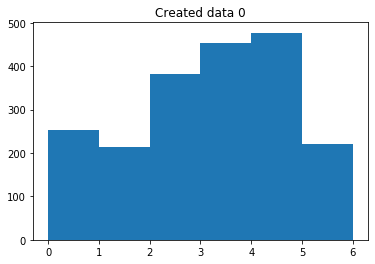

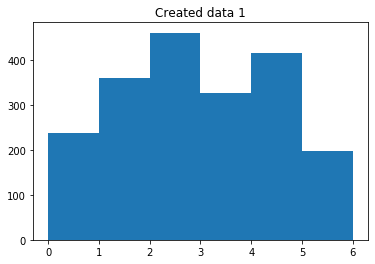

NameError: name 'm_lab' is not defined

In [31]:
plt.hist(created_data[0], bins=[0,1,2,3,4,5,6])
plt.title('Created data 0')
plt.show()
plt.hist(created_data[1], bins=[0,1,2,3,4,5,6])
plt.title('Created data 1')
plt.show()


plt.hist(m_lab, bins=[0,1,2,3,4,5,6])
plt.title('All data')
plt.show()

plt.hist(m_lab[:lab_lengths[0]], bins=[0,1,2,3,4,5,6])
plt.title('Actual data 1')
plt.show()
plt.hist(m_lab[lab_lengths[0]+1:lab_lengths[1]], bins=[0,1,2,3,4,5,6])
plt.title('Actual data 2')
plt.show()

In [0]:
# Turk created Data
ave_turk_length = int(np.round(mean(turk_lengths),0) ) # Ave length to nearest whole number
print( ave_turk_length )
print( turk_lengths[:10] )

# Now sample points 1999 times to get a created turk data distributions.
# np.round(np.array(turk_model.sample(10)[0]).reshape(-1),2)

turk_created_data = []

# Create 300 data samples
for i in range(300):
    turk_created_data.append( np.round(turk_model.sample(ave_turk_length)[0],0) )



In [0]:

# Visualize created Data.

plt.hist(turk_created_data[0], bins=[0,1,2,3,4,5,6])
plt.title('Created data 1')
plt.show()
plt.hist(turk_created_data[1], bins=[0,1,2,3,4,5,6])
plt.title('Created data 2')
plt.show()


plt.hist(m_turk, bins=[0,1,2,3,4,5,6])
plt.title('All data')
plt.show()

plt.hist(m_turk[:turk_lengths[0]], bins=[0,1,2,3,4,5,6])
plt.title('Actual data 1')
plt.show()
plt.hist(m_turk[turk_lengths[0]+1:turk_lengths[1]], bins=[0,1,2,3,4,5,6])
plt.title('Actual data 2')
plt.show()

In [0]:
df_turk_created = pd.DataFrame.from_records( turk_created_data )
#df_turk_created.replace([0.0],'html')
df_turk_created = df_turk_created.replace(0,'html')
df_turk_created = df_turk_created.replace(1,'alloc-slider-1')
df_turk_created = df_turk_created.replace(2,'alloc-slider-2')
df_turk_created = df_turk_created.replace(3,'alloc-slider-3')
df_turk_created = df_turk_created.replace(4,'alloc-slider-4')
df_turk_created = df_turk_created.replace(5,'alloc-slider-5')

In [0]:
created_turk_array = np.array(turk_created_data)
df_turk_created = pd.DataFrame(created_turk_array.flatten())

# Need to create a list of ID's that our generated samples can use.
gen_ids = []
for i in range(300): # 300 new samples created
    gen_ids.append([i]*ave_turk_length)
gen_ids = np.array(gen_ids).flatten()

df_turk_created['turkId'] = gen_ids
df_turk_created.columns = ['target', 'turkId']


df_turk_created['target'] = df_turk_created['target'].replace(0,'html')
df_turk_created['target'] = df_turk_created['target'].replace(1,'alloc-slider-1')
df_turk_created['target'] = df_turk_created['target'].replace(2,'alloc-slider-2')
df_turk_created['target'] = df_turk_created['target'].replace(3,'alloc-slider-3')
df_turk_created['target'] = df_turk_created['target'].replace(4,'alloc-slider-4')
df_turk_created['target'] = df_turk_created['target'].replace(5,'alloc-slider-5')
df_turk_created

In [ ]:
# TODO: Might have to convert targets to numerical representation, maybe one-hot encoding?

# Replace html with 0, and alloc-slider-1 to 1, alloc-slider-2 to 2, alloc-slider-3 to 3, alloc-slider-4 to 4, alloc-slider-5 to 5

df_m_lab.loc[df_m_lab['target'].str.contains('html'), 'target'] = '0'
df_m_lab.loc[df_m_lab['target'].str.contains('alloc-slider-1'), 'target'] = '1'
df_m_lab.loc[df_m_lab['target'].str.contains('alloc-slider-2'), 'target'] = '2'
df_m_lab.loc[df_m_lab['target'].str.contains('alloc-slider-3'), 'target'] = '3'
df_m_lab.loc[df_m_lab['target'].str.contains('alloc-slider-4'), 'target'] = '4'
df_m_lab.loc[df_m_lab['target'].str.contains('alloc-slider-5'), 'target'] = '5'
data_lab = df_m_lab['target'].to_numpy().reshape(-1, 1)

df_m_turk.loc[df_m_turk['target'].str.contains('html'), 'target'] = '0'
df_m_turk.loc[df_m_turk['target'].str.contains('alloc-slider-1'), 'target'] = '1'
df_m_turk.loc[df_m_turk['target'].str.contains('alloc-slider-2'), 'target'] = '2'
df_m_turk.loc[df_m_turk['target'].str.contains('alloc-slider-3'), 'target'] = '3'
df_m_turk.loc[df_m_turk['target'].str.contains('alloc-slider-4'), 'target'] = '4'
df_m_turk.loc[df_m_turk['target'].str.contains('alloc-slider-5'), 'target'] = '5'
data_turk = df_m_turk['target'].astype('int32').to_numpy().reshape(-1, 1)
data_turk.shape